# Kaggle Project - Data Cleaning and Analysis

###### Introduction:

The purpose of this project is to clean and analyze the Kaggle train.csv dataset. At the end of my cleaning I will complete a linear regression with the goal of achieving the highest adjusted-r^2 score. The dataset includes 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. For the purpose of Dr. Young's class, my model needs to meet these requirements: 

1. Include a function to read in the original train.csv dataset. You may not change or alter the file in any way using other software or save the file in a different format (.txt, .xlsx, etc.) 
2. Include markdown cells interspersed between code cells explaining the purpose of each block of code.  
3. Include code to generate a multiple linear model that uses at a minimum 24 columns from the train.csv dataset as SalePrice predictors.  
4. Include code to check the variance inflation factors of the model and ensure that no vif values greater than or equal to 10 exist in the model. If vif values greater than 10 exist, you must do further cleaning or revise your model.  Text must be included explaining the variance inflation factor results and your steps to reduce the vif values from your mode.  
5. Include code to assess the linear regression assumptions and explain what they indicate about your model.  If your model violates either the assumption of normal error terms with a 0 mean or the assumption of homskedasticity, you must update your model to ensure these assumptions are met."

### Reading in the data set, importing all libraries, and setting up 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
import pingouin as pg

In [2]:
House_Sales = pd.read_csv('train.csv')

In [3]:
House_Sales.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Grabbing the Variables I want in my linear regression

In [4]:
HS = House_Sales[['SalePrice','GarageArea','1stFlrSF','OverallQual','BsmtFullBath','BsmtHalfBath','FullBath',
                  'HalfBath','Neighborhood','GarageQual','YearRemodAdd','TotRmsAbvGrd','MasVnrArea',
                  'MasVnrType','OpenPorchSF','Exterior1st','MSSubClass','LotShape','TotalBsmtSF',
                  'YearBuilt','Foundation','PoolQC','FireplaceQu','KitchenQual','ExterQual',
                  'Fence','GarageFinish','GarageCars','WoodDeckSF','OpenPorchSF',
                  'EnclosedPorch','3SsnPorch','ScreenPorch','LotFrontage','LotArea','GrLivArea',
                  'PoolArea','2ndFlrSF','BsmtExposure','HeatingQC','RoofStyle','CentralAir',
                  'Electrical','YrSold']]

### 1) Cleaning Sale Price 

###### Exploration:

First I will check the descriptive statistics, the boxplot to show outliers, and kdeplot to show skewing as SalePrice is a numeric variable.

In [5]:
HS.agg(
        {
            'SalePrice':['min','mean', 'median','max','std'],
        }).round(2)

,SalePrice
min,34900.0
mean,180921.2
median,163000.0
max,755000.0
std,79442.5


<Axes: xlabel='SalePrice', ylabel='Density'>

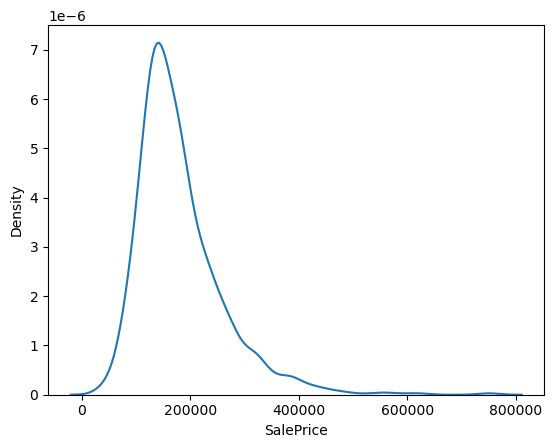

In [6]:
sns.kdeplot(x='SalePrice', data = HS)

In [7]:
SalePrice_mean = HS['SalePrice'].mean()
SalePrice_std = HS['SalePrice'].std()

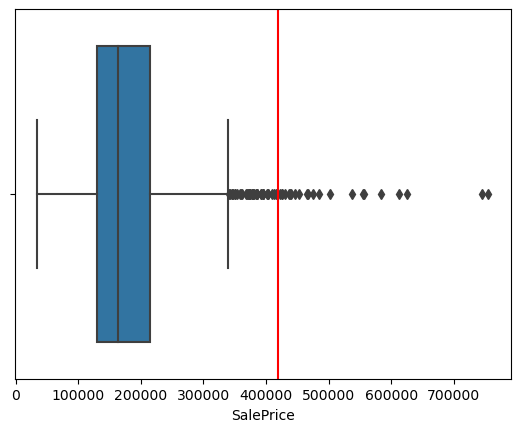

In [8]:
x = sns.boxplot(x='SalePrice', data = HS)
x = x.axvline(SalePrice_mean + 3* SalePrice_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

There are outliers that need to be cleaned, and the data is skewed pretty heavily to the right.

###### Cleaning:

As we can see there are outliers that need to be cleaned. I will replace these with the mean + 3 standard deviations, this will be based off of the neighborhood that the outliers are in.

In [9]:
HS.groupby("Neighborhood")["SalePrice"].agg(['mean', 'median','std']).round(0)

,mean,median,std
Neighborhood,,,
Blmngtn,194871.0,191000.0,30393.0
Blueste,137500.0,137500.0,19092.0
BrDale,104494.0,106000.0,14330.0
BrkSide,124834.0,124300.0,40349.0
ClearCr,212565.0,200250.0,50232.0
CollgCr,197966.0,197200.0,51404.0
Crawfor,210625.0,200624.0,68866.0
Edwards,128220.0,121750.0,43209.0
Gilbert,192855.0,181000.0,35987.0


In [10]:
((HS[HS['SalePrice'] > SalePrice_mean + 3* SalePrice_std]))

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,LotArea,GrLivArea,PoolArea,2ndFlrSF,BsmtExposure,HeatingQC,RoofStyle,CentralAir,Electrical,YrSold
58,438780,641,1426,10,0,0,3,1,StoneBr,TA,...,13682,2945,0,1519,Gd,Ex,Hip,Y,SBrkr,2006
178,501837,1166,2234,9,1,0,2,0,StoneBr,TA,...,17423,2234,0,0,No,Ex,Hip,Y,SBrkr,2009
185,475000,840,1518,10,0,0,2,1,OldTown,Ex,...,22950,3608,0,1518,Mn,Ex,Gable,Y,SBrkr,2006
349,437154,706,1848,9,1,0,2,1,NridgHt,TA,...,20431,2728,0,880,No,Ex,Hip,Y,SBrkr,2006
389,426000,846,1742,10,1,0,2,1,NridgHt,TA,...,12474,2332,0,590,Av,Ex,Gable,Y,SBrkr,2008
440,555000,672,2402,10,1,0,2,0,NridgHt,TA,...,15431,2402,0,0,Gd,Ex,Hip,Y,SBrkr,2009
473,440000,908,1976,8,1,0,2,0,NridgHt,TA,...,14977,1976,0,0,Gd,Ex,Gable,Y,SBrkr,2007
496,430000,546,3228,8,1,0,3,0,NoRidge,TA,...,12692,3228,0,0,No,Ex,Hip,Y,SBrkr,2007
527,446261,858,1476,9,1,0,2,1,NridgHt,TA,...,14948,2713,0,1237,Av,Ex,Hip,Y,SBrkr,2008
591,451950,842,1728,10,1,0,2,1,NridgHt,TA,...,13478,2296,0,568,Gd,Ex,Gable,Y,SBrkr,2009


In [11]:
len((HS[HS['SalePrice'] > SalePrice_mean + 3* SalePrice_std]))

22

###### Cleaning with each outliers grouped mean based on what neighborhood the house is in:

This will be the same process of outlier cleaning for all of numeric variables that I will describe now: I will pull the mean and standard deviation for the variable by the neighborhood that they are in, in this case SalePrice. I will then do the same for the standard deviation. Once I have those defined, I will make a replacement variable for the outliers that is the neighborhood's mean + 3*standard deviation as a replacement for the outliers. This keeps the variability while also ensuring the variability is not too much. Once I have that replacement variable, I will use it to replace all values that are considered outliers based on the neighborhood that they are in.

1. StoneBr:

In [12]:
StoneBr_SalePrice_mean = HS[(HS.Neighborhood == "StoneBr") &
                               (HS.SalePrice < SalePrice_mean + 3* SalePrice_std)]["SalePrice"].mean()
StoneBr_SalePrice_mean

272727.4761904762

In [13]:
StoneBr_SalePrice_std = HS[(HS.Neighborhood == "StoneBr") &
                               (HS.SalePrice < SalePrice_mean + 3* SalePrice_std)]["SalePrice"].std()
StoneBr_SalePrice_std

74482.14517830368

In [14]:
Replacement_SP_StoneBr = StoneBr_SalePrice_std + 3 * StoneBr_SalePrice_std

In [15]:
HS.loc[(HS.SalePrice > SalePrice_mean + 3* SalePrice_std) & 
       (HS.Neighborhood == "StoneBr"), "SalePrice"] = Replacement_SP_StoneBr 

2. NridgHt: 

In [16]:
NridgHt_SalePrice_mean = HS[(HS.Neighborhood == "NridgHt") &
                               (HS.SalePrice < SalePrice_mean + 3* SalePrice_std)]["SalePrice"].mean()
NridgHt_SalePrice_mean

290326.6119402985

In [17]:
NridgHt_SalePrice_std = HS[(HS.Neighborhood == "NridgHt") &
                               (HS.SalePrice < SalePrice_mean + 3* SalePrice_std)]["SalePrice"].std()
NridgHt_SalePrice_std

69396.339137781

In [18]:
Replacement_SP_NridgHt = NridgHt_SalePrice_mean + 3* NridgHt_SalePrice_std

In [19]:
HS.loc[(HS.SalePrice > SalePrice_mean + 3* SalePrice_std) & 
       (HS.Neighborhood == "NridgHt"), "SalePrice"] = Replacement_SP_NridgHt 

3. OldTown:

In [20]:
OldTown_SalePrice_mean = HS[(HS.Neighborhood == "OldTown") &
                               (HS.SalePrice < SalePrice_mean + 3* SalePrice_std)]["SalePrice"].mean()
OldTown_SalePrice_mean

125129.09821428571

In [21]:
OldTown_SalePrice_std = HS[(HS.Neighborhood == "OldTown") &
                               (HS.SalePrice < SalePrice_mean + 3* SalePrice_std)]["SalePrice"].std()
OldTown_SalePrice_std

41279.864558222835

In [22]:
Replacement_SP_OldTown = OldTown_SalePrice_mean + 3 * OldTown_SalePrice_std

In [23]:
HS.loc[(HS.SalePrice > SalePrice_mean + 3* SalePrice_std) & 
       (HS.Neighborhood == "OldTown"), "SalePrice"] = Replacement_SP_OldTown 

4. NoRidge: 

In [24]:
NoRidge_SalePrice_mean = HS[(HS.Neighborhood == "NoRidge") &
                               (HS.SalePrice < SalePrice_mean + 3* SalePrice_std)]["SalePrice"].mean()
NoRidge_SalePrice_mean

297933.55555555556

In [25]:
NoRidge_SalePrice_std = HS[(HS.Neighborhood == "NoRidge") &
                               (HS.SalePrice < SalePrice_mean + 3* SalePrice_std)]["SalePrice"].std()
NoRidge_SalePrice_std

49357.73376624662

In [26]:
SalePrice_mean + 3* SalePrice_std

419248.70453907084

In [27]:
Replacement_SP_NoRidge = NoRidge_SalePrice_mean + 3 * NoRidge_SalePrice_std
Replacement_SP_NoRidge

446006.75685429544

In [28]:
HS.loc[(HS.SalePrice > SalePrice_mean + 3* SalePrice_std) & 
       (HS.Neighborhood == "NoRidge"), "SalePrice"] = Replacement_SP_NoRidge 

5. Somerst:

In [29]:
Somerst_SalePrice_mean = HS[(HS.Neighborhood == "Somerst") &
                               (HS.SalePrice < SalePrice_mean + 3* SalePrice_std)]["SalePrice"].mean()
Somerst_SalePrice_mean

223054.89411764705

In [30]:
Somerst_SalePrice_std = HS[(HS.Neighborhood == "Somerst") &
                               (HS.SalePrice < SalePrice_mean + 3* SalePrice_std)]["SalePrice"].std()
Somerst_SalePrice_std

52183.26535714197

In [31]:
Replacement_SP_Somerst = Somerst_SalePrice_mean + 3 * Somerst_SalePrice_std

In [32]:
HS.loc[(HS.SalePrice > SalePrice_mean + 3* SalePrice_std) & 
       (HS.Neighborhood == "Somerst"), "SalePrice"] = Replacement_SP_Somerst 

6. CollgCr:

In [33]:
CollgCr_SalePrice_mean = HS[(HS.Neighborhood == "CollgCr") &
                               (HS.SalePrice < SalePrice_mean + 3* SalePrice_std)]["SalePrice"].mean()
CollgCr_SalePrice_mean

196442.92617449665

In [34]:
CollgCr_SalePrice_std = HS[(HS.Neighborhood == "CollgCr") &
                               (HS.SalePrice < SalePrice_mean + 3* SalePrice_std)]["SalePrice"].std()
CollgCr_SalePrice_std

48062.257839279424

In [35]:
Replacement_SP_CollgCr = CollgCr_SalePrice_mean + 3 * CollgCr_SalePrice_std

In [36]:
HS.loc[(HS.SalePrice > SalePrice_mean + 3* SalePrice_std) & 
       (HS.Neighborhood == "CollgCr"), "SalePrice"] = Replacement_SP_CollgCr 

###### Outliers delt with

2. Now that the outliers are cleaned, I will look for null values

In [37]:
HS[HS.SalePrice.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,LotArea,GrLivArea,PoolArea,2ndFlrSF,BsmtExposure,HeatingQC,RoofStyle,CentralAir,Electrical,YrSold


3. There are no null values, outliers have been cleaned, and all values look like they make sense to me. Now I will use boxcox to better have SalePrice follow a normal distribution.

In [38]:
HS["SalePrice_log"] = np.log10(HS.SalePrice)   

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/2475373103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["SalePrice_log"] = np.log10(HS.SalePrice)


4. Now that the data is cleaned and bests follows a normal distribution, I will save the standard deviation values (z-scores) for each individual value to help me in the future.

In [39]:
scaler = StandardScaler()
HS["SalePrice_std"] = scaler.fit_transform(HS[['SalePrice_log']])
HS[["SalePrice_std", "SalePrice", "SalePrice_log"]].head(10)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/3860748009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["SalePrice_std"] = scaler.fit_transform(HS[['SalePrice_log']])


,SalePrice_std,SalePrice,SalePrice_log
0,0.577500,208500.0,5.319106
1,0.223971,181500.0,5.258877
2,0.754598,223500.0,5.349278
3,-0.437830,140000.0,5.146128
4,1.040232,250000.0,5.397940
5,-0.383782,143000.0,5.155336
6,1.563801,307000.0,5.487138
7,0.471399,200000.0,5.301030
8,-0.628706,129900.0,5.113609
9,-0.873633,118000.0,5.071882


<Axes: xlabel='SalePrice_std', ylabel='Density'>

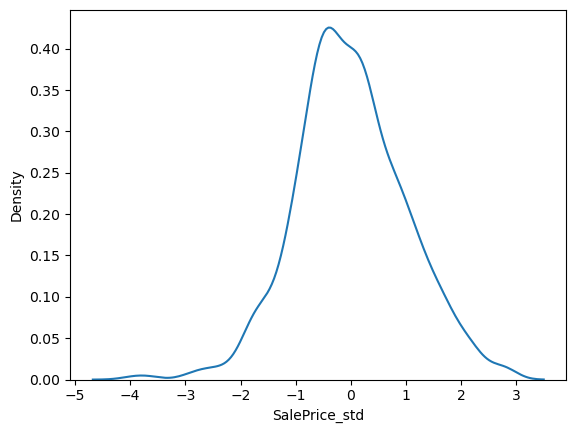

In [40]:
sns.kdeplot(x='SalePrice_std', data = HS)

In [41]:
SalePrice_mean = HS['SalePrice_std'].mean()
SalePrice_std = HS['SalePrice_std'].std()

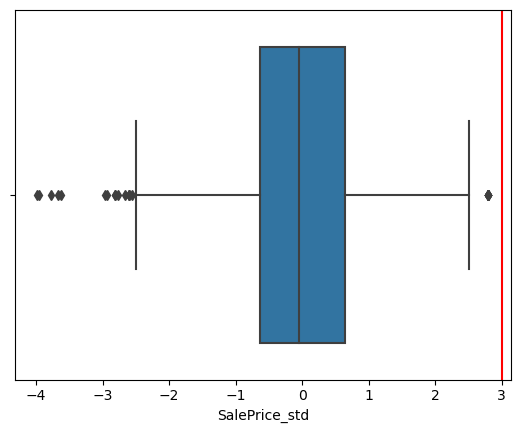

In [42]:
x = sns.boxplot(x='SalePrice_std', data = HS)
x = x.axvline(SalePrice_mean + 3* SalePrice_std, ymin = 0, ymax = 1, color = 'red')

plt.show()

In [43]:
HS[HS.SalePrice_std < -3]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,PoolArea,2ndFlrSF,BsmtExposure,HeatingQC,RoofStyle,CentralAir,Electrical,YrSold,SalePrice_log,SalePrice_std
30,40000.0,250,649,4,0,0,1,0,IDOTRR,TA,...,0,668,No,TA,Gambrel,N,SBrkr,2008,4.602060,-3.631350
495,34900.0,0,720,4,0,0,1,0,IDOTRR,NaN,...,0,0,No,TA,Gable,N,FuseA,2009,4.542825,-3.979040
533,39300.0,0,334,1,0,0,1,0,BrkSide,NaN,...,0,0,NaN,Fa,Gable,N,FuseF,2007,4.594393,-3.676356
916,35311.0,308,480,2,1,0,0,0,IDOTRR,TA,...,0,0,Av,TA,Gable,N,FuseA,2006,4.547910,-3.949195
968,37900.0,0,600,3,0,0,1,0,OldTown,NaN,...,0,368,No,Fa,Gable,N,SBrkr,2009,4.578639,-3.768823


In [44]:
rows = [30,495,533,916,968]
columns = ['SalePrice_std']

In [45]:
HS.loc[rows,columns] = [-3]

In [46]:
HS[HS.SalePrice_std < -3]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,PoolArea,2ndFlrSF,BsmtExposure,HeatingQC,RoofStyle,CentralAir,Electrical,YrSold,SalePrice_log,SalePrice_std


<Axes: xlabel='SalePrice_std', ylabel='Density'>

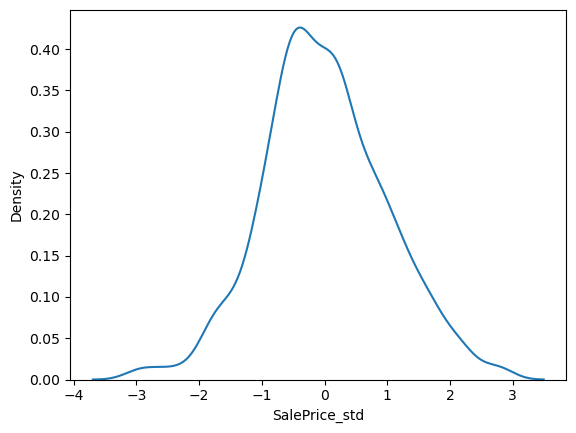

In [47]:
sns.kdeplot(x='SalePrice_std', data = HS)

In [48]:
SalePrice_mean = HS['SalePrice_std'].mean()
SalePrice_std = HS['SalePrice_std'].std()

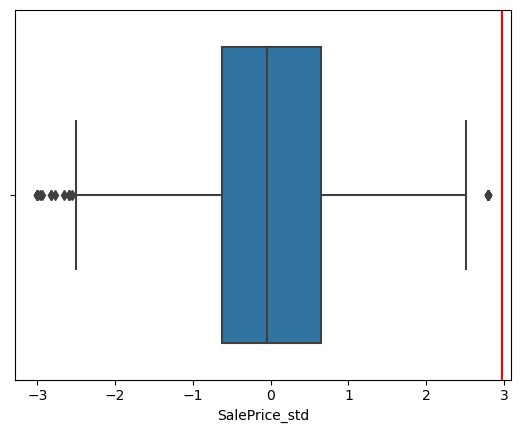

In [49]:
x = sns.boxplot(x='SalePrice_std', data = HS)
x = x.axvline(SalePrice_mean + 3* SalePrice_std, ymin = 0, ymax = 1, color = 'red')

plt.show()

### 2) Cleaning GarageArea

###### Exploration:

First I will check the descriptive statistics, the boxplot to show outliers, and kdeplot to show skewing as GarageArea is a numeric variable.

In [50]:
HS.agg(
        {
            'GarageArea':['min','mean', 'median','max','std'],
        }).round(2)

,GarageArea
min,0.00
mean,472.98
median,480.00
max,1418.00
std,213.80


In [51]:
GarageArea_mean = HS['GarageArea'].mean()
GarageArea_std = HS['GarageArea'].std()

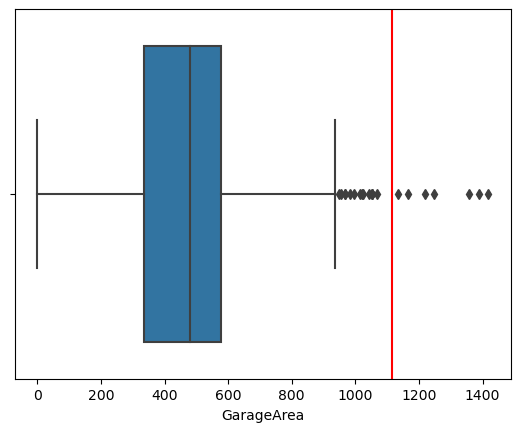

In [52]:
x = sns.boxplot(x='GarageArea', data = HS)
x = x.axvline(GarageArea_mean + 3* GarageArea_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

<Axes: xlabel='GarageArea', ylabel='Density'>

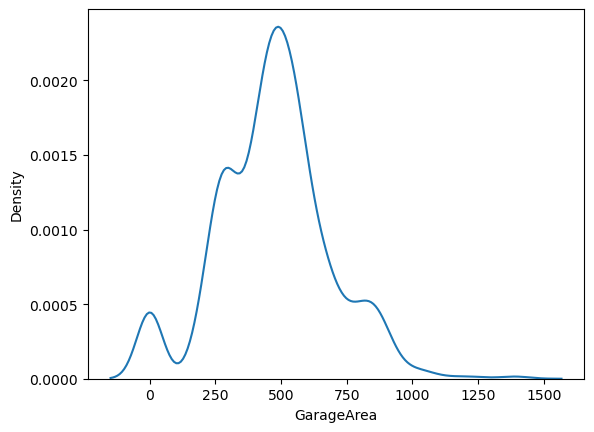

In [53]:
sns.kdeplot(x='GarageArea', data = HS)

###### Cleaning:

1. As we can tell from the Boxplot there are some outliers that need to be cleaned. I will clean using the median GarageArea based on the neighborhood the garage is in, as I am sure the sizes vary based on what area they are in. I will replace by each neighborhoods mean value + 3 standard deviations

In [54]:
HS.groupby("Neighborhood")["GarageArea"].agg(['mean', 'median','std']).round(0)

,mean,median,std
Neighborhood,,,
Blmngtn,503.0,438.0,115.0
Blueste,457.0,457.0,7.0
BrDale,284.0,264.0,102.0
BrkSide,303.0,280.0,193.0
ClearCr,468.0,476.0,147.0
CollgCr,553.0,546.0,162.0
Crawfor,410.0,380.0,203.0
Edwards,326.0,318.0,236.0
Gilbert,453.0,427.0,89.0


In [55]:
(HS[HS['GarageArea'] > GarageArea_mean + 3* GarageArea_std])

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,PoolArea,2ndFlrSF,BsmtExposure,HeatingQC,RoofStyle,CentralAir,Electrical,YrSold,SalePrice_log,SalePrice_std
178,297928.580713,1166,2234,9,1,0,2,0,StoneBr,TA,...,0,0,No,Ex,Hip,Y,SBrkr,2009,5.474112,1.487341
581,253293.000000,1390,2042,8,0,0,2,1,NridgHt,TA,...,0,0,No,Ex,Hip,Y,SBrkr,2009,5.403623,1.073591
664,379604.690189,1134,2097,8,1,0,1,1,Somerst,TA,...,0,0,Mn,Ex,Gable,Y,SBrkr,2006,5.579332,2.104948
825,385000.000000,1220,2084,10,1,0,2,0,NridgHt,TA,...,0,0,Av,Ex,Hip,Y,SBrkr,2008,5.585461,2.140924
1061,81000.000000,1248,894,3,0,0,1,0,IDOTRR,TA,...,0,0,No,TA,Gable,Y,SBrkr,2008,4.908485,-1.832725
1190,168000.000000,1356,1622,4,1,0,1,0,Mitchel,TA,...,0,0,Av,Ex,Gable,Y,SBrkr,2007,5.225309,0.026941
1298,160000.000000,1418,4692,10,2,0,2,1,Edwards,TA,...,480,950,Gd,Ex,Hip,Y,SBrkr,2008,5.204120,-0.097434


###### Cleaning with each outliers grouped mean based on what neighborhood the house is in:

1. StoneBr:

In [56]:
StoneBr_GarageArea_mean = HS[(HS.Neighborhood == "StoneBr") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].mean()
StoneBr_GarageArea_mean

609.25

In [57]:
StoneBr_GarageArea_std = HS[(HS.Neighborhood == "StoneBr") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].std()
StoneBr_GarageArea_std

123.11368023444659

In [58]:
Replacement_StoneBr = StoneBr_GarageArea_mean + 3 * StoneBr_GarageArea_std

In [59]:
HS.loc[(HS.GarageArea > GarageArea_mean + 3* GarageArea_std) & 
       (HS.Neighborhood == "StoneBr"), "GarageArea"] = Replacement_StoneBr 

2. NridgHt: 

In [60]:
NridgHt_GarageArea_mean = HS[(HS.Neighborhood == "NridgHt") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].mean()
NridgHt_GarageArea_mean

730.84

In [61]:
NridgHt_GarageArea_std = HS[(HS.Neighborhood == "NridgHt") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].std()
NridgHt_GarageArea_std

157.00404883744673

In [62]:
Replacement_NridgHt = NridgHt_GarageArea_mean + 3 * NridgHt_GarageArea_std

In [63]:
HS.loc[(HS.GarageArea > GarageArea_mean + 3* GarageArea_std) & 
       (HS.Neighborhood == "NridgHt"),'GarageArea'] = Replacement_NridgHt 

3. Somerst:

In [64]:
Somerst_GarageArea_mean = HS[(HS.Neighborhood == "Somerst") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].mean()
Somerst_GarageArea_mean

624.7058823529412

In [65]:
Somerst_GarageArea_std = HS[(HS.Neighborhood == "Somerst") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].std()
Somerst_GarageArea_std

161.38174378439078

In [66]:
Replacement_Somerst = Somerst_GarageArea_mean + 3 * Somerst_GarageArea_std

In [67]:
HS.loc[(HS.GarageArea > GarageArea_mean + 3* GarageArea_std) & 
       (HS.Neighborhood == "Somerst"), "GarageArea"] = Replacement_Somerst 

4. IDOTRR:

In [68]:
IDOTRR_GarageArea_mean = HS[(HS.Neighborhood == "IDOTRR") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].mean()
IDOTRR_GarageArea_mean

290.1111111111111

In [69]:
IDOTRR_GarageArea_std = HS[(HS.Neighborhood == "IDOTRR") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].std()
IDOTRR_GarageArea_std

211.3647866033342

In [70]:
Replacement_IDOTRR = IDOTRR_GarageArea_mean + 3 * IDOTRR_GarageArea_std

In [71]:
HS.loc[(HS.GarageArea > GarageArea_mean + 3* GarageArea_std) & 
       (HS.Neighborhood == "IDOTRR"), "GarageArea"] = Replacement_IDOTRR 

5. Mitchel: 

In [72]:
Mitchel_GarageArea_mean = HS[(HS.Neighborhood == "Mitchel") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].mean()
Mitchel_GarageArea_mean

463.7916666666667

In [73]:
Mitchel_GarageArea_std = HS[(HS.Neighborhood == "Mitchel") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].std()
Mitchel_GarageArea_std

218.4357306846028

In [74]:
Replacement_Mitchel = Mitchel_GarageArea_mean + 3 * Mitchel_GarageArea_std
Replacement_Mitchel

1119.0988587204752

In [75]:
HS.loc[(HS.GarageArea > GarageArea_mean + 3* GarageArea_std) & 
       (HS.Neighborhood == "Mitchel"), "GarageArea"] = Replacement_Mitchel

6. Edwards:

In [76]:
Edwards_GarageArea_mean = HS[(HS.Neighborhood == "Edwards") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].mean()
Edwards_GarageArea_mean

315.17171717171715

In [77]:
Edwards_GarageArea_std = HS[(HS.Neighborhood == "Edwards") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].std()
Edwards_GarageArea_std

209.259581030699

In [78]:
Replacement_Edwards = Edwards_GarageArea_mean + 3 * Edwards_GarageArea_std
Replacement_Edwards

942.9504602638142

In [79]:
HS.loc[(HS.GarageArea > GarageArea_mean + 3* GarageArea_std) & 
       (HS.Neighborhood == "Edwards"), "GarageArea"] = Replacement_Edwards

2. The outliers have now been removed. Now, I will check for null values.

In [80]:
HS[HS['GarageArea'].isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,PoolArea,2ndFlrSF,BsmtExposure,HeatingQC,RoofStyle,CentralAir,Electrical,YrSold,SalePrice_log,SalePrice_std


3. There are no null values, outliers have been cleaned, and all values look like they make sense to me. Now I will use boxcox to better have GarageArea follow a normal distribution. Because there are 0 values I will add the small value of 0.1 so that boxcox can work.

In [81]:
GarageArea_transformed, best_lambda = boxcox(HS['GarageArea'] + 0.1) 
HS['GarageArea_trans'] = GarageArea_transformed

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/2167642917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['GarageArea_trans'] = GarageArea_transformed


4. Now that the data is cleaned and bests follows a normal distribution, I will save the standard deviation values (z-scores) for each individual value to help me in the future.

### 3) Cleaning TotalSqFt

Checking to see if GrLivArea includes both 2ndFlrSf and 1stFlrSf.

In [82]:
WD = HS[['GrLivArea','1stFlrSF','2ndFlrSF']]

In [83]:
WD.head()

,GrLivArea,1stFlrSF,2ndFlrSF
0,1710,856,854
1,1262,1262,0
2,1786,920,866
3,1717,961,756
4,2198,1145,1053


It does so we will sum it with TotalBsmtSf to get TotalSqFt.

In [84]:
WE = HS[['GrLivArea','TotalBsmtSF']]

In [85]:
HS['TotalSqFt'] = WE.sum(axis = 'columns')

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/3869631790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['TotalSqFt'] = WE.sum(axis = 'columns')


###### Exploration:

First I will check the descriptive statistics, the boxplot to show outliers, and kdeplot to show skewing as TotalSqFt is a numeric variable.

In [86]:
HS.agg(
        {
            'TotalSqFt':['min','mean', 'median','max','std'],
        }).round(2)

,TotalSqFt
min,334.00
mean,2572.89
median,2479.00
max,11752.00
std,823.60


In [87]:
TotalSqFt_mean = HS['TotalSqFt'].mean()
TotalSqFt_std = HS['TotalSqFt'].std()

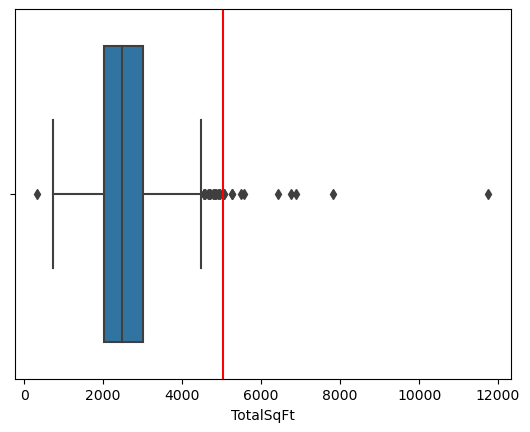

In [88]:
x = sns.boxplot(x='TotalSqFt', data = HS)
x = x.axvline(TotalSqFt_mean + 3* TotalSqFt_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

<Axes: xlabel='TotalSqFt', ylabel='Density'>

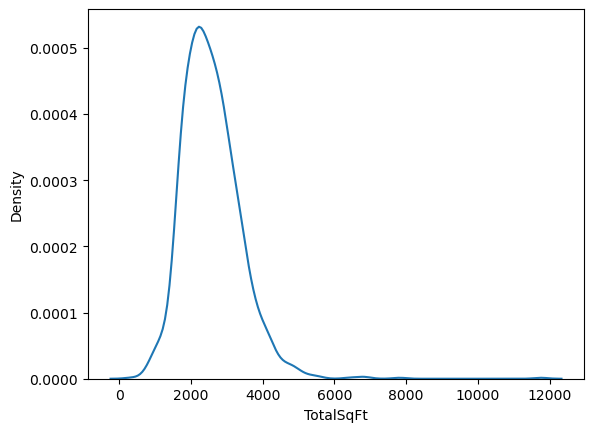

In [89]:
sns.kdeplot(x='TotalSqFt', data = HS)

###### Cleaning:

As we can tell from the Boxplot there are some outliers that need to be cleaned. I will use the same method I have to clean it.

In [90]:
HS.groupby("Neighborhood")["TotalSqFt"].agg(['mean', 'median','std']).round(0)

,mean,median,std
Neighborhood,,,
Blmngtn,2752.0,2850.0,214.0
Blueste,2031.0,2031.0,341.0
BrDale,1727.0,1754.0,259.0
BrkSide,1968.0,1984.0,579.0
ClearCr,3014.0,3046.0,613.0
CollgCr,2638.0,2648.0,616.0
Crawfor,2825.0,2809.0,730.0
Edwards,2240.0,2086.0,1254.0
Gilbert,2510.0,2516.0,433.0


In [91]:
(HS[HS['TotalSqFt'] > TotalSqFt_mean + 3* TotalSqFt_std])

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,BsmtExposure,HeatingQC,RoofStyle,CentralAir,Electrical,YrSold,SalePrice_log,SalePrice_std,GarageArea_trans,TotalSqFt
440,498515.629354,672.00000,2402,10,1,0,2,0,NridgHt,TA,...,Gd,Ex,Hip,Y,SBrkr,2009,5.697679,2.799611,175.830632,5496
496,446006.756854,546.00000,3228,8,1,0,3,0,NoRidge,TA,...,No,Ex,Hip,Y,SBrkr,2007,5.649341,2.515885,150.246192,6428
523,184750.000000,884.00000,3138,10,1,0,3,1,Edwards,TA,...,Gd,Ex,Hip,Y,SBrkr,2007,5.266584,0.269214,216.350502,7814
691,446006.756854,832.00000,2444,10,0,1,3,1,NoRidge,TA,...,Gd,Ex,Gable,Y,SBrkr,2007,5.649341,2.515885,206.659590,6760
798,498515.629354,820.00000,1966,9,0,0,3,1,NridgHt,TA,...,No,Ex,Hip,Y,SBrkr,2009,5.697679,2.799611,204.402087,5066
1044,278000.000000,542.00000,2524,8,1,0,2,1,NWAmes,TA,...,No,TA,Hip,Y,SBrkr,2009,5.444045,1.310854,149.411331,5048
1169,446006.756854,807.00000,1831,10,1,0,3,1,NoRidge,TA,...,Gd,Ex,Hip,Y,SBrkr,2006,5.649341,2.515885,201.947164,5557
1182,446006.756854,813.00000,2411,10,1,0,3,1,NoRidge,TA,...,Av,Ex,Hip,Y,SBrkr,2007,5.649341,2.515885,203.081418,6872
1298,160000.000000,942.95046,4692,10,2,0,2,1,Edwards,TA,...,Gd,Ex,Hip,Y,SBrkr,2008,5.204120,-0.097434,227.166939,11752
1353,410000.000000,666.00000,2053,8,1,0,2,1,NoRidge,TA,...,Av,Ex,Hip,Y,SBrkr,2010,5.612784,2.301303,174.641125,5271


###### Cleaning with each outliers grouped mean based on what neighborhood the house is in:

1. NridgHt: 

In [92]:
NridgHt_TotalSqFt_mean = HS[(HS.Neighborhood == "NridgHt") &
                               (HS['TotalSqFt'] < TotalSqFt_mean + 3* TotalSqFt_std)]["TotalSqFt"].mean()
NridgHt_TotalSqFt_mean

3471.786666666667

In [93]:
NridgHt_TotalSqFt_std = HS[(HS.Neighborhood == "NridgHt") &
                               (HS['TotalSqFt'] < TotalSqFt_mean + 3* TotalSqFt_std)]["TotalSqFt"].std()
NridgHt_TotalSqFt_std

608.592956175395

In [94]:
Replacement_TotalSqFt_NridgHt = NridgHt_TotalSqFt_mean + 3 * NridgHt_TotalSqFt_std
Replacement_TotalSqFt_NridgHt

5297.565535192852

In [95]:
HS.loc[(HS['TotalSqFt'] > TotalSqFt_mean + 3* TotalSqFt_std) & 
       (HS.Neighborhood == "NridgHt"), "TotalSqFt"] = Replacement_TotalSqFt_NridgHt 

2. NoRidge: 

In [96]:
NoRidge_TotalSqFt_mean = HS[(HS.Neighborhood == "NoRidge") &
                               (HS['TotalSqFt'] < TotalSqFt_mean + 3* TotalSqFt_std)]["TotalSqFt"].mean()
NoRidge_TotalSqFt_mean

3655.8

In [97]:
NoRidge_TotalSqFt_std = HS[(HS.Neighborhood == "NoRidge") &
                               (HS['TotalSqFt'] < TotalSqFt_mean + 3* TotalSqFt_std)]["TotalSqFt"].std()
NoRidge_TotalSqFt_std

434.0306169737202

In [98]:
Replacement_TotalSqFt_NoRidge = NoRidge_TotalSqFt_mean + 3 * NoRidge_TotalSqFt_std
Replacement_TotalSqFt_NoRidge

4957.891850921161

In [99]:
HS.loc[(HS['TotalSqFt'] > TotalSqFt_mean + 3* TotalSqFt_std) & 
       (HS.Neighborhood == "NoRidge"), "TotalSqFt"] = Replacement_TotalSqFt_NoRidge 

3. Edwards: 

In [100]:
Edwards_TotalSqFt_mean = HS[(HS.Neighborhood == "Edwards") &
                               (HS['TotalSqFt'] < TotalSqFt_mean + 3* TotalSqFt_std)]["TotalSqFt"].mean()
Edwards_TotalSqFt_mean

2085.918367346939

In [101]:
Edwards_TotalSqFt_std = HS[(HS.Neighborhood == "Edwards") &
                               (HS['TotalSqFt'] < TotalSqFt_mean + 3* TotalSqFt_std)]["TotalSqFt"].std()
Edwards_TotalSqFt_std

571.6280362474457

In [102]:
Replacement_TotalSqFt_Edwards = Edwards_TotalSqFt_mean + 3 * Edwards_TotalSqFt_std
Replacement_TotalSqFt_Edwards

3800.802476089276

In [103]:
HS.loc[(HS['TotalSqFt'] > TotalSqFt_mean + 3* TotalSqFt_std) & 
       (HS.Neighborhood == "Edwards"), "TotalSqFt"] = Replacement_TotalSqFt_Edwards 

4. NWAmes: 

In [104]:
NWAmes_TotalSqFt_mean = HS[(HS.Neighborhood == "NWAmes") &
                               (HS['TotalSqFt'] < TotalSqFt_mean + 3* TotalSqFt_std)]["TotalSqFt"].mean()
NWAmes_TotalSqFt_mean

2851.527777777778

In [105]:
NWAmes_TotalSqFt_std = HS[(HS.Neighborhood == "NWAmes") &
                               (HS['TotalSqFt'] < TotalSqFt_mean + 3* TotalSqFt_std)]["TotalSqFt"].std()
NWAmes_TotalSqFt_std

517.5676582898783

In [106]:
Replacement_TotalSqFt_NWAmes = NWAmes_TotalSqFt_mean + 3 * NWAmes_TotalSqFt_std
Replacement_TotalSqFt_NWAmes

4404.230752647412

In [107]:
HS.loc[(HS['TotalSqFt'] > TotalSqFt_mean + 3* TotalSqFt_std) & 
       (HS.Neighborhood == "NWAmes"), "TotalSqFt"] = Replacement_TotalSqFt_NWAmes 

###### Outliers have been cleaned

2. The outliers have now been removed. Now, I will check for null values.

In [108]:
HS[HS['TotalBsmtSF'].isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,BsmtExposure,HeatingQC,RoofStyle,CentralAir,Electrical,YrSold,SalePrice_log,SalePrice_std,GarageArea_trans,TotalSqFt


3. There are no null values, outliers have been cleaned, and all values look like they make sense to me. Now I will use boxcox to better have TotalSqFt follow a normal distribution.

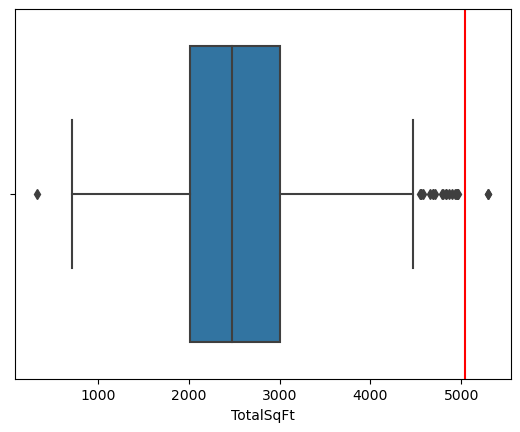

In [109]:
x = sns.boxplot(x='TotalSqFt', data = HS)
x = x.axvline(TotalSqFt_mean + 3* TotalSqFt_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

<Axes: xlabel='TotalSqFt', ylabel='Density'>

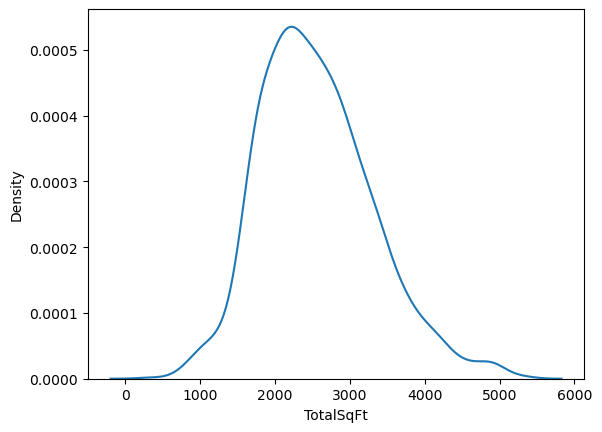

In [110]:
sns.kdeplot(x='TotalSqFt', data = HS)

In [111]:
TotalSqFt_Transformed, best_lambda = boxcox(HS['TotalSqFt'])  

In [112]:
HS["TotalSqFt_Trans"] = TotalSqFt_Transformed

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/970100552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["TotalSqFt_Trans"] = TotalSqFt_Transformed


4. Now that the data is cleaned and bests follows a normal distribution, I will save the standard deviation values (z-scores) for each individual value to help me in the future.

In [113]:
scaler = StandardScaler()
HS["TotalSqFt_std"] = scaler.fit_transform(HS[['TotalSqFt_Trans']])
HS[["TotalSqFt_std", "TotalSqFt",'TotalSqFt_Trans']].head(10)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/4246464173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["TotalSqFt_std"] = scaler.fit_transform(HS[['TotalSqFt_Trans']])


,TotalSqFt_std,TotalSqFt,TotalSqFt_Trans
0,0.092467,2566.0,66.286623
1,0.036885,2524.0,65.799711
2,0.274094,2706.0,67.877727
3,-0.031318,2473.0,65.202227
4,1.039560,3343.0,74.583435
5,-0.471485,2158.0,61.346236
6,1.081362,3380.0,74.949630
7,0.871994,3197.0,73.115503
8,0.299601,2726.0,68.101174
9,-0.603880,2068.0,60.186419


### 4) Cleaning 1stFlrSF

###### Exploration:

To eliminate issues with multicollinearity, I will calculate the proportion of square footage on the 1st floor in regards to the total TotalSqFt.

In [114]:
WS = HS[['TotalSqFt','1stFlrSF']]

In [115]:
HS['Prop_of_SF_on_1st'] = WS['1stFlrSF']/WS['TotalSqFt']

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/3799534717.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['Prop_of_SF_on_1st'] = WS['1stFlrSF']/WS['TotalSqFt']


In [116]:
HS.head()

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,CentralAir,Electrical,YrSold,SalePrice_log,SalePrice_std,GarageArea_trans,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st
0,208500.0,548.0,856,7,1,0,2,1,CollgCr,TA,...,Y,SBrkr,2008,5.319106,0.577500,150.663052,2566.0,66.286623,0.092467,0.333593
1,181500.0,460.0,1262,6,0,1,2,0,Veenker,TA,...,Y,SBrkr,2007,5.258877,0.223971,131.936536,2524.0,65.799711,0.036885,0.500000
2,223500.0,608.0,920,7,1,0,2,1,CollgCr,TA,...,Y,SBrkr,2008,5.349278,0.754598,163.000304,2706.0,67.877727,0.274094,0.339985
3,140000.0,642.0,961,7,1,0,1,0,Crawfor,TA,...,Y,SBrkr,2006,5.146128,-0.437830,169.856111,2473.0,65.202227,-0.031318,0.388597
4,250000.0,836.0,1145,8,1,0,2,1,NoRidge,TA,...,Y,SBrkr,2008,5.397940,1.040232,207.410288,3343.0,74.583435,1.039560,0.342507


Now I will check the descriptive statistics, the boxplot to show outliers, and kdeplot to show skewing as Prop_of_SF_on_1st is a numeric variable.

In [117]:
HS.agg(
        {
            'Prop_of_SF_on_1st':['min','mean', 'median','max','std'],
        }).round(2)

,Prop_of_SF_on_1st
min,0.26
mean,0.46
median,0.50
max,1.23
std,0.12


In [118]:
(HS[HS['Prop_of_SF_on_1st'] > 1.00001])

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,CentralAir,Electrical,YrSold,SalePrice_log,SalePrice_std,GarageArea_trans,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st
1298,160000.0,942.95046,4692,10,2,0,2,1,Edwards,TA,...,Y,SBrkr,2008,5.20412,-0.097434,227.166939,3800.802476,78.963348,1.539534,1.234476


In [119]:
Prop_of_SF_on_1st_mean = HS['Prop_of_SF_on_1st'].mean()
Prop_of_SF_on_1st_std = HS['Prop_of_SF_on_1st'].std()

Because the proportion is over 1, I am just going to replace it with with the mean proportion so it does not mess up the data.

In [120]:
HS.loc[HS['Prop_of_SF_on_1st'] > 1.00001, 'Prop_of_SF_on_1st'] = Prop_of_SF_on_1st_mean

In [121]:
(HS[HS['Prop_of_SF_on_1st'] > 1.00001])

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,CentralAir,Electrical,YrSold,SalePrice_log,SalePrice_std,GarageArea_trans,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st


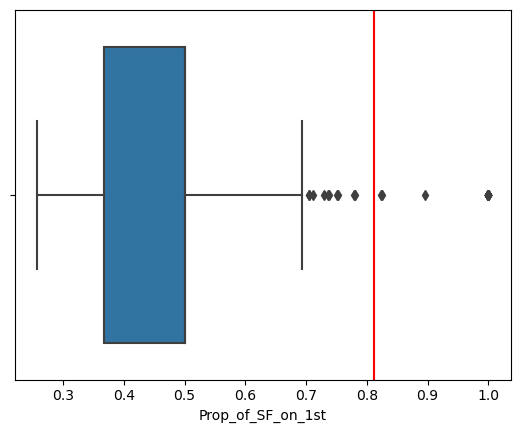

In [122]:
x = sns.boxplot(x='Prop_of_SF_on_1st', data = HS)
x = x.axvline(Prop_of_SF_on_1st_mean + 3* Prop_of_SF_on_1st_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

<Axes: xlabel='Prop_of_SF_on_1st', ylabel='Density'>

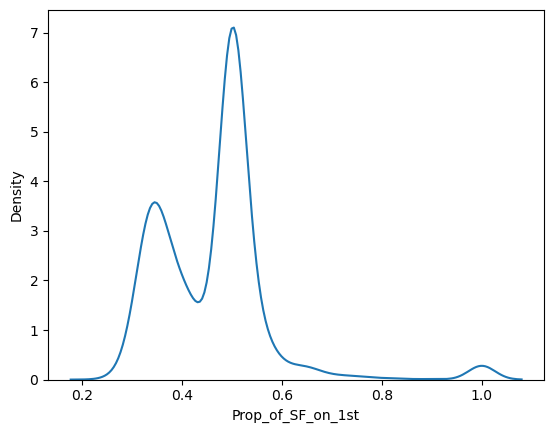

In [123]:
sns.kdeplot(x='Prop_of_SF_on_1st', data = HS)

###### Cleaning:

1. As we can tell from the Boxplot there are some outliers that need to be cleaned. However, because it is a proportion I will not do that. Rather, I will just use a boxplot to help it follow a normal distribution.

###### Outliers have been cleaned

2. The outliers have now been removed. Now, I will check for null values.

In [124]:
HS[HS['Prop_of_SF_on_1st'].isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,CentralAir,Electrical,YrSold,SalePrice_log,SalePrice_std,GarageArea_trans,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st


3. There are no null values, outliers have been cleaned, and all values look like they make sense to me. Now I will use boxcox to better have 1stFlrSF follow a normal distribution.

In [125]:
Prop_of_SF_on_1st_Transformed, best_lambda = boxcox(HS['Prop_of_SF_on_1st'])  

In [126]:
HS["Prop_of_SF_on_1st_Trans"] = Prop_of_SF_on_1st_Transformed

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/3233030863.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["Prop_of_SF_on_1st_Trans"] = Prop_of_SF_on_1st_Transformed


4. Now that the data is cleaned and bests follows a normal distribution, I will save the standard deviation values (z-scores) for each individual value to help me in the future.

In [127]:
scaler = StandardScaler()
HS["Prop_of_SF_on_1st_std"] = scaler.fit_transform(HS[['Prop_of_SF_on_1st_Trans']])
HS[["Prop_of_SF_on_1st_std", "Prop_of_SF_on_1st",'Prop_of_SF_on_1st_Trans']].head(10)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/175301458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["Prop_of_SF_on_1st_std"] = scaler.fit_transform(HS[['Prop_of_SF_on_1st_Trans']])


,Prop_of_SF_on_1st_std,Prop_of_SF_on_1st,Prop_of_SF_on_1st_Trans
0,-1.420916,0.333593,-1.508856
1,0.512488,0.500000,-0.844289
2,-1.320269,0.339985,-1.474260
3,-0.640663,0.388597,-1.240660
4,-1.281370,0.342507,-1.460890
5,-0.899794,0.368860,-1.329731
6,0.522562,0.501183,-0.840826
7,-1.224252,0.346262,-1.441257
8,-0.818138,0.374908,-1.301664
9,0.684291,0.520793,-0.785235


### 5) Cleaning All_House_Baths

I will combine the BsmtFullBath, BsmtHalfBath, FullBath, and HalfBath together in order to make it one column of bathrooms in the house. I will treat half baths as 0.5 and full baths as 1.0. I will then do analysis on my All_House__Baths variable as opposed to each one individually.

In [128]:
HS["House_Full_Baths"] = HS.BsmtFullBath + HS.FullBath

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/1456219511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["House_Full_Baths"] = HS.BsmtFullBath + HS.FullBath


In [129]:
HS["House_Half_Baths"] = HS.BsmtHalfBath + HS.HalfBath

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/864572005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["House_Half_Baths"] = HS.BsmtHalfBath + HS.HalfBath


In [130]:
HS["House_Half_Baths"] = HS.House_Half_Baths/2

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/2330289165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["House_Half_Baths"] = HS.House_Half_Baths/2


In [131]:
HS['All_House_Baths'] = HS.House_Half_Baths + HS.House_Full_Baths
HS

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/2548415997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['All_House_Baths'] = HS.House_Half_Baths + HS.House_Full_Baths


,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,GarageArea_trans,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st,Prop_of_SF_on_1st_Trans,Prop_of_SF_on_1st_std,House_Full_Baths,House_Half_Baths,All_House_Baths
0,208500.0,548.0,856,7,1,0,2,1,CollgCr,TA,...,150.663052,2566.0,66.286623,0.092467,0.333593,-1.508856,-1.420916,3,0.5,3.5
1,181500.0,460.0,1262,6,0,1,2,0,Veenker,TA,...,131.936536,2524.0,65.799711,0.036885,0.500000,-0.844289,0.512488,2,0.5,2.5
2,223500.0,608.0,920,7,1,0,2,1,CollgCr,TA,...,163.000304,2706.0,67.877727,0.274094,0.339985,-1.474260,-1.320269,3,0.5,3.5
3,140000.0,642.0,961,7,1,0,1,0,Crawfor,TA,...,169.856111,2473.0,65.202227,-0.031318,0.388597,-1.240660,-0.640663,2,0.0,2.0
4,250000.0,836.0,1145,8,1,0,2,1,NoRidge,TA,...,207.410288,3343.0,74.583435,1.039560,0.342507,-1.460890,-1.281370,3,0.5,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000.0,460.0,953,6,0,0,2,1,Gilbert,TA,...,131.936536,2600.0,66.677483,0.137084,0.366538,-1.340695,-0.931691,2,0.5,2.5
1456,210000.0,500.0,2073,6,1,0,2,0,NWAmes,TA,...,140.549864,3615.0,77.223988,1.340983,0.573444,-0.650816,1.075353,3,0.0,3.0
1457,266500.0,252.0,1188,7,0,0,2,0,Crawfor,TA,...,83.476233,3492.0,76.044424,1.206334,0.340206,-1.473082,-1.316842,2,0.0,2.0
1458,142125.0,240.0,1078,5,1,0,1,0,NAmes,TA,...,80.425157,2156.0,61.320764,-0.474393,0.500000,-0.844289,0.512488,2,0.0,2.0


###### Exploration:

We check for proportions and countplot for categorical variable exploration.

In [132]:
print(HS['All_House_Baths'].value_counts())
HS['All_House_Baths'].value_counts(normalize = True).round(2)

All_House_Baths
2.0    456
2.5    295
1.0    228
3.0    186
3.5    144
1.5    129
4.0     13
4.5      7
6.0      1
5.0      1
Name: count, dtype: int64


All_House_Baths
2.0    0.31
2.5    0.20
1.0    0.16
3.0    0.13
3.5    0.10
1.5    0.09
4.0    0.01
4.5    0.00
6.0    0.00
5.0    0.00
Name: proportion, dtype: float64

<Axes: xlabel='All_House_Baths', ylabel='count'>

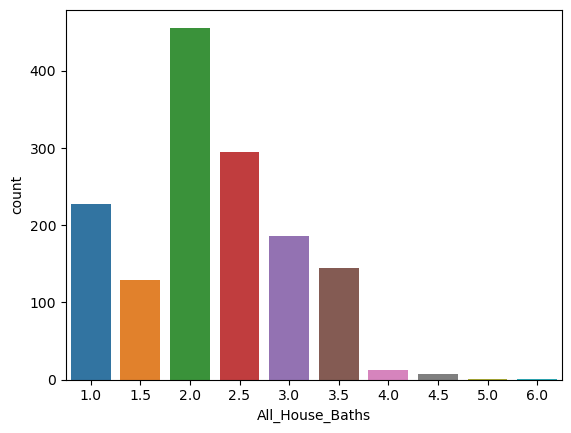

In [133]:
sns.countplot(x='All_House_Baths', data = HS)

###### Cleaning:

1. As we can see the All_House_Bath values of 4.5, 5.0, and 6.0 are all underreprestend. Instead of putting these all into the 4.0, which they would logically be closest to, I will creat a new cateogry called 4 or more. Because the sum of the baths for the underrepresented values is only 9, I have to pull the 4 into it as well.

In [134]:
HS.loc[HS.All_House_Baths == 4.0, 'All_House_Baths'] = '4 or more'
HS.loc[HS.All_House_Baths == 4.5, 'All_House_Baths'] = '4 or more'
HS.loc[HS.All_House_Baths == 5.0, 'All_House_Baths'] = '4 or more'
HS.loc[HS.All_House_Baths == 6.0, 'All_House_Baths'] = '4 or more'
HS['All_House_Baths'].value_counts()

All_House_Baths
2.0          456
2.5          295
1.0          228
3.0          186
3.5          144
1.5          129
4 or more     22
Name: count, dtype: int64

2. There are no null values and all the house bathroom values look usual to me.

In [135]:
HS[HS.All_House_Baths.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,GarageArea_trans,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st,Prop_of_SF_on_1st_Trans,Prop_of_SF_on_1st_std,House_Full_Baths,House_Half_Baths,All_House_Baths


### 6) Cleaning Neighborhood

###### Exploration:

1. We check for proportions and countplot for categorical variable exploration.

In [136]:
print(HS['Neighborhood'].value_counts())
HS['Neighborhood'].value_counts(normalize = True).round(2)

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64


Neighborhood
NAmes      0.15
CollgCr    0.10
OldTown    0.08
Edwards    0.07
Somerst    0.06
Gilbert    0.05
NridgHt    0.05
Sawyer     0.05
NWAmes     0.05
SawyerW    0.04
BrkSide    0.04
Crawfor    0.03
Mitchel    0.03
NoRidge    0.03
Timber     0.03
IDOTRR     0.03
ClearCr    0.02
StoneBr    0.02
SWISU      0.02
MeadowV    0.01
Blmngtn    0.01
BrDale     0.01
Veenker    0.01
NPkVill    0.01
Blueste    0.00
Name: proportion, dtype: float64

<Axes: xlabel='Neighborhood', ylabel='count'>

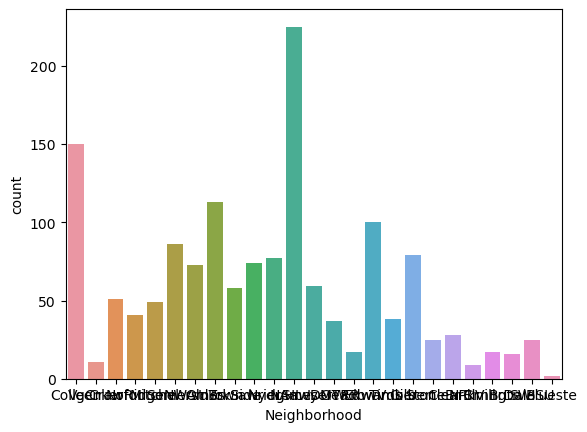

In [137]:
sns.countplot(x='Neighborhood', data = HS)

###### Cleaning:

1. We can see NPkVill with 9 and Blueste with 2 values are underepresented value counts so we have to clean them. First I will check and see which out of three relvenant variables are they closest to in their measures of central tendenacies.

In [138]:
HS.groupby('Neighborhood')[["SalePrice", "OverallQual"]].agg([np.mean, np.median])

SalePrice           OverallQual       
                       mean    median        mean median
Neighborhood                                            
Blmngtn       194870.882353  191000.0    7.176471    7.0
Blueste       137500.000000  137500.0    6.000000    6.0
BrDale        104493.750000  106000.0    5.687500    6.0
BrkSide       124834.051724  124300.0    5.051724    5.0
ClearCr       212565.428571  200250.0    5.892857    6.0
CollgCr       197404.171331  197200.0    6.640000    7.0
Crawfor       210624.725490  200624.0    6.274510    6.0
Edwards       128219.700000  121750.0    5.080000    5.0
Gilbert       192854.506329  181000.0    6.556962    7.0
IDOTRR        100123.783784  103000.0    4.756757    5.0
MeadowV        98576.470588   88000.0    4.470588    4.0
Mitchel       156270.122449  153500.0    5.591837    5.0
NAmes         145847.080000  140000.0    5.360000    5.0
NPkVill       142694.444444  146000.0    6.000000    6.0
NWAmes        189050.068493  182900.0    6.328767    6.0
NoRidge       315991.263031  301500.0    7.926829    8.0
NridgHt       317364.146669  315000.0    8.259740    8.0
OldTown       126225.023822  119000.0    5.389381    5.0
SWISU         142591.360000  139500.0    5.440000    6.0
Sawyer        136793.135135  135000.0    5.027027    5.0
SawyerW       186555.796610  179900.0    6.322034    6.0
Somerst       224875.240584  225500.0    7.337209    7.0
StoneBr       276759.652914  278000.0    8.160000    8.0
Timber        242247.447368  228475.0    7.157895    7.5
Veenker       238772.727273  218000.0    6.727273    6.0

2. Despite a lack of similarity in LotArea, both NPkVill and Blueste are quite similar to the SWISU neighborhood in Sale Price and OverallQuall. If the model does not work well or the correlation is week I could try and find one that is closer in LotArea and see if that helps.

In [139]:
HS.loc[HS.Neighborhood == 'Blueste', 'Neighborhood'] = 'SWISU'
HS.loc[HS.Neighborhood == 'NPkVill', 'Neighborhood'] = 'SWISU'
HS['Neighborhood'].value_counts()

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
SWISU       36
ClearCr     28
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
Name: count, dtype: int64

3. There are no null values and all the neighborhoods look usual to me.

In [140]:
HS[HS.Neighborhood.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,GarageArea_trans,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st,Prop_of_SF_on_1st_Trans,Prop_of_SF_on_1st_std,House_Full_Baths,House_Half_Baths,All_House_Baths


### 7) Cleaning GarageQual

###### Exploration:

1. We check for proportions and countplot for categorical variable exploration.

In [141]:
print(HS['GarageQual'].value_counts())
HS['GarageQual'].value_counts(normalize = True).round(2)

GarageQual
TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: count, dtype: int64


GarageQual
TA    0.95
Fa    0.03
Gd    0.01
Ex    0.00
Po    0.00
Name: proportion, dtype: float64

<Axes: xlabel='GarageQual', ylabel='count'>

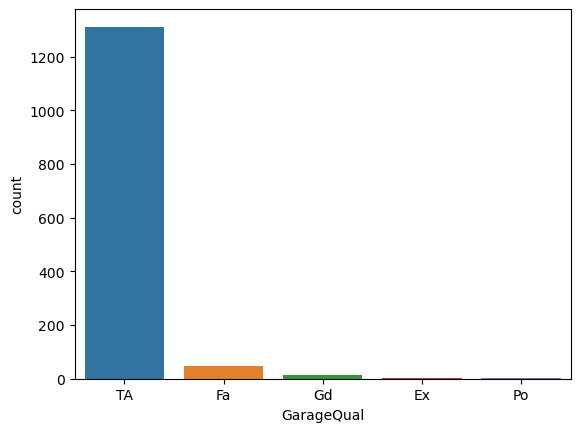

In [142]:
sns.countplot(x='GarageQual', data = HS)

###### Cleaning:

1. As we can see Ex and Po are underrepresented values that need to be cleaned.

In [143]:
print(House_Sales.groupby('GarageQual')[["SalePrice", "OverallQual"]].agg([np.mean, np.median]))

                SalePrice           OverallQual       
                     mean    median        mean median
GarageQual                                            
Ex          241000.000000  127500.0    7.000000    6.0
Fa          123573.354167  115000.0    5.166667    5.0
Gd          215860.714286  209115.0    6.714286    6.5
Po          100166.666667   96500.0    5.333333    5.0
TA          187489.836003  170000.0    6.218917    6.0


2. Ex and GD are the most similar by overallqual and SalePrice so I will replace the Ex GarageQual values with GD, and for Po I will put them into FA as it is the most similar to that one.

In [144]:
HS.loc[HS.GarageQual == 'Ex', 'GarageQual'] = 'Gd'
HS.loc[HS.GarageQual == 'Po', 'GarageQual'] = 'Fa'
HS['GarageQual'].value_counts()

GarageQual
TA    1311
Fa      51
Gd      17
Name: count, dtype: int64

3. Now to replace any null values.

In [145]:
HS[HS.GarageQual.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,GarageArea_trans,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st,Prop_of_SF_on_1st_Trans,Prop_of_SF_on_1st_std,House_Full_Baths,House_Half_Baths,All_House_Baths
39,82000.0,0.0,1152,4,0,0,2,0,Edwards,NaN,...,-1.095068,1152.0,46.238209,-2.196089,1.000000,0.000000,2.968750,2,0.0,2.0
48,113000.0,0.0,736,4,0,0,2,0,OldTown,NaN,...,-1.095068,2188.0,61.726714,-0.428053,0.336380,-1.493646,-1.376666,2,0.0,2.0
78,136500.0,0.0,1768,4,0,0,2,0,Sawyer,NaN,...,-1.095068,3536.0,76.469055,1.254806,0.500000,-0.844289,0.512488,2,0.0,2.0
88,85000.0,0.0,1013,3,0,0,1,0,IDOTRR,NaN,...,-1.095068,2539.0,65.974133,0.056796,0.398976,-1.196584,-0.512434,1,0.0,1.0
89,123600.0,0.0,990,4,1,0,1,0,CollgCr,NaN,...,-1.095068,1980.0,59.024292,-0.736539,0.500000,-0.844289,0.512488,2,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,122000.0,0.0,938,8,0,0,2,0,OldTown,NaN,...,-1.095068,3042.0,71.514752,0.689266,0.308350,-1.656207,-1.849602,2,0.0,2.0
1407,112000.0,0.0,833,5,1,0,1,0,Mitchel,NaN,...,-1.095068,1666.0,54.619056,-1.239403,0.500000,-0.844289,0.512488,2,0.0,2.0
1449,92000.0,0.0,630,5,1,0,1,0,MeadowV,NaN,...,-1.095068,1260.0,48.152935,-1.977520,0.500000,-0.844289,0.512488,2,0.0,2.0
1450,136000.0,0.0,896,5,0,0,2,2,NAmes,NaN,...,-1.095068,2688.0,67.675820,0.251046,0.333333,-1.510284,-1.425070,2,1.0,3.0


4. We can see that when there are 81 cases of NaN values for GarageQual. For each of these NaNs for GarageQual the GarageArea corresponding is also 0, this means that there is no garage and because of that I will replace NaN values with 'No Garage'.

In [146]:
HS['GarageQual'] = HS['GarageQual'].fillna('No Garage')

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/1372852204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['GarageQual'] = HS['GarageQual'].fillna('No Garage')


In [147]:
HS[HS.GarageQual.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,GarageArea_trans,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st,Prop_of_SF_on_1st_Trans,Prop_of_SF_on_1st_std,House_Full_Baths,House_Half_Baths,All_House_Baths


In [148]:
HS.iloc[39,:]

SalePrice                    82000.0
GarageArea                       0.0
1stFlrSF                        1152
OverallQual                        4
BsmtFullBath                       0
BsmtHalfBath                       0
FullBath                           2
HalfBath                           0
Neighborhood                 Edwards
GarageQual                 No Garage
YearRemodAdd                    1955
TotRmsAbvGrd                       6
MasVnrArea                       0.0
MasVnrType                       NaN
OpenPorchSF                        0
Exterior1st                  AsbShng
MSSubClass                        90
LotShape                         Reg
TotalBsmtSF                        0
YearBuilt                       1955
Foundation                     PConc
PoolQC                           NaN
FireplaceQu                      NaN
KitchenQual                       Fa
ExterQual                         TA
Fence                            NaN
GarageFinish                     NaN
G

5. Now that we checked that the null values have been fixed and all underrepresented values are set we can move on.

### 8) Cleaning HeatingQC

###### Exploration:

We check for proportions and countplot for categorical variable exploration.

In [149]:
print(HS['HeatingQC'].value_counts())
HS['HeatingQC'].value_counts(normalize = True).round(2)

HeatingQC
Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: count, dtype: int64


HeatingQC
Ex    0.51
TA    0.29
Gd    0.17
Fa    0.03
Po    0.00
Name: proportion, dtype: float64

<Axes: xlabel='HeatingQC', ylabel='count'>

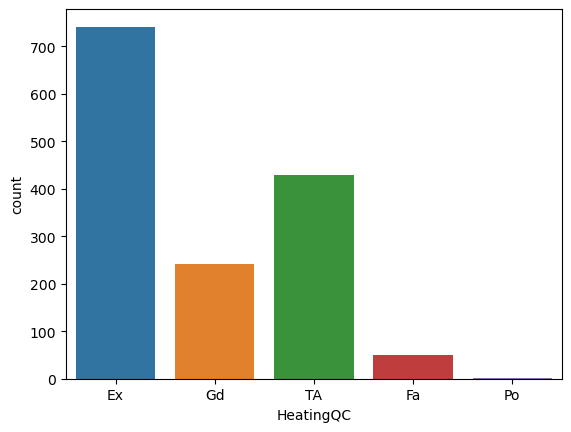

In [150]:
sns.countplot(x='HeatingQC', data = HS)

###### Cleaning:

1. There are underrepresented values to be cleaned.

In [151]:
HS.groupby('HeatingQC')["SalePrice"].agg([np.mean, np.median])

,mean,median
HeatingQC,,
Ex,212344.367723,194700.0
Fa,123919.489796,123500.0
Gd,156858.871369,152000.0
Po,87000.000000,87000.0
TA,142362.876168,135000.0


2. I will put Po into the Fa variable as it is the closest in mean and median SalePrice.

In [152]:
HS.loc[HS.HeatingQC == 'Po', 'HeatingQC'] = 'Fa'

In [153]:
HS[HS.HeatingQC.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,GarageArea_trans,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st,Prop_of_SF_on_1st_Trans,Prop_of_SF_on_1st_std,House_Full_Baths,House_Half_Baths,All_House_Baths


### 9) Cleaning FireplaceQu

###### Exploration:

1. We check for proportions and countplot for categorical variable exploration.

In [154]:
print(HS['FireplaceQu'].value_counts())
HS['FireplaceQu'].value_counts(normalize = True).round(2)

FireplaceQu
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64


FireplaceQu
Gd    0.49
TA    0.41
Fa    0.04
Ex    0.03
Po    0.03
Name: proportion, dtype: float64

<Axes: xlabel='FireplaceQu', ylabel='count'>

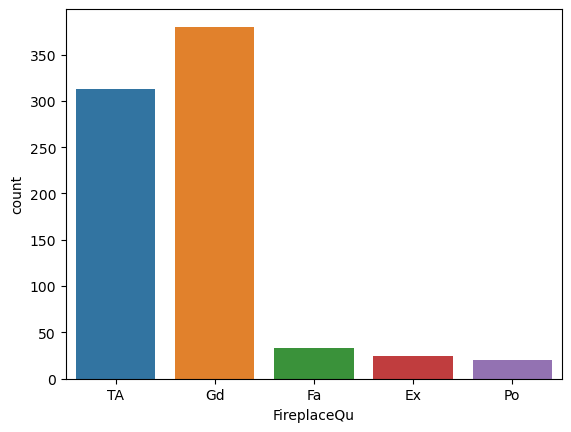

In [155]:
sns.countplot(x='FireplaceQu', data = HS)

###### Cleaning:

3. There are no null values and all the neighborhoods look usual to me.

In [156]:
HS[HS.FireplaceQu.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,GarageArea_trans,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st,Prop_of_SF_on_1st_Trans,Prop_of_SF_on_1st_std,House_Full_Baths,House_Half_Baths,All_House_Baths
0,208500.0,548.0,856,7,1,0,2,1,CollgCr,TA,...,150.663052,2566.0,66.286623,0.092467,0.333593,-1.508856,-1.420916,3,0.5,3.5
5,143000.0,480.0,796,5,1,0,1,1,Mitchel,TA,...,136.265519,2158.0,61.346236,-0.471485,0.368860,-1.329731,-0.899794,2,0.5,2.5
10,129500.0,384.0,1040,5,1,0,1,0,Sawyer,TA,...,115.033048,2080.0,60.342697,-0.586041,0.500000,-0.844289,0.512488,2,0.0,2.0
12,144000.0,352.0,912,5,1,0,1,0,Sawyer,TA,...,107.671665,1824.0,56.889672,-0.980209,0.500000,-0.844289,0.512488,2,0.0,2.0
15,132000.0,576.0,854,7,0,0,1,0,BrkSide,TA,...,156.460147,1686.0,54.913054,-1.205842,0.506524,-0.825355,0.567572,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,145000.0,525.0,1072,5,1,0,1,0,Edwards,TA,...,145.845885,1619.0,53.920166,-1.319182,0.662137,-0.462927,1.621971,2,0.0,2.0
1453,84500.0,0.0,1140,5,0,0,1,0,Mitchel,No Garage,...,-1.095068,2280.0,62.875362,-0.296933,0.500000,-0.844289,0.512488,1,0.0,1.0
1454,185000.0,400.0,1221,7,1,0,2,0,Somerst,TA,...,118.656089,2442.0,64.835622,-0.073167,0.500000,-0.844289,0.512488,3,0.0,3.0
1458,142125.0,240.0,1078,5,1,0,1,0,NAmes,TA,...,80.425157,2156.0,61.320764,-0.474393,0.500000,-0.844289,0.512488,2,0.0,2.0


In [157]:
HS['FireplaceQu'] = HS['FireplaceQu'].fillna('No Fireplace')

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/1433177082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['FireplaceQu'] = HS['FireplaceQu'].fillna('No Fireplace')


In [158]:
print(HS['FireplaceQu'].value_counts())

FireplaceQu
No Fireplace    690
Gd              380
TA              313
Fa               33
Ex               24
Po               20
Name: count, dtype: int64


### 10) Cleaning Electrical

###### Exploration:

We check for proportions and countplot for categorical variable exploration.

In [159]:
print(HS['Electrical'].value_counts())
HS['Electrical'].value_counts(normalize = True).round(2)

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64


Electrical
SBrkr    0.91
FuseA    0.06
FuseF    0.02
FuseP    0.00
Mix      0.00
Name: proportion, dtype: float64

<Axes: xlabel='Electrical', ylabel='count'>

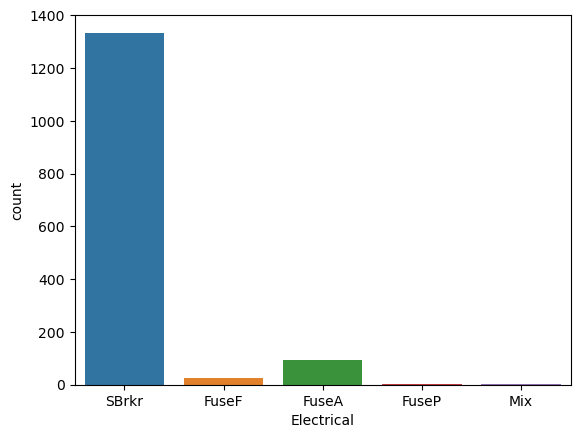

In [160]:
sns.countplot(x='Electrical', data = HS)

###### Cleaning:

1. There are underrepresented values to clean.

In [161]:
HS.groupby('Electrical')["SalePrice"].agg([np.mean, np.median])

,mean,median
Electrical,,
FuseA,122196.893617,121250.0
FuseF,107675.444444,115000.0
FuseP,97333.333333,82000.0
Mix,67000.000000,67000.0
SBrkr,185397.515354,170000.0


2. I will put both Mix and FuseP into FuseF as it is the closest in mean SalePrice.

In [162]:
HS.loc[HS.Electrical == 'Mix', 'Electrical'] = 'FuseF'
HS.loc[HS.Electrical == 'FuseP', 'Electrical'] = 'FuseF'

In [163]:
HS[HS.Electrical.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,GarageArea_trans,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st,Prop_of_SF_on_1st_Trans,Prop_of_SF_on_1st_std,House_Full_Baths,House_Half_Baths,All_House_Baths
1379,167500.0,400.0,754,5,0,0,2,1,Timber,TA,...,118.656089,1778.0,56.240551,-1.054307,0.424072,-1.097003,-0.222727,2,0.5,2.5


I will fill the null with the highest value count which is SBrkr

In [164]:
HS['Electrical'] = HS['Electrical'].fillna('SBrkr')

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/502934122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['Electrical'] = HS['Electrical'].fillna('SBrkr')


In [165]:
print(HS['Electrical'].value_counts())
HS['Electrical'].value_counts(normalize = True).round(2)

Electrical
SBrkr    1335
FuseA      94
FuseF      31
Name: count, dtype: int64


Electrical
SBrkr    0.91
FuseA    0.06
FuseF    0.02
Name: proportion, dtype: float64

### 11) Cleaning YearBuilt

Taking the maximum date and subtract it from all rows in the column to make it an age.

In [166]:
HS.agg(
        {
            'YearBuilt':['min','mean', 'median','max','std'],
        }).round(2)

,YearBuilt
min,1872.00
mean,1971.27
median,1973.00
max,2010.00
std,30.20


In [167]:
WU = HS['YearBuilt']

In [168]:
HS['House_Age'] = abs(WU - 2010) 

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/2910630247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['House_Age'] = abs(WU - 2010)


In [169]:
HS.agg(
        {
            'House_Age':['min','mean', 'median','max','std'],
        }).round(2)

,House_Age
min,0.00
mean,38.73
median,37.00
max,138.00
std,30.20


In [170]:
House_Age_mean = HS['House_Age'].mean()
House_Age_std = HS['House_Age'].std()

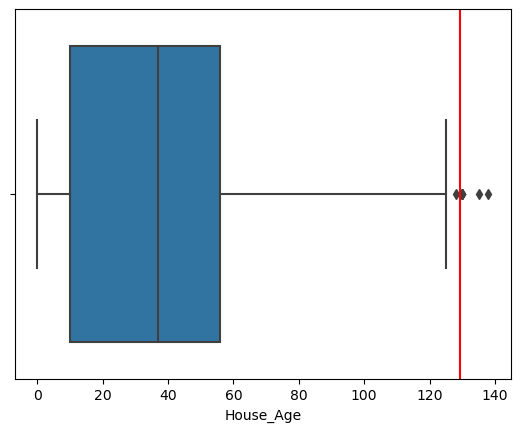

In [171]:
x = sns.boxplot(x='House_Age', data = HS)
x = x.axvline(House_Age_mean + 3* House_Age_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

<Axes: xlabel='House_Age', ylabel='Density'>

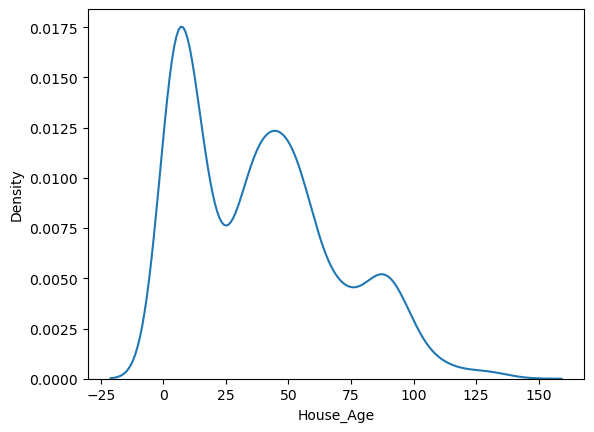

In [172]:
sns.kdeplot(x='House_Age', data = HS)

###### Cleaning:

1. There are outliers, however, they do not look to extreme so I am going to leave them in to allow for some stronger variance. The data does not follow a normal distribution, so I will use a boxcox to help.

In [173]:
HS[HS['House_Age'].isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,TotalSqFt,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st,Prop_of_SF_on_1st_Trans,Prop_of_SF_on_1st_std,House_Full_Baths,House_Half_Baths,All_House_Baths,House_Age


###### I had issues with my VIF so I came back up to bin the house ages, make it a categorical, in order to get my VIF below 10.

In [174]:
bins = [0, 15, 30, 60, 140]

In [175]:
HS['House_Age_bin'] = pd.cut(HS['House_Age'], bins)
HS.head()

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/340863649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['House_Age_bin'] = pd.cut(HS['House_Age'], bins)


,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,TotalSqFt_Trans,TotalSqFt_std,Prop_of_SF_on_1st,Prop_of_SF_on_1st_Trans,Prop_of_SF_on_1st_std,House_Full_Baths,House_Half_Baths,All_House_Baths,House_Age,House_Age_bin
0,208500.0,548.0,856,7,1,0,2,1,CollgCr,TA,...,66.286623,0.092467,0.333593,-1.508856,-1.420916,3,0.5,3.5,7,"(0, 15]"
1,181500.0,460.0,1262,6,0,1,2,0,Veenker,TA,...,65.799711,0.036885,0.500000,-0.844289,0.512488,2,0.5,2.5,34,"(30, 60]"
2,223500.0,608.0,920,7,1,0,2,1,CollgCr,TA,...,67.877727,0.274094,0.339985,-1.474260,-1.320269,3,0.5,3.5,9,"(0, 15]"
3,140000.0,642.0,961,7,1,0,1,0,Crawfor,TA,...,65.202227,-0.031318,0.388597,-1.240660,-0.640663,2,0.0,2.0,95,"(60, 140]"
4,250000.0,836.0,1145,8,1,0,2,1,NoRidge,TA,...,74.583435,1.039560,0.342507,-1.460890,-1.281370,3,0.5,3.5,10,"(0, 15]"


In [176]:
print(HS['House_Age_bin'].value_counts())
HS['House_Age_bin'].value_counts(normalize = True).round(2)

House_Age_bin
(30, 60]     530
(0, 15]      484
(60, 140]    318
(15, 30]     127
Name: count, dtype: int64


House_Age_bin
(30, 60]     0.36
(0, 15]      0.33
(60, 140]    0.22
(15, 30]     0.09
Name: proportion, dtype: float64

### 12) Cleaning YearRemodAdd

Take max remodall age, and exactly like house age, subtract it from all the others and make it an age.

In [177]:
HS.agg(
        {
            'YearRemodAdd':['min','mean', 'median','max','std'],
        }).round(2)

,YearRemodAdd
min,1950.00
mean,1984.87
median,1994.00
max,2010.00
std,20.65


In [178]:
WT = HS['YearRemodAdd']

In [179]:
HS['Last_Remod'] = abs(WT - 2010) 

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/498232004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['Last_Remod'] = abs(WT - 2010)


In [180]:
HS.agg(
        {
            'Last_Remod':['min','mean', 'median','max','std'],
        }).round(2)

,Last_Remod
min,0.00
mean,25.13
median,16.00
max,60.00
std,20.65


In [181]:
Last_Remod_mean = HS['Last_Remod'].mean()
Last_Remod_std = HS['Last_Remod'].std()

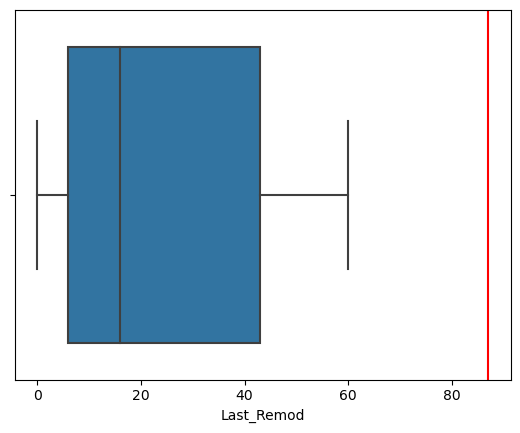

In [182]:
x = sns.boxplot(x='Last_Remod', data = HS)
x = x.axvline(Last_Remod_mean + 3* Last_Remod_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

<Axes: xlabel='Last_Remod', ylabel='Density'>

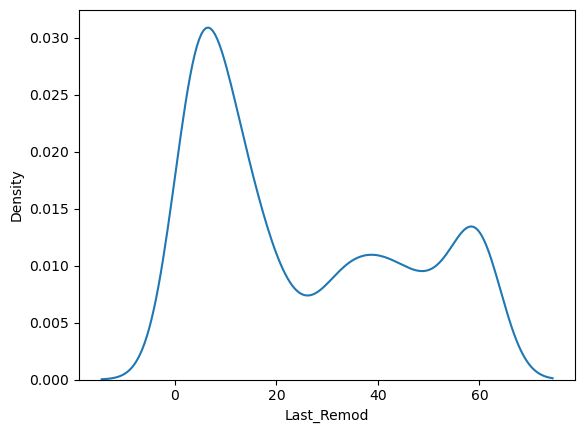

In [183]:
sns.kdeplot(x='Last_Remod', data = HS)

###### Cleaning:

There are no outliers however the data does not follow a normal distribution, so I will use a boxcox to help.

In [184]:
HS[HS['Last_Remod'].isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,TotalSqFt_std,Prop_of_SF_on_1st,Prop_of_SF_on_1st_Trans,Prop_of_SF_on_1st_std,House_Full_Baths,House_Half_Baths,All_House_Baths,House_Age,House_Age_bin,Last_Remod


In [185]:
Last_Remod_transformed, best_lambda = boxcox(HS['Last_Remod']+0.1) 
HS['Last_Remod_transformed'] = Last_Remod_transformed

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/3386399794.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['Last_Remod_transformed'] = Last_Remod_transformed


Now that the data is cleaned and bests follows a normal distribution, I will save the standard deviation values (z-scores) for each individual value to help me in the future.

In [186]:
scaler = StandardScaler()
HS["Last_Remod_std"] = scaler.fit_transform(HS[['Last_Remod_transformed']])
HS[["Last_Remod_std", 'Last_Remod_transformed',"Last_Remod"]].head(5)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/1672941990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["Last_Remod_std"] = scaler.fit_transform(HS[['Last_Remod_transformed']])


,Last_Remod_std,Last_Remod_transformed,Last_Remod
0,-0.809979,2.572466,7
1,0.664781,5.851622,34
2,-0.708415,2.798296,8
3,0.855158,6.274929,40
4,-0.530152,3.194668,10


### 13) Cleaning MasVnrArea

In [187]:
HS.agg(
        {
            'MasVnrArea':['min','mean', 'median','max','std'],
        }).round(2)

,MasVnrArea
min,0.00
mean,103.69
median,0.00
max,1600.00
std,181.07


In [188]:
MasVnrArea_mean = HS['MasVnrArea'].mean()
MasVnrArea_std = HS['MasVnrArea'].std()

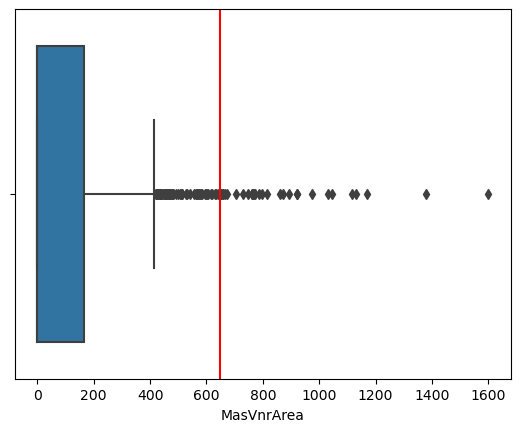

In [189]:
x = sns.boxplot(x='MasVnrArea', data = HS)
x = x.axvline(MasVnrArea_mean + 3* MasVnrArea_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

We have to clean the outliers, I will do this by MasVnrType

In [190]:
len((HS[HS['MasVnrArea'] > MasVnrArea_mean + 3* MasVnrArea_std]))

32

In [191]:
HS['MasVnrType'].value_counts()

MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

1. BrkFace:

In [192]:
BrkFace_MasVnrArea_mean = HS[(HS.MasVnrType == "BrkFace") &
                               (HS.MasVnrArea < MasVnrArea_mean + 3* MasVnrArea_std)]["MasVnrArea"].mean()
BrkFace_MasVnrArea_mean

220.4964200477327

In [193]:
BrkFace_MasVnrArea_std = HS[(HS.MasVnrType == "BrkFace") &
                               (HS.MasVnrArea < MasVnrArea_mean + 3* MasVnrArea_std)]["MasVnrArea"].std()
BrkFace_MasVnrArea_std

141.6932864582675

In [194]:
BrkFace_MasVnrArea_Replace = BrkFace_MasVnrArea_mean + 3 * BrkFace_MasVnrArea_std

In [195]:
HS.loc[(HS.MasVnrArea > MasVnrArea_mean + 3* MasVnrArea_std) & 
       (HS.MasVnrType == "BrkFace"), "MasVnrArea"] = BrkFace_MasVnrArea_Replace 

2. Stone:

In [196]:
Stone_MasVnrArea_mean = HS[(HS.MasVnrType == "Stone") &
                               (HS.MasVnrArea < MasVnrArea_mean + 3* MasVnrArea_std)]["MasVnrArea"].mean()
Stone_MasVnrArea_mean

212.4344262295082

In [197]:
Stone_MasVnrArea_std = HS[(HS.MasVnrType == "Stone") &
                               (HS.MasVnrArea < MasVnrArea_mean + 3* MasVnrArea_std)]["MasVnrArea"].std()
Stone_MasVnrArea_std

124.49527772948174

In [198]:
MasVnrArea_Replace_Stone = Stone_MasVnrArea_mean + 3 * Stone_MasVnrArea_std

In [199]:
HS.loc[(HS.MasVnrArea > Stone_MasVnrArea_mean + 3* Stone_MasVnrArea_std) & 
       (HS.MasVnrType == "Stone"), "MasVnrArea"] = MasVnrArea_Replace_Stone 

3. BrkCmn

In [200]:
BrkCmn_MasVnrArea_mean = HS[(HS.MasVnrType == "BrkCmn") &
                               (HS.MasVnrArea < MasVnrArea_mean + 3* MasVnrArea_std)]["MasVnrArea"].mean()
BrkCmn_MasVnrArea_mean

247.66666666666666

In [201]:
BrkCmn_MasVnrArea_std = HS[(HS.MasVnrType == "BrkCmn") &
                               (HS.MasVnrArea < MasVnrArea_mean + 3* MasVnrArea_std)]["MasVnrArea"].std()
BrkCmn_MasVnrArea_std

182.42323891225615

In [202]:
BrkCmn_Replace_Stone = BrkCmn_MasVnrArea_mean + 3 * BrkCmn_MasVnrArea_std

In [203]:
HS.loc[(HS.MasVnrArea > BrkCmn_MasVnrArea_mean + 3* BrkCmn_MasVnrArea_std) & 
       (HS.MasVnrType == "BrkCmn"), "MasVnrArea"] = BrkCmn_Replace_Stone 

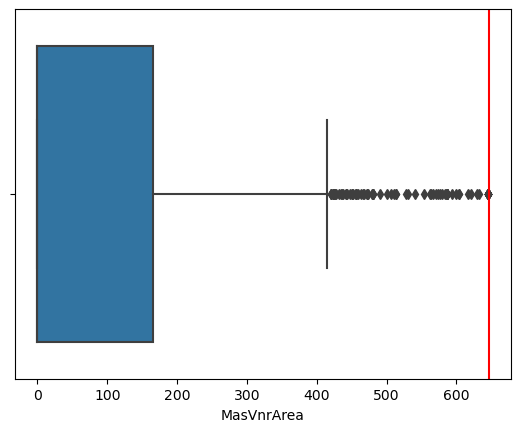

In [204]:
x = sns.boxplot(x='MasVnrArea', data = HS)
x = x.axvline(MasVnrArea_mean + 3* MasVnrArea_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

In [205]:
len((HS[HS['MasVnrArea'] > MasVnrArea_mean + 3* MasVnrArea_std]))

0

The plot is skewed to the right so I will apply a boxcox and standardize the variable.

<Axes: xlabel='MasVnrArea', ylabel='Density'>

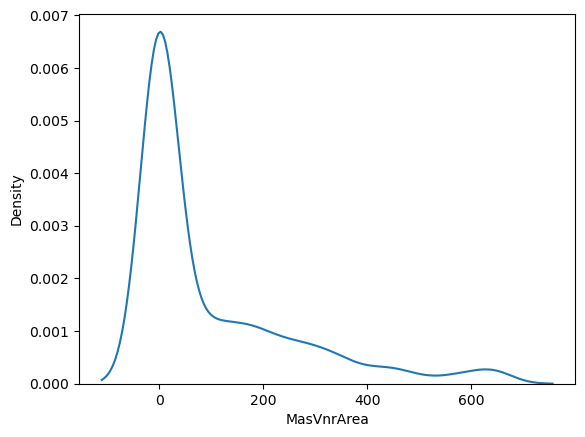

In [206]:
sns.kdeplot(x='MasVnrArea', data = HS)

In [207]:
HS[HS['MasVnrArea'].isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,Prop_of_SF_on_1st_Trans,Prop_of_SF_on_1st_std,House_Full_Baths,House_Half_Baths,All_House_Baths,House_Age,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std
234,216500.000000,440.0,860,6,1,0,2,1,Gilbert,TA,...,-1.677396,-1.911245,3,0.5,3.5,8,"(0, 15]",8,2.798296,-0.708415
529,200624.000000,484.0,2515,6,1,0,3,0,Crawfor,TA,...,-0.701281,0.928535,4,0.0,4 or more,53,"(30, 60]",35,5.925781,0.698133
650,205950.000000,562.0,822,7,0,0,2,1,Somerst,TA,...,-1.519194,-1.450992,2,0.5,2.5,3,"(0, 15]",3,1.320007,-1.373257
936,184900.000000,555.0,1200,7,1,0,2,0,SawyerW,TA,...,-0.829599,0.555225,3,0.0,3.0,7,"(0, 15]",7,2.572466,-0.809979
973,182000.000000,480.0,1428,7,0,0,2,0,Somerst,TA,...,-0.844289,0.512488,2,0.0,2.0,3,"(0, 15]",2,0.820178,-1.598049
977,199900.000000,569.0,1241,7,1,0,1,1,Somerst,TA,...,-0.844289,0.512488,2,0.5,2.5,4,"(0, 15]",3,1.320007,-1.373257
1243,498515.629354,850.0,2076,10,1,0,2,1,NridgHt,TA,...,-0.844289,0.512488,3,0.5,3.5,4,"(0, 15]",4,1.712112,-1.196913
1278,237000.000000,577.0,1128,8,1,0,2,1,CollgCr,TA,...,-1.386526,-1.065027,3,0.5,3.5,8,"(0, 15]",8,2.798296,-0.708415


All cases of MasVnrArea also do not have a MasVnrType therefore I assume the do not have a MasVnr so I will replace nulls with the value 0.

In [208]:
HS['MasVnrArea'] = HS['MasVnrArea'].fillna(0)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/3204414490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['MasVnrArea'] = HS['MasVnrArea'].fillna(0)


The data does not follow a normal distribution, so I will use a boxcox to help.

In [209]:
MasVnrArea_transformed, best_lambda = boxcox(HS['MasVnrArea']+0.1) 
HS['MasVnrArea_transformed'] = MasVnrArea_transformed

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/721426267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['MasVnrArea_transformed'] = MasVnrArea_transformed


4. Now that the data is cleaned and bests follows a normal distribution, I will save the standard deviation values (z-scores) for each individual value to help me in the future.

In [210]:
scaler = StandardScaler()
HS["MasVnrArea_std"] = scaler.fit_transform(HS[['MasVnrArea_transformed']])
HS[["MasVnrArea_std", 'MasVnrArea_transformed',"MasVnrArea"]].head(5)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/435760192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["MasVnrArea_std"] = scaler.fit_transform(HS[['MasVnrArea_transformed']])


,MasVnrArea_std,MasVnrArea_transformed,MasVnrArea
0,1.225873,3.538953,196.0
1,-0.821747,-2.794658,0.0
2,1.199444,3.457202,162.0
3,-0.821747,-2.794658,0.0
4,1.301450,3.772725,350.0


We have to clean the outliers, I will do this by MasVnrType

In [211]:
len((HS[HS['MasVnrArea'] > MasVnrArea_mean + 3* MasVnrArea_std]))

0

In [212]:
HS['MasVnrType'].value_counts()

MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

### 14) Cleaning Exterior1st:

In [213]:
print(HS['Exterior1st'].value_counts())
HS['Exterior1st'].value_counts(normalize = True).round(2)

Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: count, dtype: int64


Exterior1st
VinylSd    0.35
HdBoard    0.15
MetalSd    0.15
Wd Sdng    0.14
Plywood    0.07
CemntBd    0.04
BrkFace    0.03
WdShing    0.02
Stucco     0.02
AsbShng    0.01
BrkComm    0.00
Stone      0.00
AsphShn    0.00
ImStucc    0.00
CBlock     0.00
Name: proportion, dtype: float64

<Axes: xlabel='Exterior1st', ylabel='count'>

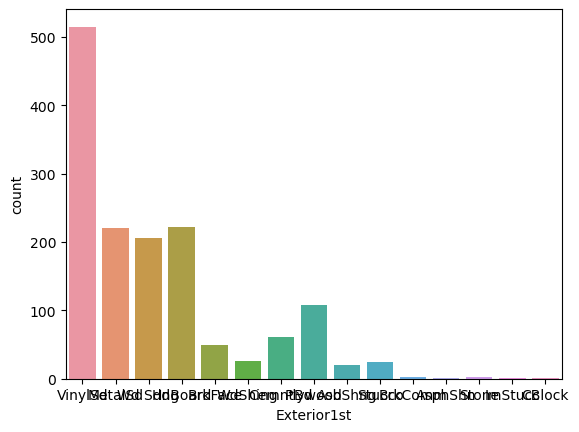

In [214]:
sns.countplot(x='Exterior1st', data = HS)

1. BrkComm, Stone, AsphShn, ImStucc and CBlock all need to be cleaned. 

In [215]:
HS.groupby('Exterior1st')[["SalePrice"]].agg([np.mean, np.median])

SalePrice          
                      mean    median
Exterior1st                         
AsbShng      107385.550000  108000.0
AsphShn      100000.000000  100000.0
BrkComm       71000.000000   71000.0
BrkFace      194893.135137  165750.0
CBlock       105000.000000  105000.0
CemntBd      225284.154428  236500.0
HdBoard      160879.313125  149900.0
ImStucc      262000.000000  262000.0
MetalSd      149422.177273  139000.0
Plywood      175942.379630  167450.0
Stone        258500.000000  258500.0
Stucco       162990.000000  144000.0
VinylSd      212729.765715  200000.0
Wd Sdng      147292.982761  138943.5
WdShing      150655.076923  128700.0

2. For BrkComm, AsphShn, and CBlock, I will replace their Exterior1st with AsbShng as this is the Exterior1st that was most consistent with the SalePrice for all of them. For Stone and ImStucc I replaced them with a differnt one, CemntBd, but for the same reason.

In [216]:
HS.loc[HS.Exterior1st == 'BrkComm', 'Exterior1st'] = 'AsbShng'
HS.loc[HS.Exterior1st == 'AsphShn', 'Exterior1st'] = 'AsbShng'
HS.loc[HS.Exterior1st == 'CBlock', 'Exterior1st'] = 'AsbShng'
HS.loc[HS.Exterior1st == 'Stone', 'Exterior1st'] = 'CemntBd'
HS.loc[HS.Exterior1st == 'ImStucc', 'Exterior1st'] = 'CemntBd'

HS['Exterior1st'].value_counts()

Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     64
BrkFace     50
WdShing     26
Stucco      25
AsbShng     24
Name: count, dtype: int64

3. Check for Nulls. 

In [217]:
HS[HS.Exterior1st.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Full_Baths,House_Half_Baths,All_House_Baths,House_Age,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std


### 15) Cleaning MSSubClass

###### Exploration:

1) We check for proportions and countplot for categorical variable exploration.

In [218]:
print(HS['MSSubClass'].value_counts())
HS['MSSubClass'].value_counts(normalize = True).round(2)

MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64


MSSubClass
20     0.37
60     0.20
50     0.10
120    0.06
30     0.05
160    0.04
70     0.04
80     0.04
90     0.04
190    0.02
85     0.01
75     0.01
45     0.01
180    0.01
40     0.00
Name: proportion, dtype: float64

<Axes: xlabel='MSSubClass', ylabel='count'>

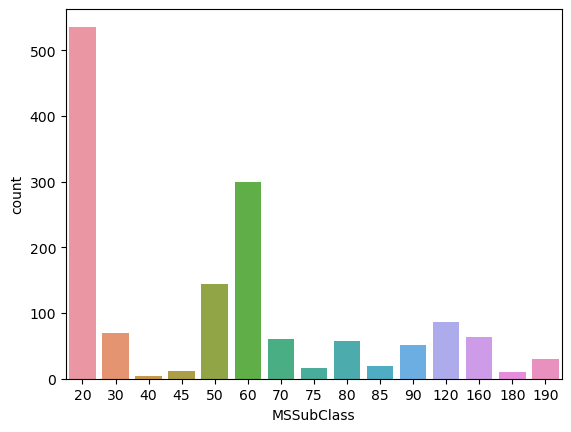

In [219]:
sns.countplot(x='MSSubClass', data = HS)

There are underrepresnted values.

###### Cleaning:

1)
We can see the 40 MSSubClass is underrepresented as the value count is less than 10. Using the original House_Sales data set, I will check MSSubClass with the indetifier of 40 with building type and house style. Because the column MSSubClass uses numeric integer codes to represent the type of building the house is, it makes sense to put the 40 representation with one that is most similar to it based on these two variables.

In [220]:
HS_MSSubClass = House_Sales.set_index("MSSubClass") #setting the index as MSSubClass

In [221]:
HS_MSSubClass.loc[ : , ["BldgType","HouseStyle"]] # Checking the 40 index against the two aforementioned variables

,BldgType,HouseStyle
MSSubClass,,
60,1Fam,2Story
20,1Fam,1Story
60,1Fam,2Story
70,1Fam,2Story
60,1Fam,2Story
...,...,...
60,1Fam,2Story
20,1Fam,1Story
70,1Fam,2Story


2. To take a closer look I am looking at just values with 40 and 20 as I noticed it looks like all their values might be 1Fam and 1Story.

In [222]:
print(House_Sales[House_Sales['MSSubClass'] == 40][['BldgType', 'HouseStyle']])
print(House_Sales[House_Sales['MSSubClass'] == 20][['BldgType', 'HouseStyle']])

     BldgType HouseStyle
164      1Fam     1Story
589      1Fam     1Story
873      1Fam     1Story
1270     1Fam     1Story
     BldgType HouseStyle
1        1Fam     1Story
6        1Fam     1Story
10       1Fam     1Story
12       1Fam     1Story
13       1Fam     1Story
...       ...        ...
1453     1Fam     1Story
1454     1Fam     1Story
1456     1Fam     1Story
1458     1Fam     1Story
1459     1Fam     1Story

[536 rows x 2 columns]


3) As the 4 values in the 40 index are all 1fam BldType and 1Story HouseStyle, which is the same for the 20 index (apart from 1), I will change all rows with the index 40 to now have the index 20

In [223]:
HS.loc[HS.MSSubClass == 40, 'MSSubClass'] = 20

4. Checking for outliers

In [224]:
HS[HS.MSSubClass.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Full_Baths,House_Half_Baths,All_House_Baths,House_Age,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std


### 16) Cleaning GarageFinish

###### Exploration:

1. We check for proportions and countplot for categorical variable exploration.

In [225]:
print(HS['GarageFinish'].value_counts())
HS['GarageFinish'].value_counts(normalize = True).round(2)

GarageFinish
Unf    605
RFn    422
Fin    352
Name: count, dtype: int64


GarageFinish
Unf    0.44
RFn    0.31
Fin    0.26
Name: proportion, dtype: float64

<Axes: xlabel='GarageFinish', ylabel='count'>

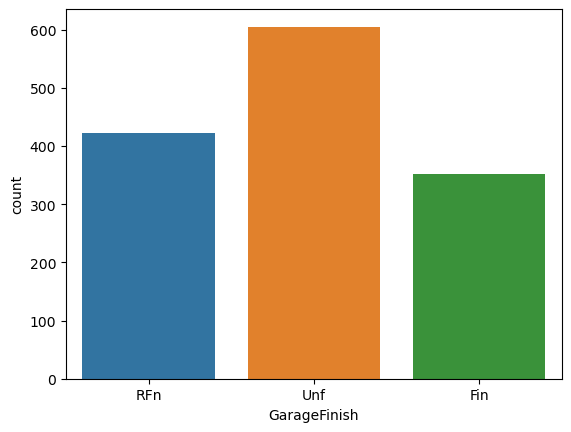

In [226]:
sns.countplot(x='GarageFinish', data = HS)

There are no underrepresented values.

###### Cleaning:

In [227]:
HS[HS.GarageFinish.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Full_Baths,House_Half_Baths,All_House_Baths,House_Age,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std
39,82000.0,0.0,1152,4,0,0,2,0,Edwards,No Garage,...,2,0.0,2.0,55,"(30, 60]",55,7.159733,1.253088,-2.794658,-0.821747
48,113000.0,0.0,736,4,0,0,2,0,OldTown,No Garage,...,2,0.0,2.0,90,"(60, 140]",2,0.820178,-1.598049,-2.794658,-0.821747
78,136500.0,0.0,1768,4,0,0,2,0,Sawyer,No Garage,...,2,0.0,2.0,42,"(30, 60]",42,6.405649,0.913947,-2.794658,-0.821747
88,85000.0,0.0,1013,3,0,0,1,0,IDOTRR,No Garage,...,1,0.0,1.0,95,"(60, 140]",28,5.369502,0.447953,-2.794658,-0.821747
89,123600.0,0.0,990,4,1,0,1,0,CollgCr,No Garage,...,2,0.0,2.0,16,"(15, 30]",15,3.979648,-0.177116,-2.794658,-0.821747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,122000.0,0.0,938,8,0,0,2,0,OldTown,No Garage,...,2,0.0,2.0,138,"(60, 140]",23,4.906009,0.239503,-2.794658,-0.821747
1407,112000.0,0.0,833,5,1,0,1,0,Mitchel,No Garage,...,2,0.0,2.0,25,"(15, 30]",25,5.099486,0.326517,-2.794658,-0.821747
1449,92000.0,0.0,630,5,1,0,1,0,MeadowV,No Garage,...,2,0.0,2.0,40,"(30, 60]",40,6.274929,0.855158,-2.794658,-0.821747
1450,136000.0,0.0,896,5,0,0,2,2,NAmes,No Garage,...,2,1.0,3.0,36,"(30, 60]",36,5.998404,0.730794,-2.794658,-0.821747


In [228]:
HS['GarageFinish'] = HS['GarageFinish'].fillna('No_Garage')

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/608046550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['GarageFinish'] = HS['GarageFinish'].fillna('No_Garage')


### 17) Cleaning TotalPorchSF

Summing all variables that are part of porch square footage to make it one variable.

In [229]:
WW = HS[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']]

In [230]:
WW.astype(int).head()

,WoodDeckSF,OpenPorchSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
0,0,61,61,0,0,0
1,298,0,0,0,0,0
2,0,42,42,0,0,0
3,0,35,35,272,0,0
4,192,84,84,0,0,0


In [231]:
HS['TotalPorchSF'] = WW[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis = 'columns')

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/1726092208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['TotalPorchSF'] = WW[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis = 'columns')


In [232]:
HS.agg(
        {
            'TotalPorchSF':['min','mean', 'median','max','std'],
        }).round(2)

,TotalPorchSF
min,0.00
mean,227.99
median,199.00
max,1574.00
std,196.11


In [233]:
TotalPorchSF_mean = HS['TotalPorchSF'].mean()
TotalPorchSF_std = HS['TotalPorchSF'].std()

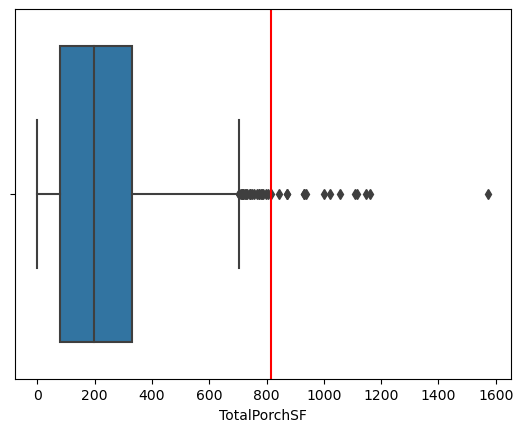

In [234]:
x = sns.boxplot(x='TotalPorchSF', data = HS)
x = x.axvline(TotalPorchSF_mean + 3* TotalPorchSF_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

We have to clean the outliers, I will do this by neighborhood

In [235]:
((HS[HS['TotalPorchSF'] > TotalPorchSF_mean + 3* TotalPorchSF_std]))

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Half_Baths,All_House_Baths,House_Age,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF
7,200000.000000,484.0,1107,7,1,0,2,1,NWAmes,TA,...,0.5,3.5,37,"(30, 60]",37,6.069565,0.762798,3.623124,1.253085,871
53,385000.000000,894.0,1842,9,2,0,0,1,Veenker,TA,...,0.5,2.5,29,"(15, 30]",23,4.906009,0.239503,-2.794658,-0.821747,1001
185,248968.691889,840.0,1518,10,0,0,2,1,OldTown,Gd,...,0.5,2.5,118,"(60, 140]",17,4.239927,-0.060059,-2.794658,-0.821747,930
495,34900.000000,0.0,720,4,0,0,1,0,IDOTRR,No Garage,...,0.0,1.0,90,"(60, 140]",60,7.414881,1.367837,-2.794658,-0.821747,1161
523,184750.000000,884.0,3138,10,1,0,3,1,Edwards,TA,...,0.5,4 or more,3,"(0, 15]",2,0.820178,-1.598049,3.962736,1.362880,1020
583,325000.000000,880.0,1521,10,0,0,3,1,OldTown,Gd,...,0.5,3.5,117,"(60, 140]",10,3.194668,-0.530152,-2.794658,-0.821747,1109
591,498515.629354,842.0,1728,10,1,0,2,1,NridgHt,TA,...,0.5,3.5,2,"(0, 15]",2,0.820178,-1.598049,3.841791,1.323779,930
854,170000.000000,454.0,1779,5,1,0,1,1,Sawyer,TA,...,0.5,2.5,55,"(30, 60]",36,5.998404,0.730794,-2.794658,-0.821747,1148
875,303477.000000,550.0,1184,8,0,0,2,1,Somerst,TA,...,0.5,2.5,3,"(0, 15]",3,1.320007,-1.373257,-2.794658,-0.821747,936
961,272000.000000,619.0,1542,6,1,0,2,1,NWAmes,TA,...,0.5,3.5,33,"(30, 60]",15,3.979648,-0.177116,3.845326,1.324922,1114


1. NWAmes:

In [236]:
NWAmes_TotalPorchSF_mean = HS[(HS.Neighborhood == "NWAmes") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].mean()
NWAmes_TotalPorchSF_mean

269.07042253521126

In [237]:
NWAmes_TotalPorchSF_std = HS[(HS.Neighborhood == "NWAmes") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].std()
NWAmes_TotalPorchSF_std

204.51184554890438

In [238]:
NWAmes_TotalPorchSF_Replace = NWAmes_TotalPorchSF_mean + 3 * NWAmes_TotalPorchSF_std

In [239]:
HS.loc[(HS.TotalPorchSF > TotalPorchSF_mean + 3* TotalPorchSF_std) & 
       (HS.Neighborhood == "NWAmes"), "TotalPorchSF"] = NWAmes_TotalPorchSF_Replace 

2. Veenker	:

In [240]:
Veenker_TotalPorchSF_mean = HS[(HS.Neighborhood == "Veenker") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].mean()
Veenker_TotalPorchSF_mean

281.9

In [241]:
Veenker_TotalPorchSF_std = HS[(HS.Neighborhood == "Veenker") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].std()
Veenker_TotalPorchSF_std

137.76021841510624

In [242]:
Veenker_TotalPorchSF_Replace = Veenker_TotalPorchSF_mean + 3 * Veenker_TotalPorchSF_std

In [243]:
HS.loc[(HS.TotalPorchSF > TotalPorchSF_mean + 3* TotalPorchSF_std) & 
       (HS.Neighborhood == "Veenker"), "TotalPorchSF"] = Veenker_TotalPorchSF_Replace 

3. OldTown:

In [244]:
OldTown_TotalPorchSF_mean = HS[(HS.Neighborhood == "OldTown") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].mean()
OldTown_TotalPorchSF_mean

210.44545454545454

In [245]:
OldTown_TotalPorchSF_std = HS[(HS.Neighborhood == "OldTown") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].std()
OldTown_TotalPorchSF_std

174.20643592760524

In [246]:
OldTown_TotalPorchSF_Replace = Veenker_TotalPorchSF_mean + 3 * Veenker_TotalPorchSF_std

In [247]:
HS.loc[(HS.TotalPorchSF > TotalPorchSF_mean + 3* TotalPorchSF_std) & 
       (HS.Neighborhood == "OldTown"), "TotalPorchSF"] = OldTown_TotalPorchSF_Replace 

4. IDOTRR:

In [248]:
IDOTRR_TotalPorchSF_mean = HS[(HS.Neighborhood == "IDOTRR") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].mean()
IDOTRR_TotalPorchSF_mean

161.97222222222223

In [249]:
IDOTRR_TotalPorchSF_std = HS[(HS.Neighborhood == "IDOTRR") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].std()
IDOTRR_TotalPorchSF_std

121.8130854127658

In [250]:
IDOTRR_TotalPorchSF_Replace = IDOTRR_TotalPorchSF_mean + 3 * IDOTRR_TotalPorchSF_std

In [251]:
HS.loc[(HS.TotalPorchSF > TotalPorchSF_mean + 3* TotalPorchSF_std) & 
       (HS.Neighborhood == "IDOTRR"), "TotalPorchSF"] = IDOTRR_TotalPorchSF_Replace 

5. Edwards:

In [252]:
Edwards_TotalPorchSF_mean = HS[(HS.Neighborhood == "Edwards") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].mean()
Edwards_TotalPorchSF_mean

155.8556701030928

In [253]:
Edwards_TotalPorchSF_std = HS[(HS.Neighborhood == "Edwards") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].std()
Edwards_TotalPorchSF_std

143.87139726815067

In [254]:
Edwards_TotalPorchSF_Replace = Edwards_TotalPorchSF_mean + 3 * Edwards_TotalPorchSF_std

In [255]:
HS.loc[(HS.TotalPorchSF > TotalPorchSF_mean + 3* TotalPorchSF_std) & 
       (HS.Neighborhood == "Edwards"), "TotalPorchSF"] = Edwards_TotalPorchSF_Replace 

6. NridgHt:

In [256]:
NridgHt_TotalPorchSF_mean = HS[(HS.Neighborhood == "NridgHt") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].mean()
NridgHt_TotalPorchSF_mean

313.75

In [257]:
NridgHt_TotalPorchSF_std = HS[(HS.Neighborhood == "NridgHt") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].std()
NridgHt_TotalPorchSF_std

170.3334083496247

In [258]:
NridgHt_TotalPorchSF_Replace = NridgHt_TotalPorchSF_mean + 3 * NridgHt_TotalPorchSF_std

In [259]:
HS.loc[(HS.TotalPorchSF > TotalPorchSF_mean + 3* TotalPorchSF_std) & 
       (HS.Neighborhood == "NridgHt"), "TotalPorchSF"] =NridgHt_TotalPorchSF_Replace 

7. Sawyer:

In [260]:
Sawyer_TotalPorchSF_mean = HS[(HS.Neighborhood == "Sawyer") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].mean()
Sawyer_TotalPorchSF_mean

169.21917808219177

In [261]:
Sawyer_TotalPorchSF_std = HS[(HS.Neighborhood == "Sawyer") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].std()
Sawyer_TotalPorchSF_std

171.36869338224324

In [262]:
Sawyer_TotalPorchSF_Replace = Sawyer_TotalPorchSF_mean + 3 * Sawyer_TotalPorchSF_std

In [263]:
HS.loc[(HS.TotalPorchSF > TotalPorchSF_mean + 3* TotalPorchSF_std) & 
       (HS.Neighborhood == "Sawyer"), "TotalPorchSF"] =Sawyer_TotalPorchSF_Replace 

8. Somerst:

In [264]:
Somerst_TotalPorchSF_mean = HS[(HS.Neighborhood == "Somerst") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].mean()
Somerst_TotalPorchSF_mean

269.16470588235296

In [265]:
Somerst_TotalPorchSF_std = HS[(HS.Neighborhood == "Somerst") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].std()
Somerst_TotalPorchSF_std

163.18298573912017

In [266]:
Somerst_TotalPorchSF_Replace = Somerst_TotalPorchSF_mean + 3 * Somerst_TotalPorchSF_std

In [267]:
HS.loc[(HS.TotalPorchSF > TotalPorchSF_mean + 3* TotalPorchSF_std) & 
       (HS.Neighborhood == "Somerst"), "TotalPorchSF"] = Somerst_TotalPorchSF_Replace 

9. SawyerW: 

In [268]:
SawyerW_TotalPorchSF_mean = HS[(HS.Neighborhood == "SawyerW") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].mean()
SawyerW_TotalPorchSF_mean

260.32758620689657

In [269]:
SawyerW_TotalPorchSF_std = HS[(HS.Neighborhood == "SawyerW") &
                               (HS.TotalPorchSF < TotalPorchSF_mean + 3* TotalPorchSF_std)]["TotalPorchSF"].std()
SawyerW_TotalPorchSF_std

181.02974340582864

In [270]:
SawyerW_TotalPorchSF_Replace = SawyerW_TotalPorchSF_mean + 3 * SawyerW_TotalPorchSF_std

In [271]:
HS.loc[(HS.TotalPorchSF > TotalPorchSF_mean + 3* TotalPorchSF_std) & 
       (HS.Neighborhood == "SawyerW"), "TotalPorchSF"] = SawyerW_TotalPorchSF_Replace 

Finally, outliers cleaned. Probably could have chose something easier than neighborhood haha.

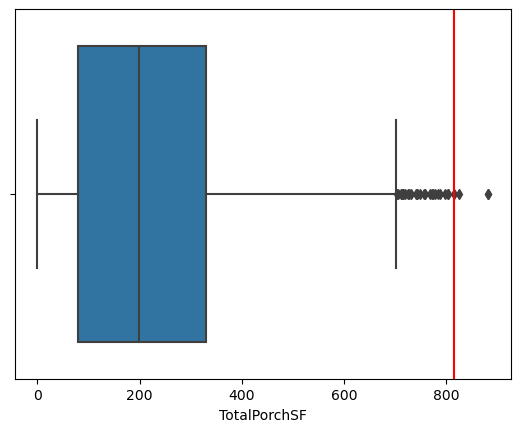

In [272]:
x = sns.boxplot(x='TotalPorchSF', data = HS)
x = x.axvline(TotalPorchSF_mean + 3* TotalPorchSF_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

<Axes: xlabel='TotalPorchSF', ylabel='Density'>

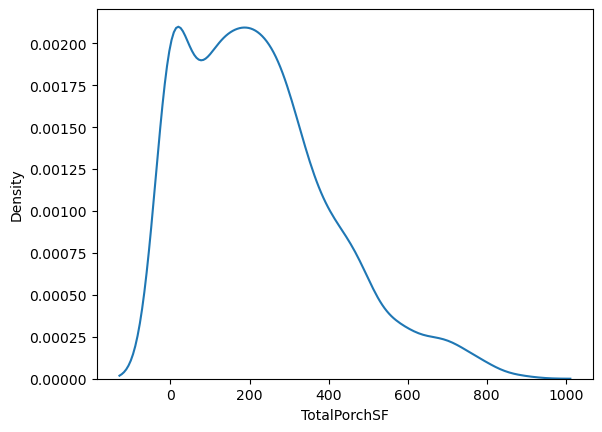

In [273]:
sns.kdeplot(x='TotalPorchSF', data = HS)

The data does not follow a normal distribution, so I will use a boxcox to help.

In [274]:
TotalPorchSF_transformed, best_lambda = boxcox(HS['TotalPorchSF']+0.1) 
HS['TotalPorchSF_transformed'] = TotalPorchSF_transformed

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/1163732470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['TotalPorchSF_transformed'] = TotalPorchSF_transformed


4. Now that the data is cleaned and bests follows a normal distribution, I will save the standard deviation values (z-scores) for each individual value to help me in the future.

In [275]:
scaler = StandardScaler()
HS["TotalPorchSF_std"] = scaler.fit_transform(HS[['TotalPorchSF_transformed']])
HS[["TotalPorchSF_std", 'TotalPorchSF_transformed',"TotalPorchSF"]].head(5)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/184738438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["TotalPorchSF_std"] = scaler.fit_transform(HS[['TotalPorchSF_transformed']])


,TotalPorchSF_std,TotalPorchSF_transformed,TotalPorchSF
0,-0.170227,14.731472,122.0
1,0.586983,22.186754,298.0
2,-0.414210,12.329276,84.0
3,0.729981,23.594677,342.0
4,0.785305,24.139379,360.0


### 18) Cleaning LotShape

###### Exploration:

1. We check for proportions and countplot for categorical variable exploration.

In [276]:
print(HS['LotShape'].value_counts())
HS['LotShape'].value_counts(normalize = True).round(2)

LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64


LotShape
Reg    0.63
IR1    0.33
IR2    0.03
IR3    0.01
Name: proportion, dtype: float64

<Axes: xlabel='LotShape', ylabel='count'>

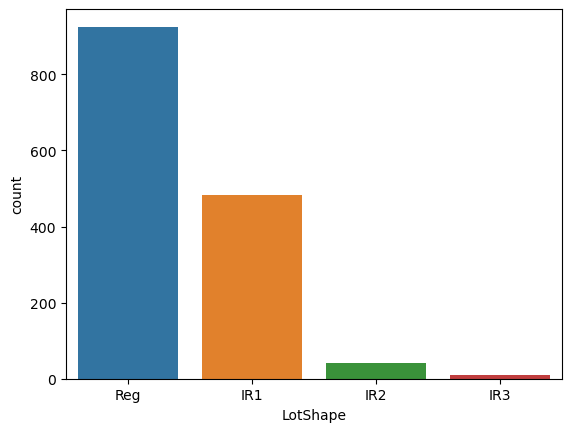

In [277]:
sns.countplot(x='LotShape', data = HS)

There are no underrepresented values.

###### Cleaning:

In [278]:
HS[HS.LotShape.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Age,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std


Do not need to clean as there are no values that are underrepresented or null.

### 19) Cleaning GarageCars

###### Exploration:

1) We check for proportions and countplot for categorical variable exploration.

In [279]:
print(HS['GarageCars'].value_counts())
HS['GarageCars'].value_counts(normalize = True).round(2)

GarageCars
2    824
1    369
3    181
0     81
4      5
Name: count, dtype: int64


GarageCars
2    0.56
1    0.25
3    0.12
0    0.06
4    0.00
Name: proportion, dtype: float64

<Axes: xlabel='GarageCars', ylabel='count'>

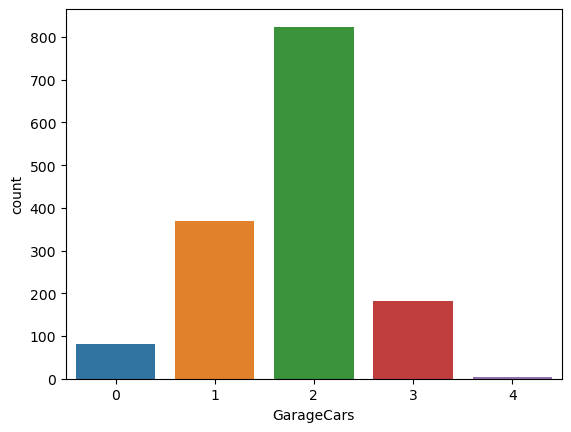

In [280]:
sns.countplot(x='GarageCars', data = HS)

There are underrepresnted values.

###### Cleaning:

1)
I will put the 4 car garages into 3.

In [281]:
HS.loc[HS.GarageCars == 4, 'GarageCars'] = 3

4. Checking for outliers

In [282]:
HS[HS.Foundation.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Age,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std


### 20) Cleaning Foundation

###### Exploration:

1) We check for proportions and countplot for categorical variable exploration.

In [283]:
print(HS['Foundation'].value_counts())
HS['Foundation'].value_counts(normalize = True).round(2)

Foundation
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: count, dtype: int64


Foundation
PConc     0.44
CBlock    0.43
BrkTil    0.10
Slab      0.02
Stone     0.00
Wood      0.00
Name: proportion, dtype: float64

<Axes: xlabel='Foundation', ylabel='count'>

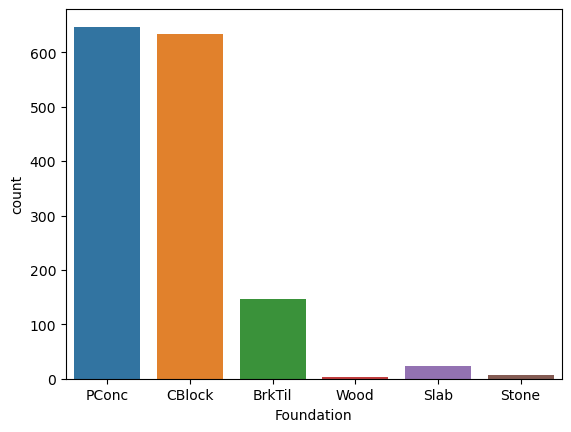

In [284]:
sns.countplot(x='Foundation', data = HS)

There are underrepresnted values.

###### Cleaning:

1)
We can see the 40 MSSubClass is underrepresented as the value count is less than 10. Using the original House_Sales data set, I will check MSSubClass with the indetifier of 40 with building type and house style. Because the column MSSubClass uses numeric integer codes to represent the type of building the house is, it makes sense to put the 40 representation with one that is most similar to it based on these two variables.

In [285]:
HS_Foundation = House_Sales.set_index("Foundation") #setting the index as Foundation

In [286]:
HS_MSSubClass.loc[ : , ["BldgType","HouseStyle"]] # Checking the 40 index against the two aforementioned variables

,BldgType,HouseStyle
MSSubClass,,
60,1Fam,2Story
20,1Fam,1Story
60,1Fam,2Story
70,1Fam,2Story
60,1Fam,2Story
...,...,...
60,1Fam,2Story
20,1Fam,1Story
70,1Fam,2Story


2. To take a closer look I am looking at just wood and stone.

In [287]:
print(House_Sales[House_Sales['Foundation'] == 'Wood'][['BldgType', 'HouseStyle']])
print(House_Sales[House_Sales['Foundation'] == 'Stone'][['BldgType', 'HouseStyle']])

     BldgType HouseStyle
5        1Fam     1.5Fin
1180     1Fam     2Story
1211     1Fam     1.5Fin
     BldgType HouseStyle
246    2fmCon     2Story
711      1Fam     1.5Fin
747      1Fam     2Story
872      1Fam     1Story
1292     1Fam     2Story
1457     1Fam     2Story


3) I can see all the building types bar one are 1fam, the house style kind of varies, I think I will replace them just into the PConc as it has the highest value count.

In [288]:
HS.loc[HS.Foundation == 'Wood', 'Foundation'] = 'PConc'

In [289]:
HS.loc[HS.Foundation == 'Stone', 'Foundation'] = 'PConc'

4. Checking for outliers

In [290]:
HS[HS.Foundation.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Age,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std


### 21) Cleaning BsmtExposure

###### Exploration:

We check for proportions and countplot for categorical variable exploration.

In [291]:
print(HS['BsmtExposure'].value_counts())
HS['BsmtExposure'].value_counts(normalize = True).round(2)

BsmtExposure
No    953
Av    221
Gd    134
Mn    114
Name: count, dtype: int64


BsmtExposure
No    0.67
Av    0.16
Gd    0.09
Mn    0.08
Name: proportion, dtype: float64

<Axes: xlabel='BsmtExposure', ylabel='count'>

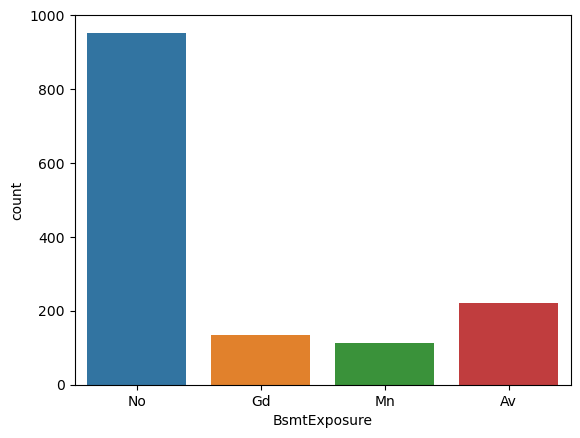

In [292]:
sns.countplot(x='BsmtExposure', data = HS)

###### Cleaning:

1. There are no underrepresented values and all the values look usual to me.

In [293]:
HS[HS.BsmtExposure.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Age,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std
17,90000.0,516.0,1296,4,0,0,2,0,Sawyer,TA,...,43,"(30, 60]",43,6.469305,0.942576,-2.794658,-0.821747,0.0,-1.500065,-1.818813
39,82000.0,0.0,1152,4,0,0,2,0,Edwards,No Garage,...,55,"(30, 60]",55,7.159733,1.253088,-2.794658,-0.821747,0.0,-1.500065,-1.818813
90,109900.0,420.0,1040,4,0,0,1,0,NAmes,TA,...,60,"(30, 60]",60,7.414881,1.367837,-2.794658,-0.821747,58.0,10.277734,-0.622579
102,118964.0,410.0,1535,5,0,0,2,0,SawyerW,TA,...,31,"(30, 60]",31,5.619112,0.560212,-2.794658,-0.821747,0.0,-1.500065,-1.818813
156,109500.0,625.0,1040,5,0,0,1,0,NAmes,TA,...,60,"(30, 60]",60,7.414881,1.367837,-2.794658,-0.821747,0.0,-1.500065,-1.818813
182,120000.0,252.0,1340,5,0,0,1,0,Edwards,TA,...,53,"(30, 60]",4,1.712112,-1.196913,3.228990,1.125664,296.0,22.119895,0.580192
259,97000.0,308.0,882,5,0,0,1,0,OldTown,TA,...,54,"(30, 60]",54,7.106680,1.229228,-2.794658,-0.821747,90.0,12.746525,-0.371832
342,87500.0,400.0,1040,3,0,0,2,0,NAmes,TA,...,61,"(60, 140]",60,7.414881,1.367837,3.761554,1.297839,0.0,-1.500065,-1.818813
362,198500.0,672.0,495,7,0,0,3,0,Edwards,TA,...,7,"(0, 15]",7,2.572466,-0.809979,3.905947,1.344520,177.0,17.515579,0.112546
371,134432.0,680.0,1120,4,0,0,2,0,ClearCr,TA,...,51,"(30, 60]",51,6.943075,1.155648,-2.794658,-0.821747,118.0,14.501873,-0.193547


In [294]:
HS['BsmtExposure'] = HS['BsmtExposure'].fillna('No_Basement')

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/654930131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['BsmtExposure'] = HS['BsmtExposure'].fillna('No_Basement')


### 22) Cleaning LotShape

###### Exploration:

1. We check for proportions and countplot for categorical variable exploration.

In [295]:
print(HS['LotShape'].value_counts())
HS['LotShape'].value_counts(normalize = True).round(2)

LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64


LotShape
Reg    0.63
IR1    0.33
IR2    0.03
IR3    0.01
Name: proportion, dtype: float64

<Axes: xlabel='LotShape', ylabel='count'>

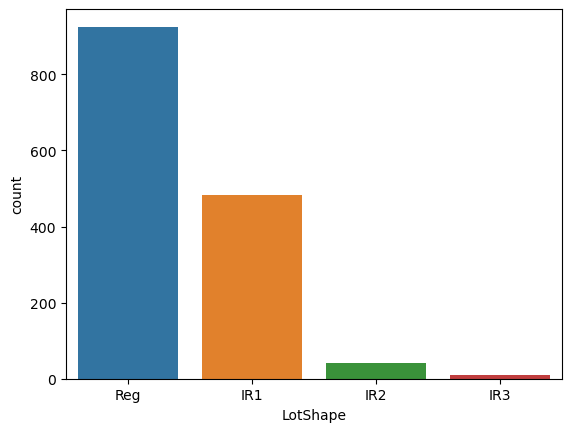

In [296]:
sns.countplot(x='LotShape', data = HS)

There are no underrepresented values.

###### Cleaning:

In [297]:
HS[HS.LotShape.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Age,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std


Do not need to clean as there are no values that are underrepresented or null.

### 23) Cleaning Fence

###### Exploration:

In [298]:
print(HS['Fence'].value_counts())
HS['Fence'].value_counts(normalize = True).round(2)

Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64


Fence
MnPrv    0.56
GdPrv    0.21
GdWo     0.19
MnWw     0.04
Name: proportion, dtype: float64

<Axes: xlabel='Fence', ylabel='count'>

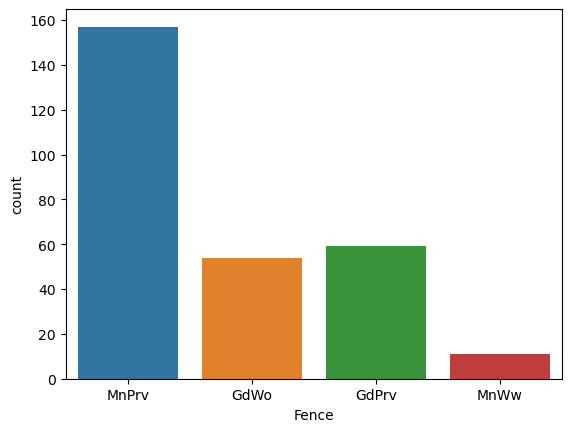

In [299]:
sns.countplot(x='Fence', data = HS)

###### Cleaning:

1. No underrepresnted values.

In [300]:
HS[HS.Fence.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Age,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std
0,208500.0,548.0,856,7,1,0,2,1,CollgCr,TA,...,7,"(0, 15]",7,2.572466,-0.809979,3.538953,1.225873,122.000000,14.731472,-0.170227
1,181500.0,460.0,1262,6,0,1,2,0,Veenker,TA,...,34,"(30, 60]",34,5.851622,0.664781,-2.794658,-0.821747,298.000000,22.186754,0.586983
2,223500.0,608.0,920,7,1,0,2,1,CollgCr,TA,...,9,"(0, 15]",8,2.798296,-0.708415,3.457202,1.199444,84.000000,12.329276,-0.414210
3,140000.0,642.0,961,7,1,0,1,0,Crawfor,TA,...,95,"(60, 140]",40,6.274929,0.855158,-2.794658,-0.821747,342.000000,23.594677,0.729981
4,250000.0,836.0,1145,8,1,0,2,1,NoRidge,TA,...,10,"(0, 15]",10,3.194668,-0.530152,3.772725,1.301450,360.000000,24.139379,0.785305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,84500.0,0.0,1140,5,0,0,1,0,Mitchel,No Garage,...,4,"(0, 15]",4,1.712112,-1.196913,-2.794658,-0.821747,148.000000,16.124630,-0.028728
1454,185000.0,400.0,1221,7,1,0,2,0,Somerst,TA,...,6,"(0, 15]",5,2.039117,-1.049846,-2.794658,-0.821747,226.000000,19.585048,0.322736
1455,175000.0,460.0,953,6,0,0,2,1,Gilbert,TA,...,11,"(0, 15]",10,3.194668,-0.530152,-2.794658,-0.821747,80.000000,12.041148,-0.443475
1458,142125.0,240.0,1078,5,1,0,1,0,NAmes,TA,...,60,"(30, 60]",14,3.839902,-0.239965,-2.794658,-0.821747,478.000000,27.362026,1.112619


In [301]:
HS['Fence'] = HS['Fence'].fillna('No Fence')

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/2171636160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['Fence'] = HS['Fence'].fillna('No Fence')


In [302]:
print(HS['Fence'].value_counts())
HS['Fence'].value_counts(normalize = True).round(2)

Fence
No Fence    1179
MnPrv        157
GdPrv         59
GdWo          54
MnWw          11
Name: count, dtype: int64


Fence
No Fence    0.81
MnPrv       0.11
GdPrv       0.04
GdWo        0.04
MnWw        0.01
Name: proportion, dtype: float64

### 24) Cleaning Pools

In [303]:
HS['Pool'] = HS['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/1904061732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['Pool'] = HS['PoolArea'].apply(lambda x: 1 if x > 0 else 0)


In [304]:
HS.Pool.value_counts()

Pool
0    1453
1       7
Name: count, dtype: int64

Only 7 cases of pools in the dataset so we will not incorporate this into our linear regression.

### 25) Cleaning TotRmsAbvGrd

In [305]:
print(HS['TotRmsAbvGrd'].value_counts())
HS['TotRmsAbvGrd'].value_counts(normalize = True).round(2)

TotRmsAbvGrd
6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: count, dtype: int64


TotRmsAbvGrd
6     0.28
7     0.23
5     0.19
8     0.13
4     0.07
9     0.05
10    0.03
11    0.01
3     0.01
12    0.01
2     0.00
14    0.00
Name: proportion, dtype: float64

I will put the 14 rooms into the 12 rooms category, and the 2 rooms into the three room category.

In [306]:
HS.loc[HS.TotRmsAbvGrd == 14, 'TotRmsAbvGrd'] = 12

In [307]:
HS.loc[HS.TotRmsAbvGrd == 2, 'TotRmsAbvGrd'] = 3

In [308]:
print(HS['TotRmsAbvGrd'].value_counts())

TotRmsAbvGrd
6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      18
12     12
Name: count, dtype: int64


4. Checking for outliers

In [309]:
HS[HS.TotRmsAbvGrd.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool


### 26) Cleaning LotArea

###### Exploration:

1) First I will check the descriptive statistics, the boxplot to show outliers, and kdeplot to show skewing as LotArea is a numeric variable.

In [310]:
HS.agg(
        {
            'LotArea':['min','mean', 'median','max','std'],
        }).round(2)

,LotArea
min,1300.00
mean,10516.83
median,9478.50
max,215245.00
std,9981.26


In [311]:
LotArea_mean = HS['LotArea'].mean()
LotArea_std = HS['LotArea'].std()

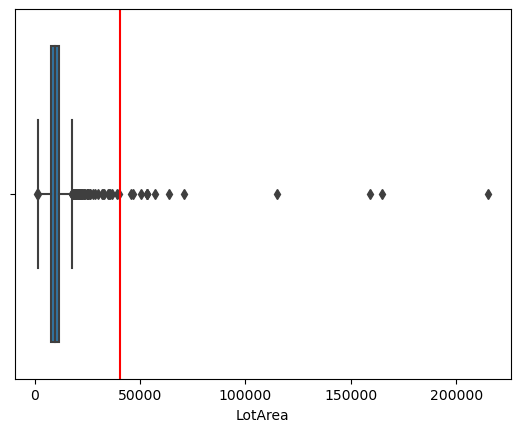

In [312]:
x = sns.boxplot(x='LotArea', data = HS)
x = x.axvline(LotArea_mean + 3* LotArea_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

<Axes: xlabel='LotArea', ylabel='Density'>

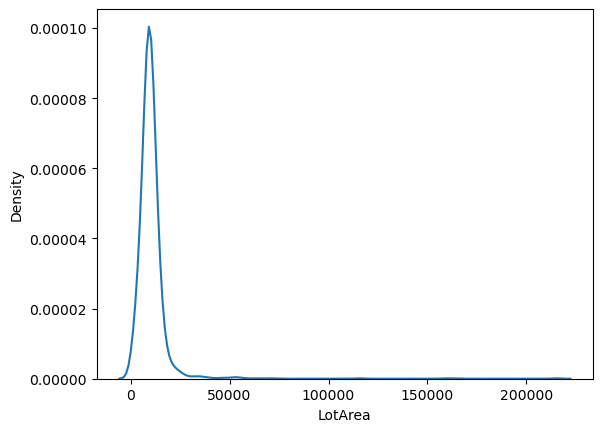

In [313]:
sns.kdeplot(x='LotArea', data = HS)

###### Cleaning:

1) As we can see the KDE plot is skewed to the right so I will clean outliers based on neighborhood

In [314]:
HS.groupby("Neighborhood")["LotArea"].agg(['mean', 'median','std']).round(0)

,mean,median,std
Neighborhood,,,
Blmngtn,3398.0,3182.0,372.0
BrDale,1801.0,1680.0,194.0
BrkSide,7360.0,6240.0,2714.0
ClearCr,30876.0,17575.0,34777.0
CollgCr,9619.0,9356.0,2345.0
Crawfor,11810.0,11500.0,5315.0
Edwards,10219.0,9091.0,7027.0
Gilbert,11379.0,9967.0,4680.0
IDOTRR,8109.0,7920.0,2547.0


In [315]:
(HS[HS['LotArea'] > LotArea_mean + 3* LotArea_std])

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool
53,385000.000000,894.00000,1842,9,2,0,0,1,Veenker,TA,...,"(15, 30]",23,4.906009,0.239503,-2.794658,-0.821747,695.180655,32.225868,1.606624,0
249,277000.000000,389.00000,1444,6,0,1,2,0,ClearCr,TA,...,"(30, 60]",4,1.712112,-1.196913,3.884943,1.337730,196.000000,18.354288,0.197731,0
313,375000.000000,513.00000,2036,7,2,0,2,0,Timber,TA,...,"(30, 60]",45,6.593433,0.998401,-2.794658,-0.821747,0.000000,-1.500065,-1.818813,0
335,228950.000000,529.00000,1619,5,2,0,2,0,Timber,TA,...,"(30, 60]",45,6.593433,0.998401,-2.794658,-0.821747,670.000000,31.713509,1.554585,0
384,240000.000000,501.00000,1079,6,1,0,2,1,ClearCr,TA,...,"(15, 30]",18,4.361749,-0.005271,-2.794658,-0.821747,678.000000,31.877514,1.571243,0
451,280000.000000,576.00000,1533,7,1,0,2,0,ClearCr,TA,...,"(30, 60]",35,5.925781,0.698133,-2.794658,-0.821747,308.000000,22.517096,0.620534,0
457,256000.000000,529.00000,1663,4,1,0,1,0,ClearCr,TA,...,"(30, 60]",16,4.112756,-0.117253,-2.794658,-0.821747,498.000000,27.859199,1.163115,0
661,402000.000000,711.00000,1686,8,1,0,2,1,NoRidge,TA,...,"(15, 30]",5,2.039117,-1.049846,3.925626,1.350882,669.000000,31.692926,1.552495,0
706,302000.000000,739.00000,1824,7,1,0,2,0,ClearCr,TA,...,"(30, 60]",8,2.798296,-0.708415,3.773822,1.301805,476.000000,27.311631,1.107500,0
769,297928.580713,841.00000,1690,8,1,0,3,1,StoneBr,TA,...,"(0, 15]",7,2.572466,-0.809979,3.972870,1.366156,785.000000,33.968267,1.783594,0


###### Cleaning with each outliers grouped mean + 3std based on what neighborhood the house is in:

1. ClearCr:

In [316]:
ClearCr_LotArea_mean = HS[(HS.Neighborhood == "ClearCr") &
                               (HS.LotArea < LotArea_mean + 3* LotArea_std)]["LotArea"].mean()
ClearCr_LotArea_mean

16712.590909090908

In [317]:
ClearCr_LotArea_std = HS[(HS.Neighborhood == "ClearCr") &
                               (HS.LotArea < LotArea_mean + 3* LotArea_std)]["LotArea"].std()
ClearCr_LotArea_std

9569.899400670889

In [318]:
Replacement_ClearCr_LotArea = ClearCr_LotArea_mean + 3 * ClearCr_LotArea_std

In [319]:
HS.loc[(HS.LotArea >  LotArea_mean + 3* LotArea_std) & 
       (HS.Neighborhood == "ClearCr"), "LotArea"] = Replacement_ClearCr_LotArea

2. NoRidge:

In [320]:
NoRidge_LotArea_mean = HS[(HS.Neighborhood == "NoRidge") &
                               (HS.LotArea < LotArea_mean + 3* LotArea_std)]["LotArea"].mean()
NoRidge_LotArea_mean

13409.65

In [321]:
NoRidge_LotArea_std = HS[(HS.Neighborhood == "NoRidge") &
                               (HS.LotArea < LotArea_mean + 3* LotArea_std)]["LotArea"].std()
NoRidge_LotArea_std

5254.251165509353

In [322]:
Replacement_LotArea_NoRidge = NoRidge_LotArea_mean + 3 * NoRidge_LotArea_std

In [323]:
HS.loc[(HS.LotArea > LotArea_mean + 3* LotArea_std) & 
       (HS.Neighborhood == "NoRidge"), "LotArea"] = Replacement_LotArea_NoRidge 

3. Timber:

In [324]:
Timber_LotArea_mean = HS[(HS.Neighborhood == "Timber") &
                               (HS.LotArea < LotArea_mean + 3* LotArea_std)]["LotArea"].mean()
Timber_LotArea_mean

13203.885714285714

In [325]:
Timber_LotArea_std = HS[(HS.Neighborhood == "Timber") &
                               (HS.LotArea < LotArea_mean + 3* LotArea_std)]["LotArea"].std()
Timber_LotArea_std

5106.841534367682

In [326]:
Replacement_LotArea_Timber = Timber_LotArea_mean + 3 * Timber_LotArea_std

In [327]:
HS.loc[(HS.LotArea > LotArea_mean + 3* LotArea_std) & 
       (HS.Neighborhood == "Timber"), "LotArea"] = Replacement_LotArea_Timber 

4. Veenker:

In [328]:
Veenker_LotArea_mean = HS[(HS.Neighborhood == "Veenker") &
                               (HS.LotArea < LotArea_mean + 3* LotArea_std)]["LotArea"].mean()
Veenker_LotArea_mean

12139.5

In [329]:
Veenker_LotArea_std = HS[(HS.Neighborhood == "Veenker") &
                               (HS.LotArea < LotArea_mean + 3* LotArea_std)]["LotArea"].std()
Veenker_LotArea_std

2949.444778259122

In [330]:
Replacement_LotArea_Veenker = Veenker_LotArea_mean + 3 * Veenker_LotArea_std

In [331]:
HS.loc[(HS.LotArea > LotArea_mean + 3* LotArea_std) & 
       (HS.Neighborhood == "Veenker"), "LotArea"] = Replacement_LotArea_Veenker 

5. Edwards:

In [332]:
Edwards_LotArea_mean = HS[(HS.Neighborhood == "Edwards") &
                               (HS.LotArea < LotArea_mean + 3* LotArea_std)]["LotArea"].mean()
Edwards_LotArea_mean

9676.545454545454

In [333]:
Edwards_LotArea_std = HS[(HS.Neighborhood == "Edwards") &
                               (HS.LotArea < LotArea_mean + 3* LotArea_std)]["LotArea"].std()
Edwards_LotArea_std

4493.720503630541

In [334]:
Edwards_LotArea_Veenker = Edwards_LotArea_mean + 3 * Edwards_LotArea_std

In [335]:
HS.loc[(HS.LotArea > LotArea_mean + 3* LotArea_std) & 
       (HS.Neighborhood == "Edwards"), "LotArea"] = Edwards_LotArea_Veenker 

6. StoneBr:

In [336]:
StoneBr_LotArea_mean = HS[(HS.Neighborhood == "StoneBr") &
                               (HS.LotArea < LotArea_mean + 3* LotArea_std)]["LotArea"].mean()
StoneBr_LotArea_mean

8887.25

In [337]:
StoneBr_LotArea_std = HS[(HS.Neighborhood == "StoneBr") &
                               (HS.LotArea < LotArea_mean + 3* LotArea_std)]["LotArea"].std()
StoneBr_LotArea_std

4361.646171583266

In [338]:
StoneBr_LotArea_Veenker = StoneBr_LotArea_mean + 3 * StoneBr_LotArea_std

In [339]:
HS.loc[(HS.LotArea > LotArea_mean + 3* LotArea_std) & 
       (HS.Neighborhood == "StoneBr"), "LotArea"] = StoneBr_LotArea_Veenker 

###### All outliers are cleaned

2. The outliers have now been removed. Now, I will check for null values.

In [340]:
HS[HS.LotArea.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,House_Age_bin,Last_Remod,Last_Remod_transformed,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool


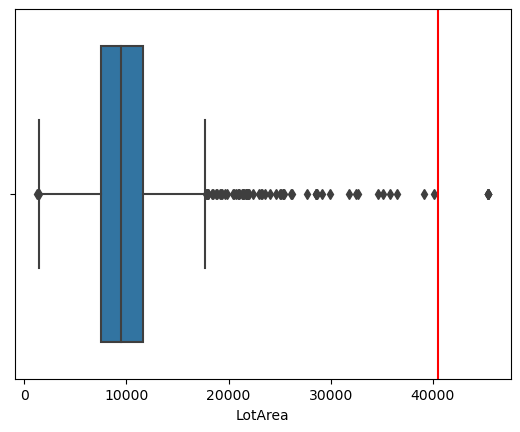

In [341]:
x = sns.boxplot(x='LotArea', data = HS)
x = x.axvline(LotArea_mean + 3* LotArea_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

<Axes: xlabel='LotArea', ylabel='Density'>

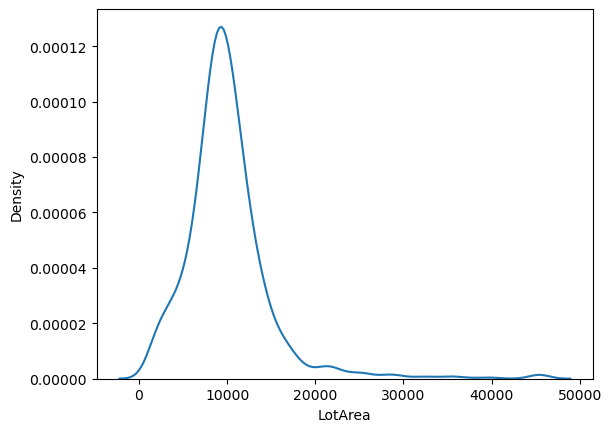

In [342]:
sns.kdeplot(x='LotArea', data = HS)

4. I will now use BoxCox to help it better follow a normal distribution. 

In [343]:
LotArea_Transformed, best_lambda = boxcox(HS['LotArea']) 

In [344]:
HS['LotArea_Trans'] = LotArea_Transformed

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/2966713902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['LotArea_Trans'] = LotArea_Transformed


5. Now that the data is cleaned and bests follows a normal distribution, I will save the standard deviation values (z-scores) for each individual value to help me in the future.

In [345]:
scaler = StandardScaler()
HS["LotArea_std"] = scaler.fit_transform(HS[['LotArea_Trans']])
HS[["LotArea_std", 'LotArea_Trans',"LotArea"]].head(10)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/1219676477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["LotArea_std"] = scaler.fit_transform(HS[['LotArea_Trans']])


,LotArea_std,LotArea_Trans,LotArea
0,-0.200042,45.060140,8450.0
1,0.067640,46.910866,9600.0
2,0.414668,49.310178,11250.0
3,0.056487,46.833755,9550.0
4,0.964520,53.111795,14260.0
5,0.940020,52.942399,14115.0
6,0.173537,47.643025,10084.0
7,0.236963,48.081547,10382.0
8,-0.833729,40.678897,6120.0
9,-0.462618,43.244721,7420.0


As we can see, now there are not outliers or null values for the lot frontage column. We can now begin analysis.

### 27) Creating and Cleaning Variable "Has a 2nd Floor"

In [346]:
HS['Has_a_2nd_Flr'] = HS['2ndFlrSF'].apply(lambda x: '2-Story' if x > 0 else '1_Story')

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/122246975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['Has_a_2nd_Flr'] = HS['2ndFlrSF'].apply(lambda x: '2-Story' if x > 0 else '1_Story')


In [347]:
print(HS['Has_a_2nd_Flr'].value_counts())
HS['Has_a_2nd_Flr'].value_counts(normalize = True).round(2)

Has_a_2nd_Flr
1_Story    829
2-Story    631
Name: count, dtype: int64


Has_a_2nd_Flr
1_Story    0.57
2-Story    0.43
Name: proportion, dtype: float64

<Axes: xlabel='Has_a_2nd_Flr', ylabel='count'>

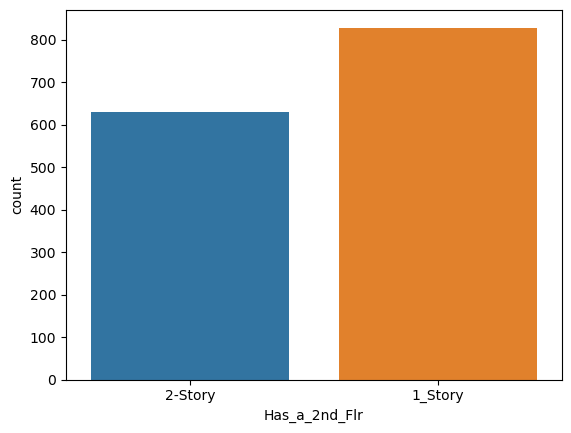

In [348]:
sns.countplot(x='Has_a_2nd_Flr', data = HS)

###### Cleaning:

3) No underrepresnted values

4. Checking for nulls

In [349]:
HS[HS.Has_a_2nd_Flr.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr


### 28) Cleaning KitchenQual

###### Exploration:

1. We check for proportions and countplot for categorical variable exploration. We treat it as a categorical as there are not a wide array of values and the measure is subjective i.e. OverallQual could be interpretted differently by different people.

In [350]:
print(HS['KitchenQual'].value_counts())
HS['KitchenQual'].value_counts(normalize = True).round(2)

KitchenQual
TA    735
Gd    586
Ex    100
Fa     39
Name: count, dtype: int64


KitchenQual
TA    0.50
Gd    0.40
Ex    0.07
Fa    0.03
Name: proportion, dtype: float64

<Axes: xlabel='KitchenQual', ylabel='count'>

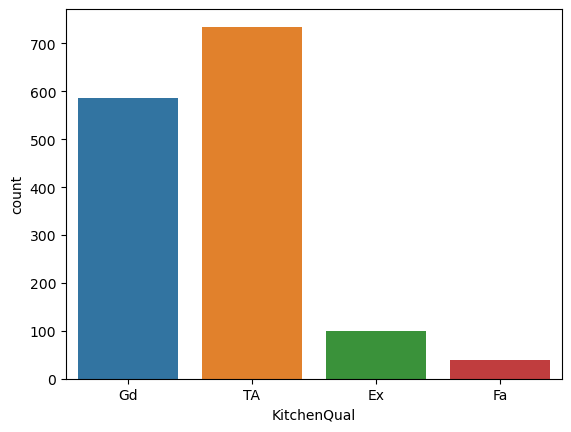

In [351]:
sns.countplot(x='KitchenQual', data = HS)

###### Cleaning:

1. No underrepresnted values.

In [352]:
HS[HS.KitchenQual.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr


### 29) Cleaning LotFrontage

###### Exploration:

1) First I will check the descriptive statistics, the boxplot to show outliers, and kdeplot to show skewing as LotFrontage is a numeric variable.

In [353]:
HS.agg(
        {
            'LotFrontage':['min','mean', 'median','max','std'],
        }).round(2)

,LotFrontage
min,21.00
mean,70.05
median,69.00
max,313.00
std,24.28


In [354]:
LotFrontage_mean = HS['LotFrontage'].mean()
LotFrontage_std = HS['LotFrontage'].std()

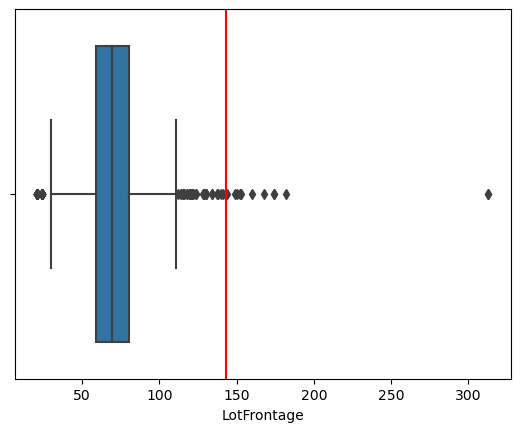

In [355]:
x = sns.boxplot(x='LotFrontage', data = HS)
x = x.axvline(LotFrontage_mean + 3* LotFrontage_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

<Axes: xlabel='LotFrontage', ylabel='Density'>

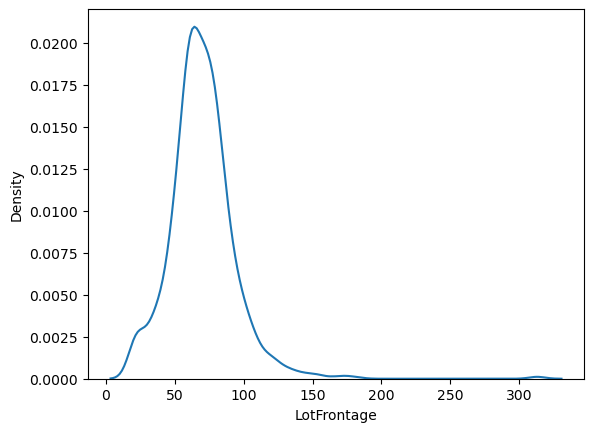

In [356]:
sns.kdeplot(x='LotFrontage', data = HS)

###### Cleaning:

1) As we can see the KDE plot is skewed to the right, and with the standard deviation as high as it is in comparison to the mean, it looks like there are outliers that need to be cleaned. Especially the value at around ~ 300. I will now clean all outliers that are more than 3 standard deviations away by replacing those values with the mean + 3 standard deviations based on the neighborhood they are in.

In [357]:
HS.groupby("Neighborhood")["LotFrontage"].agg(['mean', 'median','std']).round(0)

,mean,median,std
Neighborhood,,,
Blmngtn,47.0,43.0,5.0
BrDale,22.0,21.0,1.0
BrkSide,58.0,52.0,16.0
ClearCr,83.0,80.0,19.0
CollgCr,72.0,70.0,16.0
Crawfor,72.0,74.0,19.0
Edwards,68.0,66.0,32.0
Gilbert,80.0,65.0,33.0
IDOTRR,62.0,60.0,18.0


In [358]:
(HS[HS['LotFrontage'] > LotFrontage_mean + 3* LotFrontage_std])

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr
197,235000.000000,795.00000,1360,8,1,1,2,0,NAmes,TA,...,0.097961,-2.794658,-0.821747,584.0,29.871372,1.367485,1,63.569391,2.477069,2-Story
231,403000.000000,810.00000,1490,8,1,0,2,1,NoRidge,TA,...,-0.239965,3.910270,1.345918,494.0,27.760731,1.153114,0,54.112348,1.109237,2-Story
313,375000.000000,513.00000,2036,7,2,0,2,0,Timber,TA,...,0.998401,-2.794658,-0.821747,0.0,-1.500065,-1.818813,0,65.875514,2.810618,1_Story
807,223500.000000,528.00000,1072,5,2,0,1,1,BrkSide,TA,...,-0.922660,-2.794658,-0.821747,624.0,30.747000,1.456420,0,60.254104,1.997558,2-Story
909,174000.000000,390.00000,742,6,0,0,2,1,Gilbert,TA,...,-1.049846,-2.794658,-0.821747,84.0,12.329276,-0.414210,0,51.080359,0.670701,2-Story
934,242000.000000,505.00000,2069,7,1,0,2,0,NAmes,TA,...,-1.373257,-2.794658,-0.821747,0.0,-1.500065,-1.818813,0,65.244877,2.719405,1_Story
1107,274725.000000,422.00000,887,7,0,0,2,1,Gilbert,TA,...,-1.196913,-2.794658,-0.821747,200.0,18.524599,0.215029,0,61.843477,2.227439,2-Story
1127,259000.000000,630.00000,1530,7,1,0,2,0,Gilbert,TA,...,-0.922660,-2.794658,-0.821747,216.0,19.186260,0.282232,0,53.472204,1.016649,1_Story
1182,446006.756854,813.00000,2411,10,1,0,3,1,NoRidge,TA,...,-0.239965,-2.794658,-0.821747,327.0,23.127542,0.682536,1,54.647564,1.186648,2-Story
1211,164000.000000,492.00000,1080,8,0,0,2,0,Gilbert,TA,...,-1.049846,-2.794658,-0.821747,349.0,23.808492,0.751698,0,50.494445,0.585956,2-Story


###### Cleaning with each outliers grouped mean + 3std based on what neighborhood the house is in:

1. NAmes:

In [359]:
NAmes_LotFrontage_mean = HS[(HS.Neighborhood == "NAmes") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].mean()
NAmes_LotFrontage_mean

74.64673913043478

In [360]:
NAmes_LotFrontage_std = HS[(HS.Neighborhood == "NAmes") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].std()
NAmes_LotFrontage_std

14.216137609899425

In [361]:
Replacement_LF_NAmes = NAmes_LotFrontage_mean + 3 * NAmes_LotFrontage_std

In [362]:
HS.loc[(HS.LotFrontage > LotFrontage_mean + 3* LotFrontage_std) & 
       (HS.Neighborhood == "NAmes"), "LotFrontage"] = Replacement_LF_NAmes

2. NoRidge:

In [363]:
NoRidge_LotFrontage_mean = HS[(HS.Neighborhood == "NoRidge") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].mean()
NoRidge_LotFrontage_mean

87.03225806451613

In [364]:
NoRidge_LotFrontage_std = HS[(HS.Neighborhood == "NoRidge") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].std()
NoRidge_LotFrontage_std

16.73615621136415

In [365]:
Replacement_LF_NoRidge = NoRidge_LotFrontage_mean + 3 * NoRidge_LotFrontage_std

In [366]:
HS.loc[(HS.LotFrontage > LotFrontage_mean + 3* LotFrontage_std) & 
       (HS.Neighborhood == "NoRidge"), "LotFrontage"] = Replacement_LF_NoRidge 

3. Timber:

In [367]:
Timber_LotFrontage_mean = HS[(HS.Neighborhood == "Timber") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].mean()
Timber_LotFrontage_mean

77.72413793103448

In [368]:
Timber_LotFrontage_std = HS[(HS.Neighborhood == "Timber") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].std()
Timber_LotFrontage_std

20.156347018325338

In [369]:
Replacement_LF_Timber = Timber_LotFrontage_mean + 3 * Timber_LotFrontage_std

In [370]:
HS.loc[(HS.LotFrontage > LotFrontage_mean + 3* LotFrontage_std) & 
       (HS.Neighborhood == "Timber"), "LotFrontage"] = Replacement_LF_Timber 

4. BrkSide:

In [371]:
BrkSide_LotFrontage_mean = HS[(HS.Neighborhood == "BrkSide") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].mean()
BrkSide_LotFrontage_mean

55.78

In [372]:
BrkSide_LotFrontage_std = HS[(HS.Neighborhood == "BrkSide") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].std()
BrkSide_LotFrontage_std

9.504649775080551

In [373]:
Replacement_LF_BrkSide = BrkSide_LotFrontage_mean + 3 * BrkSide_LotFrontage_std

In [374]:
HS.loc[(HS.LotFrontage > LotFrontage_mean + 3* LotFrontage_std) & 
       (HS.Neighborhood == "BrkSide"), "LotFrontage"] = Replacement_LF_BrkSide 

5. Gilbert:

In [375]:
Gilbert_LotFrontage_mean = HS[(HS.Neighborhood == "Gilbert") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].mean()
Gilbert_LotFrontage_mean

72.5111111111111

In [376]:
Gilbert_LotFrontage_std = HS[(HS.Neighborhood == "Gilbert") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].std()
Gilbert_LotFrontage_std

21.774278218099255

In [377]:
Replacement_LF_Gilbert = Gilbert_LotFrontage_mean + 3 * Gilbert_LotFrontage_std

In [378]:
HS.loc[(HS.LotFrontage > LotFrontage_mean + 3* LotFrontage_std) & 
       (HS.Neighborhood == "Gilbert"), "LotFrontage"] = Replacement_LF_Gilbert

6. Edwards:

In [379]:
Edwards_LotFrontage_mean = HS[(HS.Neighborhood == "Edwards") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].mean()
Edwards_LotFrontage_mean

65.52747252747253

In [380]:
Edwards_LotFrontage_std = HS[(HS.Neighborhood == "Edwards") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].std()
Edwards_LotFrontage_std

19.759296354622357

In [381]:
Replacement_LF_Edwards = Edwards_LotFrontage_mean + 3 * Edwards_LotFrontage_std

In [382]:
HS.loc[(HS.LotFrontage > LotFrontage_mean + 3* LotFrontage_std) & 
       (HS.Neighborhood == "Edwards"), "LotFrontage"] = Replacement_LF_Edwards

7. Oldtown:

In [383]:
OldTown_LotFrontage_mean = HS[(HS.Neighborhood == "OldTown") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].mean()
OldTown_LotFrontage_mean

61.9537037037037

In [384]:
OldTown_LotFrontage_std = HS[(HS.Neighborhood == "OldTown") &
                               (HS.LotFrontage < LotFrontage_mean + 3* LotFrontage_std)]["LotFrontage"].std()
OldTown_LotFrontage_std

16.014820390366136

In [385]:
Replacement_LF_OldTown = OldTown_LotFrontage_mean + 3 * OldTown_LotFrontage_std

In [386]:
HS.loc[(HS.LotFrontage > LotFrontage_mean + 3* LotFrontage_std) & 
       (HS.Neighborhood == "OldTown"), "LotFrontage"] = Replacement_LF_OldTown

In [387]:
(HS[HS['LotFrontage'] > LotFrontage_mean + 3* LotFrontage_std])

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr


###### All outliers are cleaned

2. The outliers have now been removed. Now, I will check for null values.

In [388]:
HS[HS.LotFrontage.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr
7,200000.0,484.0,1107,7,1,0,2,1,NWAmes,TA,...,0.762798,3.623124,1.253085,882.605959,35.731615,1.962692,0,48.081547,0.236963,2-Story
12,144000.0,352.0,912,5,1,0,1,0,Sawyer,TA,...,1.078826,-2.794658,-0.821747,316.000000,22.776789,0.646911,0,51.557091,0.739653,1_Story
14,157000.0,352.0,1253,6,1,0,1,1,NAmes,TA,...,1.130418,3.571896,1.236523,602.000000,30.269695,1.407942,0,48.851235,0.348288,1_Story
16,149000.0,480.0,1004,6,1,0,1,0,NAmes,TA,...,0.855158,3.502725,1.214161,0.000000,-1.500065,-1.818813,0,49.297788,0.412876,1_Story
24,154000.0,270.0,1060,5,1,0,1,0,Sawyer,TA,...,-0.615680,-2.794658,-0.821747,586.000000,29.915989,1.372017,0,44.713522,-0.250176,1_Story
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,182900.0,467.0,1440,6,0,0,2,0,NWAmes,TA,...,0.486311,3.725603,1.286216,99.000000,13.342394,-0.311311,0,51.025633,0.662785,1_Story
1431,143750.0,440.0,958,6,0,0,2,0,SWISU,TA,...,0.664781,-2.794658,-0.821747,120.000000,14.617243,-0.181829,0,37.961435,-1.226773,1_Story
1441,149300.0,420.0,848,6,1,0,1,0,CollgCr,TA,...,-0.922660,3.414525,1.185646,149.000000,16.175178,-0.023594,0,36.676511,-1.412620,1_Story
1443,121000.0,192.0,952,6,0,0,1,0,BrkSide,Fa,...,1.367837,-2.794658,-0.821747,236.000000,19.973442,0.362184,0,45.729509,-0.103227,1_Story


3. Now that we see there are null values, I can use the lambda function to full those values in. I will fill this in with 0s as when it is a null value, it means that there is no lot frontage, hence the 0.

In [389]:
HS['LotFrontage'] = HS['LotFrontage'].fillna(0)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/1558784770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['LotFrontage'] = HS['LotFrontage'].fillna(0)


In [390]:
HS[HS.LotFrontage.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,Last_Remod_std,MasVnrArea_transformed,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr


4. I will now use BoxCox to help it better follow a normal distribution. Because there are 0 values I add the small constant of 0.1 to allow boxcox to work.

In [391]:
LotFrontage_Transformed, best_lambda = boxcox(HS['LotFrontage']+0.1) 

In [392]:
HS['LotFrontage_Trans'] = LotFrontage_Transformed

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/2632477166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['LotFrontage_Trans'] = LotFrontage_Transformed


5. Now that the data is cleaned and bests follows a normal distribution, I will save the standard deviation values (z-scores) for each individual value to help me in the future.

In [393]:
scaler = StandardScaler()
HS["LotFrontage_std"] = scaler.fit_transform(HS[['LotFrontage_Trans']])
HS[["LotFrontage_std", 'LotFrontage_Trans',"LotFrontage"]].head(10)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/3532953474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["LotFrontage_std"] = scaler.fit_transform(HS[['LotFrontage_Trans']])


,LotFrontage_std,LotFrontage_Trans,LotFrontage
0,0.347489,20.476157,65.0
1,0.672613,23.556956,80.0
2,0.414563,21.111730,68.0
3,0.233101,19.392237,60.0
4,0.755389,24.341327,84.0
5,0.775854,24.535249,85.0
6,0.566960,22.555812,75.0
7,-1.941601,-1.214784,0.0
8,0.017887,17.352912,51.0
9,-0.006860,17.118418,50.0


As we can see, now there are not outliers or null values for the lot frontage column. We can now begin analysis.

### 30) Cleaning GarageArea

###### Exploration:

1. First I will check the descriptive statistics, the boxplot to show outliers, and kdeplot to show skewing as GarageArea is a numeric variable.

In [394]:
HS.agg(
        {
            'GarageArea':['min','mean', 'median','max','std'],
        }).round(2)

,GarageArea
min,0.00
mean,471.98
median,480.00
max,1201.85
std,210.53


In [395]:
GarageArea_mean = HS['GarageArea'].mean()
GarageArea_std = HS['GarageArea'].std()

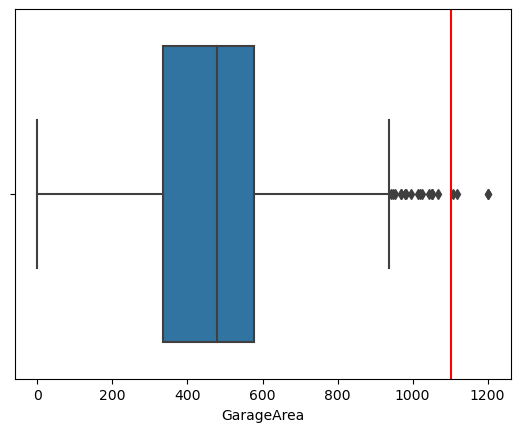

In [396]:
x = sns.boxplot(x='GarageArea', data = HS)
x = x.axvline(GarageArea_mean + 3* GarageArea_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

<Axes: xlabel='GarageArea', ylabel='Density'>

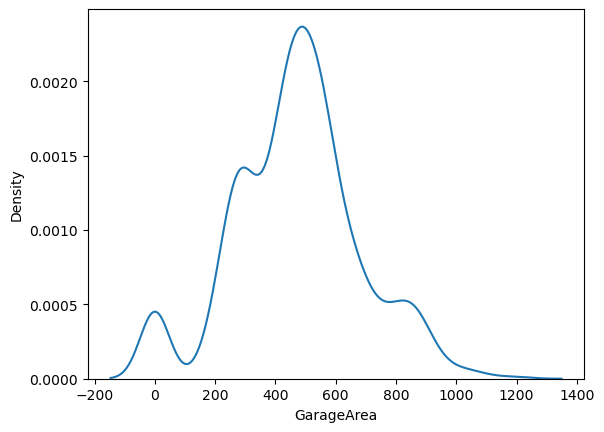

In [397]:
sns.kdeplot(x='GarageArea', data = HS)

###### Cleaning:

1. As we can tell from the Boxplot there are some outliers that need to be cleaned. I will clean using the median GarageArea based on the neighborhood the garage is in, as I am sure the sizes vary based on what area they are in. I will replace by each neighborhoods mean value + 3 standard deviations

In [398]:
HS.groupby("Neighborhood")["GarageArea"].agg(['mean', 'median','std']).round(0)

,mean,median,std
Neighborhood,,,
Blmngtn,503.0,438.0,115.0
BrDale,284.0,264.0,102.0
BrkSide,303.0,280.0,193.0
ClearCr,468.0,476.0,147.0
CollgCr,553.0,546.0,162.0
Crawfor,410.0,380.0,203.0
Edwards,321.0,318.0,217.0
Gilbert,453.0,427.0,89.0
IDOTRR,307.0,288.0,233.0


In [399]:
(HS[HS['GarageArea'] > GarageArea_mean + 3* GarageArea_std])

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr,LotFrontage_Trans,LotFrontage_std
581,253293.000000,1201.852147,2042,8,0,0,2,1,NridgHt,TA,...,1.284568,180.0,17.651461,0.126347,0,51.226072,0.691776,1_Story,26.984269,1.034304
664,379604.690189,1108.851114,2097,8,1,0,1,1,Somerst,TA,...,-0.821747,726.0,32.838107,1.668807,0,59.823940,1.935341,1_Story,16.882187,-0.031790
825,385000.000000,1201.852147,2084,10,1,0,2,0,NridgHt,TA,...,1.373874,278.0,21.505651,0.517805,0,53.735549,1.054738,1_Story,29.839259,1.335597
1190,168000.000000,1119.098859,1622,4,1,0,1,0,Mitchel,TA,...,1.187578,439.0,26.355565,1.010396,0,68.557968,3.198599,1_Story,-1.214784,-1.941601


###### Cleaning with each outliers grouped mean based on what neighborhood the house is in:

1. StoneBr:

In [400]:
StoneBr_GarageArea_mean = HS[(HS.Neighborhood == "StoneBr") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].mean()
StoneBr_GarageArea_mean

624.0236416281336

In [401]:
StoneBr_GarageArea_std = HS[(HS.Neighborhood == "StoneBr") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].std()
StoneBr_GarageArea_std

141.357524291822

In [402]:
Replacement_StoneBr = StoneBr_GarageArea_mean + 3 * StoneBr_GarageArea_std

In [403]:
HS.loc[(HS.GarageArea > GarageArea_mean + 3* GarageArea_std) & 
       (HS.Neighborhood == "StoneBr"), "GarageArea"] = Replacement_StoneBr 

2. NridgHt: 

In [404]:
NridgHt_GarageArea_mean = HS[(HS.Neighborhood == "NridgHt") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].mean()
NridgHt_GarageArea_mean

730.84

In [405]:
NridgHt_GarageArea_std = HS[(HS.Neighborhood == "NridgHt") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].std()
NridgHt_GarageArea_std

157.00404883744673

In [406]:
Replacement_NridgHt = NridgHt_GarageArea_mean + 3 * NridgHt_GarageArea_std

In [407]:
HS.loc[(HS.GarageArea > GarageArea_mean + 3* GarageArea_std) & 
       (HS.Neighborhood == "NridgHt"),'GarageArea'] = Replacement_NridgHt 

3. Somerst:

In [408]:
Somerst_GarageArea_mean = HS[(HS.Neighborhood == "Somerst") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].mean()
Somerst_GarageArea_mean

624.7058823529412

In [409]:
Somerst_GarageArea_std = HS[(HS.Neighborhood == "Somerst") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].std()
Somerst_GarageArea_std

161.38174378439078

In [410]:
Replacement_Somerst = Somerst_GarageArea_mean + 3 * Somerst_GarageArea_std

In [411]:
HS.loc[(HS.GarageArea > GarageArea_mean + 3* GarageArea_std) & 
       (HS.Neighborhood == "Somerst"), "GarageArea"] = Replacement_Somerst 

4. IDOTRR:

In [412]:
IDOTRR_GarageArea_mean = HS[(HS.Neighborhood == "IDOTRR") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].mean()
IDOTRR_GarageArea_mean

307.24879651138144

In [413]:
IDOTRR_GarageArea_std = HS[(HS.Neighborhood == "IDOTRR") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].std()
IDOTRR_GarageArea_std

233.02576771237497

In [414]:
Replacement_IDOTRR = IDOTRR_GarageArea_mean + 3 * IDOTRR_GarageArea_std

In [415]:
HS.loc[(HS.GarageArea > GarageArea_mean + 3* GarageArea_std) & 
       (HS.Neighborhood == "IDOTRR"), "GarageArea"] = Replacement_IDOTRR 

5. Mitchel: 

In [416]:
Mitchel_GarageArea_mean = HS[(HS.Neighborhood == "Mitchel") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].mean()
Mitchel_GarageArea_mean

463.7916666666667

In [417]:
Mitchel_GarageArea_std = HS[(HS.Neighborhood == "Mitchel") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].std()
Mitchel_GarageArea_std

218.4357306846028

In [418]:
Replacement_Mitchel = Mitchel_GarageArea_mean + 3 * Mitchel_GarageArea_std
Replacement_Mitchel

1119.0988587204752

In [419]:
HS.loc[(HS.GarageArea > GarageArea_mean + 3* GarageArea_std) & 
       (HS.Neighborhood == "Mitchel"), "GarageArea"] = Replacement_Mitchel

6. Edwards:

In [420]:
Edwards_GarageArea_mean = HS[(HS.Neighborhood == "Edwards") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].mean()
Edwards_GarageArea_mean

321.44950460263817

In [421]:
Edwards_GarageArea_mean = HS[(HS.Neighborhood == "Edwards") &
                               (HS.GarageArea < GarageArea_mean + 3* GarageArea_std)]["GarageArea"].std()
Edwards_GarageArea_mean

217.4587658483297

In [422]:
Replacement_Edwards = Edwards_GarageArea_mean + 3 * Edwards_GarageArea_std
Replacement_Edwards

845.2375089404267

In [423]:
HS.loc[(HS.GarageArea > GarageArea_mean + 3* GarageArea_std) & 
       (HS.Neighborhood == "Edwards"), "GarageArea"] = Replacement_Edwards

2. The outliers have now been removed. Now, I will check for null values.

In [424]:
HS[HS['GarageArea'].isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,MasVnrArea_std,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr,LotFrontage_Trans,LotFrontage_std


3. There are no null values, outliers have been cleaned, and all values look like they make sense to me. Now I will use boxcox to better have GarageArea follow a normal distribution. Because there are 0 values I will add the small value of 0.1 so that boxcox can work.

In [425]:
GarageArea_transformed, best_lambda = boxcox(HS['GarageArea'] + 0.1) 
HS['GarageArea_trans'] = GarageArea_transformed

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/2167642917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['GarageArea_trans'] = GarageArea_transformed


4. Now that the data is cleaned and bests follows a normal distribution, I will save the standard deviation values (z-scores) for each individual value to help me in the future.

In [426]:
scaler = StandardScaler()
HS["GarageArea_std"] = scaler.fit_transform(HS[['GarageArea_trans']])
HS[["GarageArea_std", 'GarageArea_trans',"GarageArea"]].head(10)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/3784545495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["GarageArea_std"] = scaler.fit_transform(HS[['GarageArea_trans']])


,GarageArea_std,GarageArea_trans,GarageArea
0,0.399789,150.663052,548.0
1,0.019102,131.936536,460.0
2,0.650591,163.000304,608.0
3,0.789961,169.856111,642.0
4,1.553392,207.410288,836.0
5,0.107105,136.265519,480.0
6,0.765502,168.652954,636.0
7,0.124595,137.125885,484.0
8,0.054415,133.673636,468.0
9,-1.213595,71.298600,205.0


### 31) Cleaning CentralAir

###### Exploration:

We check for proportions and countplot for categorical variable exploration.

In [427]:
print(HS['CentralAir'].value_counts())
HS['CentralAir'].value_counts(normalize = True).round(2)

CentralAir
Y    1365
N      95
Name: count, dtype: int64


CentralAir
Y    0.93
N    0.07
Name: proportion, dtype: float64

<Axes: xlabel='CentralAir', ylabel='count'>

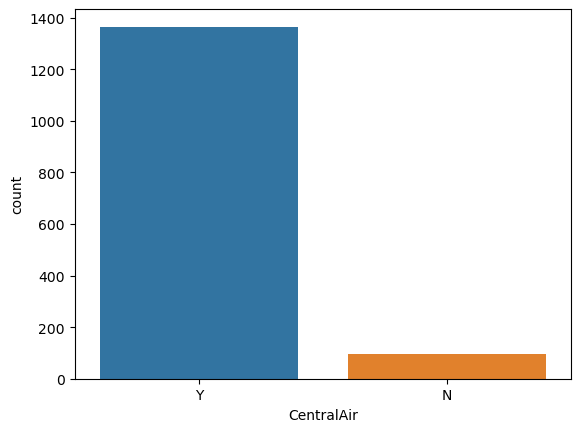

In [428]:
sns.countplot(x='CentralAir', data = HS)

###### Cleaning:

1. There are no underrepresented values to clean.

In [429]:
HS[HS.CentralAir.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr,LotFrontage_Trans,LotFrontage_std,GarageArea_std


### 32) Cleaning ExterQual

###### Exploration:

1. We check for proportions and countplot for categorical variable exploration. We treat it as a categorical as there are not a wide array of values and the measure is subjective i.e. OverallQual could be interpretted differently by different people.

In [430]:
print(HS['ExterQual'].value_counts())
HS['ExterQual'].value_counts(normalize = True).round(2)

ExterQual
TA    906
Gd    488
Ex     52
Fa     14
Name: count, dtype: int64


ExterQual
TA    0.62
Gd    0.33
Ex    0.04
Fa    0.01
Name: proportion, dtype: float64

<Axes: xlabel='ExterQual', ylabel='count'>

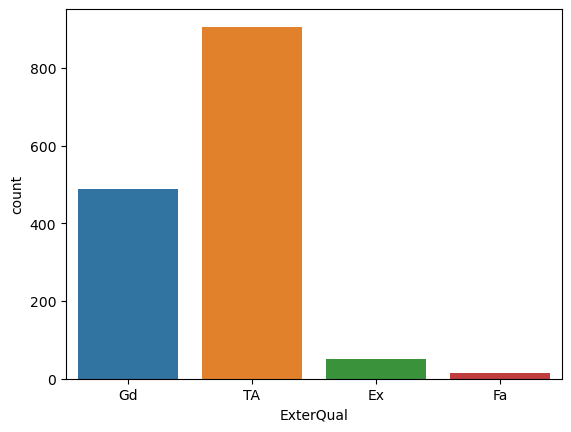

In [431]:
sns.countplot(x='ExterQual', data = HS)

###### Cleaning:

3) I can see all the building types bar one are 1fam, the house style kind of varies, I think I will replace them just into the PConc as it has the highest value count.

In [432]:
HS.loc[HS.Foundation == 'Wood', 'Foundation'] = 'PConc'

In [433]:
HS.loc[HS.Foundation == 'Stone', 'Foundation'] = 'PConc'

4. Checking for outliers

In [434]:
HS[HS.Foundation.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr,LotFrontage_Trans,LotFrontage_std,GarageArea_std


### 33) Cleaning RoofStyle

###### Exploration:

We check for proportions and countplot for categorical variable exploration.

In [435]:
print(HS['RoofStyle'].value_counts())
HS['RoofStyle'].value_counts(normalize = True).round(2)

RoofStyle
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: count, dtype: int64


RoofStyle
Gable      0.78
Hip        0.20
Flat       0.01
Gambrel    0.01
Mansard    0.00
Shed       0.00
Name: proportion, dtype: float64

<Axes: xlabel='RoofStyle', ylabel='count'>

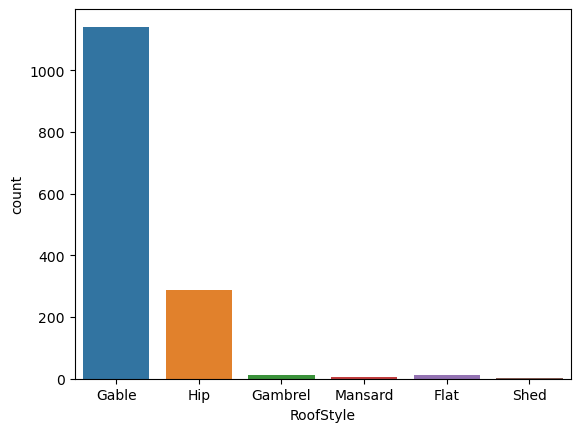

In [436]:
sns.countplot(x='RoofStyle', data = HS)

###### Cleaning:

1. There are underrepresented values to clean.

In [437]:
HS.groupby('RoofStyle')["SalePrice"].agg(np.mean)

RoofStyle
Flat       194690.000000
Gable      171162.039138
Gambrel    148909.090909
Hip        213502.429462
Mansard    180568.428571
Shed       225000.000000
Name: SalePrice, dtype: float64

2. I will put Shed into the Hip variable and Mansard into Gable as it is the closest in mean SalePrice.

In [438]:
HS.loc[HS.RoofStyle == 'Shed', 'RoofStyle'] = 'Hip'
HS.loc[HS.RoofStyle == 'Mansard', 'RoofStyle'] = 'Gable'

In [439]:
HS[HS.RoofStyle.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr,LotFrontage_Trans,LotFrontage_std,GarageArea_std


### 34) Cleaning KitchenQual

###### Exploration:

1. We check for proportions and countplot for categorical variable exploration. We treat it as a categorical as there are not a wide array of values and the measure is subjective i.e. OverallQual could be interpretted differently by different people.

In [440]:
print(HS['KitchenQual'].value_counts())
HS['KitchenQual'].value_counts(normalize = True).round(2)

KitchenQual
TA    735
Gd    586
Ex    100
Fa     39
Name: count, dtype: int64


KitchenQual
TA    0.50
Gd    0.40
Ex    0.07
Fa    0.03
Name: proportion, dtype: float64

<Axes: xlabel='KitchenQual', ylabel='count'>

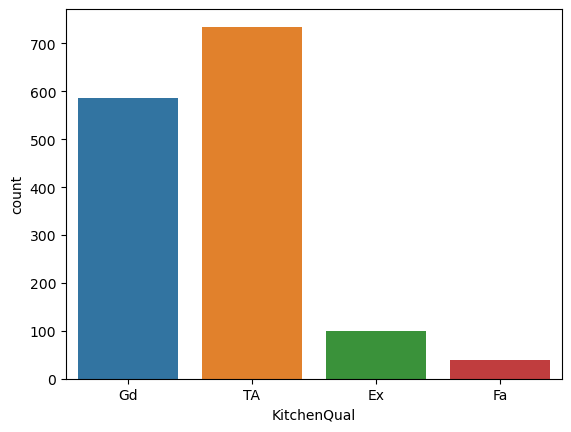

In [441]:
sns.countplot(x='KitchenQual', data = HS)

###### Cleaning:

1. No underrepresnted values.

In [442]:
HS[HS.KitchenQual.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr,LotFrontage_Trans,LotFrontage_std,GarageArea_std


### 35) Cleaning OverallQual

###### Exploration:

1. We check for proportions and countplot for categorical variable exploration. We treat it as a categorical as there are not a wide array of values and the measure is subjective i.e. OverallQual could be interpretted differently by different people.

In [443]:
print(HS['OverallQual'].value_counts())
HS['OverallQual'].value_counts(normalize = True).round(2)

OverallQual
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: count, dtype: int64


OverallQual
5     0.27
6     0.26
7     0.22
8     0.12
4     0.08
9     0.03
3     0.01
10    0.01
2     0.00
1     0.00
Name: proportion, dtype: float64

<Axes: xlabel='OverallQual', ylabel='count'>

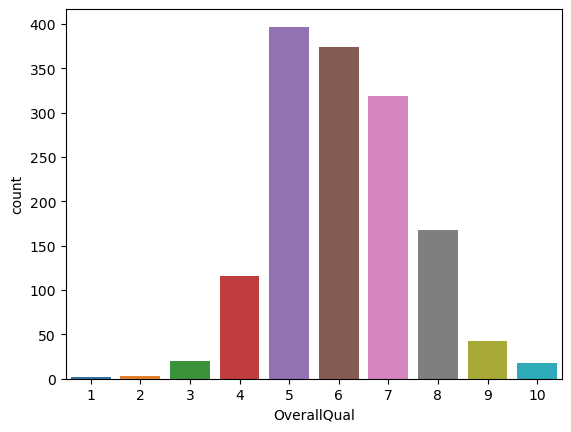

In [444]:
sns.countplot(x='OverallQual', data = HS)

###### Cleaning:

1. OverallQual 1 and 2 are significantly underrepresented and need to be cleaned. I will compare them against SalePrice and LotArea to find the right values to replace them with.

In [445]:
HS.groupby('OverallQual')[["SalePrice"]].agg([np.mean, np.median])

SalePrice          
                      mean    median
OverallQual                         
1             50150.000000   50150.0
2             51770.333333   60000.0
3             87473.750000   86250.0
4            108420.655172  108000.0
5            133523.347607  133000.0
6            161603.034759  160000.0
7            207716.423197  200141.0
8            272990.389029  269750.0
9            355117.960656  335000.0
10           378685.989857  394555.5

2. The closest for the median and mean of both 1 and 2 is OverallQual 3, which is what I will replace those values with.

In [446]:
HS.loc[HS.OverallQual == 1, 'OverallQual'] = 3
HS.loc[HS.OverallQual == 2, 'OverallQual'] = 3
HS['OverallQual'].value_counts()

OverallQual
5     397
6     374
7     319
8     168
4     116
9      43
3      25
10     18
Name: count, dtype: int64

In [447]:
HS[HS.OverallQual.isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr,LotFrontage_Trans,LotFrontage_std,GarageArea_std


3. There are no null values and it all looks usual to me so we can move on.

In [448]:
HS.OverallQual.astype('category')

0       7
1       6
2       7
3       7
4       8
       ..
1455    6
1456    6
1457    7
1458    5
1459    5
Name: OverallQual, Length: 1460, dtype: category
Categories (8, int64): [3, 4, 5, 6, 7, 8, 9, 10]

### 35) Cleaning YearSold

Taking the maximum date and subtract it from all rows in the column to make it an age.

In [449]:
HS.agg(
        {
            'YrSold':['min','mean', 'median','max','std'],
        }).round(2)

,YrSold
min,2006.00
mean,2007.82
median,2008.00
max,2010.00
std,1.33


In [450]:
WX = HS['YrSold']

In [451]:
HS['YrSold'] = abs(WX - 2010) 

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/1208161773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS['YrSold'] = abs(WX - 2010)


In [452]:
HS.agg(
        {
            'YrSold':['min','mean', 'median','max','std'],
        }).round(2)

,YrSold
min,0.00
mean,2.18
median,2.00
max,4.00
std,1.33


In [453]:
House_Age_mean = HS['YrSold'].mean()
House_Age_std = HS['YrSold'].std()

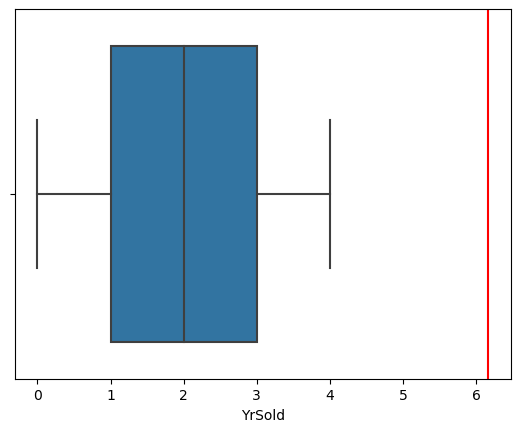

In [454]:
x = sns.boxplot(x='YrSold', data = HS)
x = x.axvline(House_Age_mean + 3* House_Age_std, ymin = 0, ymax = 1, color = 'red')
plt.show()

<Axes: xlabel='YrSold', ylabel='Density'>

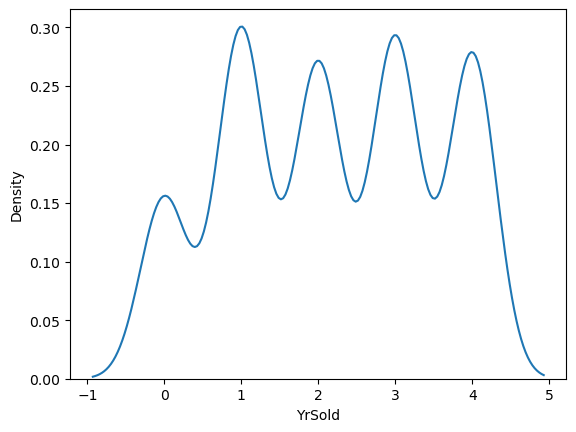

In [455]:
sns.kdeplot(x='YrSold', data = HS)

###### Cleaning:

1. There are outliers, however, they do not look to extreme so I am going to leave them in to allow for some stronger variance. The data does not follow a normal distribution, so I will use a boxcox to help. There are also no null values for house age.

In [456]:
HS[HS['House_Age'].isnull()]

,SalePrice,GarageArea,1stFlrSF,OverallQual,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood,GarageQual,...,TotalPorchSF,TotalPorchSF_transformed,TotalPorchSF_std,Pool,LotArea_Trans,LotArea_std,Has_a_2nd_Flr,LotFrontage_Trans,LotFrontage_std,GarageArea_std


In [457]:
YrSold_Transformed, best_lambda = boxcox(HS['YrSold']+0.1)  

In [458]:
HS["YrSold_Trans"] = YrSold_Transformed

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/2480531273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["YrSold_Trans"] = YrSold_Transformed


4. Now that the data is cleaned and bests follows a normal distribution, I will save the standard deviation values (z-scores) for each individual value to help me in the future.

In [459]:
scaler = StandardScaler()
HS["YrSold_std"] = scaler.fit_transform(HS[['YrSold_Trans']])
HS[["YrSold_std", "YrSold",'YrSold_Trans']].head(10)

/var/folders/2n/1sl69vv56s18gtxtgwmgrrfr0000gn/T/ipykernel_26712/79868414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HS["YrSold_std"] = scaler.fit_transform(HS[['YrSold_Trans']])


,YrSold_std,YrSold,YrSold_Trans
0,-0.042437,2,0.994860
1,0.640988,3,1.788051
2,-0.042437,2,0.994860
3,1.271573,4,2.519914
4,-0.042437,2,0.994860
5,-0.814475,1,0.098826
6,0.640988,3,1.788051
7,-0.814475,1,0.098826
8,-0.042437,2,0.994860
9,-0.042437,2,0.994860


## Linear Regression:

##### Reading in all the variables in that I will use in my linear regression.

In [460]:
HS1 =  HS[['SalePrice_std','GarageArea_std','All_House_Baths','Neighborhood','OverallQual',
           'GarageQual','Exterior1st','MasVnrArea_std','MSSubClass','LotShape',
           'Foundation','FireplaceQu','KitchenQual','ExterQual',
           'Fence','TotRmsAbvGrd','GarageFinish','GarageCars','TotalPorchSF_std','LotFrontage_std',
           'LotArea_std','TotalSqFt_std','Prop_of_SF_on_1st_std','Last_Remod_std','House_Age_bin',
           'Has_a_2nd_Flr','BsmtExposure','HeatingQC','RoofStyle','CentralAir','Electrical','YrSold_std']]
HS1.head()

,SalePrice_std,GarageArea_std,All_House_Baths,Neighborhood,OverallQual,GarageQual,Exterior1st,MasVnrArea_std,MSSubClass,LotShape,...,Prop_of_SF_on_1st_std,Last_Remod_std,House_Age_bin,Has_a_2nd_Flr,BsmtExposure,HeatingQC,RoofStyle,CentralAir,Electrical,YrSold_std
0,0.577500,0.399789,3.5,CollgCr,7,TA,VinylSd,1.225873,60,Reg,...,-1.420916,-0.809979,"(0, 15]",2-Story,No,Ex,Gable,Y,SBrkr,-0.042437
1,0.223971,0.019102,2.5,Veenker,6,TA,MetalSd,-0.821747,20,Reg,...,0.512488,0.664781,"(30, 60]",1_Story,Gd,Ex,Gable,Y,SBrkr,0.640988
2,0.754598,0.650591,3.5,CollgCr,7,TA,VinylSd,1.199444,60,IR1,...,-1.320269,-0.708415,"(0, 15]",2-Story,Mn,Ex,Gable,Y,SBrkr,-0.042437
3,-0.437830,0.789961,2.0,Crawfor,7,TA,Wd Sdng,-0.821747,70,IR1,...,-0.640663,0.855158,"(60, 140]",2-Story,No,Gd,Gable,Y,SBrkr,1.271573
4,1.040232,1.553392,3.5,NoRidge,8,TA,VinylSd,1.301450,60,IR1,...,-1.281370,-0.530152,"(0, 15]",2-Story,Av,Ex,Gable,Y,SBrkr,-0.042437


##### One hot encoding all the categorical columns together..

In [461]:
HS1 = pd.get_dummies(HS1, columns=['OverallQual','All_House_Baths','Neighborhood','GarageQual',
                                   'Exterior1st','MSSubClass','LotShape','Foundation','FireplaceQu',
                                   'KitchenQual','ExterQual','Fence','TotRmsAbvGrd',
                                   'GarageFinish','GarageCars','Has_a_2nd_Flr','House_Age_bin',
                                   'BsmtExposure','HeatingQC','RoofStyle','CentralAir',
                                   'Electrical'], dtype = int)
HS1.head()

,SalePrice_std,GarageArea_std,MasVnrArea_std,TotalPorchSF_std,LotFrontage_std,LotArea_std,TotalSqFt_std,Prop_of_SF_on_1st_std,Last_Remod_std,YrSold_std,...,HeatingQC_TA,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_SBrkr
0,0.577500,0.399789,1.225873,-0.170227,0.347489,-0.200042,0.092467,-1.420916,-0.809979,-0.042437,...,0,0,1,0,0,0,1,0,0,1
1,0.223971,0.019102,-0.821747,0.586983,0.672613,0.067640,0.036885,0.512488,0.664781,0.640988,...,0,0,1,0,0,0,1,0,0,1
2,0.754598,0.650591,1.199444,-0.414210,0.414563,0.414668,0.274094,-1.320269,-0.708415,-0.042437,...,0,0,1,0,0,0,1,0,0,1
3,-0.437830,0.789961,-0.821747,0.729981,0.233101,0.056487,-0.031318,-0.640663,0.855158,1.271573,...,0,0,1,0,0,0,1,0,0,1
4,1.040232,1.553392,1.301450,0.785305,0.755389,0.964520,1.039560,-1.281370,-0.530152,-0.042437,...,0,0,1,0,0,0,1,0,0,1


##### Dropping the first categorical for each based on the value with the highest count.

In [462]:
HS1.drop(['OverallQual_5'], axis=1, inplace = True)

In [463]:
HS1.drop(['All_House_Baths_2.0'], axis=1, inplace = True)

In [464]:
HS1.drop(['Neighborhood_NAmes'], axis=1, inplace = True)

In [465]:
HS1.drop(['GarageQual_TA'], axis=1, inplace = True)

In [466]:
HS1.drop(['Exterior1st_VinylSd'], axis=1, inplace = True)

In [467]:
HS1.drop(['MSSubClass_20'], axis=1, inplace = True)

In [468]:
HS1.drop(['LotShape_Reg'], axis=1, inplace = True)

In [469]:
HS1.drop(['Foundation_PConc'], axis=1, inplace = True)

In [470]:
HS1.drop(['FireplaceQu_No Fireplace'], axis=1, inplace = True)

In [471]:
HS1.drop(['KitchenQual_TA'], axis=1, inplace = True)

In [472]:
HS1.drop(['ExterQual_TA'], axis=1, inplace = True)

In [473]:
HS1.drop(['Fence_No Fence'], axis=1, inplace = True)

In [474]:
HS1.drop(['TotRmsAbvGrd_6'], axis=1, inplace = True)

In [475]:
HS1.drop(['GarageFinish_Unf'], axis=1, inplace = True)

In [476]:
HS1.drop(['GarageCars_0'], axis=1, inplace = True)

In [477]:
HS1.drop(['GarageQual_No Garage'], axis=1, inplace = True)

In [478]:
HS1.drop(['Has_a_2nd_Flr_1_Story'], axis=1, inplace = True)

In [479]:
HS1.drop(['House_Age_bin_(30, 60]'], axis=1, inplace = True)

In [480]:
HS1.drop(['BsmtExposure_No_Basement'], axis=1, inplace = True)

In [481]:
HS1.drop(['HeatingQC_Ex'], axis=1, inplace = True)

In [482]:
HS1.drop(['RoofStyle_Gable'], axis=1, inplace = True)

In [483]:
HS1.drop(['CentralAir_Y'], axis=1, inplace = True)

In [484]:
HS1.drop(['Electrical_SBrkr'], axis=1, inplace = True)

##### Reading in all the packages I need for the regression.

In [485]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.regressor import LinearRegression

In [486]:
outcome = HS1.SalePrice_std
predictors = HS1.iloc[:, 1: ]
predictors.head()

,GarageArea_std,MasVnrArea_std,TotalPorchSF_std,LotFrontage_std,LotArea_std,TotalSqFt_std,Prop_of_SF_on_1st_std,Last_Remod_std,YrSold_std,OverallQual_3,...,BsmtExposure_No,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_TA,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Hip,CentralAir_N,Electrical_FuseA,Electrical_FuseF
0,0.399789,1.225873,-0.170227,0.347489,-0.200042,0.092467,-1.420916,-0.809979,-0.042437,0,...,1,0,0,0,0,0,0,0,0,0
1,0.019102,-0.821747,0.586983,0.672613,0.067640,0.036885,0.512488,0.664781,0.640988,0,...,0,0,0,0,0,0,0,0,0,0
2,0.650591,1.199444,-0.414210,0.414563,0.414668,0.274094,-1.320269,-0.708415,-0.042437,0,...,0,0,0,0,0,0,0,0,0,0
3,0.789961,-0.821747,0.729981,0.233101,0.056487,-0.031318,-0.640663,0.855158,1.271573,0,...,1,0,1,0,0,0,0,0,0,0
4,1.553392,1.301450,0.785305,0.755389,0.964520,1.039560,-1.281370,-0.530152,-0.042437,0,...,0,0,0,0,0,0,0,0,0,0


###### To start I will try a simple linear regression

In [487]:
model = pg.linear_regression(y = outcome, X= predictors)
print(model)

                 names      coef        se         T      pval        r2  \
0            Intercept -0.035915  0.097328 -0.369009  0.712179  0.911936   
1       GarageArea_std  0.032032  0.023385  1.369749  0.170995  0.911936   
2       MasVnrArea_std -0.002362  0.011061 -0.213552  0.830929  0.911936   
3     TotalPorchSF_std  0.037066  0.010066  3.682347  0.000240  0.911936   
4      LotFrontage_std -0.015415  0.009463 -1.628887  0.103572  0.911936   
..                 ...       ...       ...       ...       ...       ...   
117  RoofStyle_Gambrel -0.081845  0.099082 -0.826040  0.408929  0.911936   
118      RoofStyle_Hip  0.010044  0.023759  0.422727  0.672562  0.911936   
119       CentralAir_N -0.217397  0.045054 -4.825280  0.000002  0.911936   
120   Electrical_FuseA -0.023193  0.037122 -0.624763  0.532233  0.911936   
121   Electrical_FuseF  0.002482  0.065290  0.038009  0.969686  0.911936   

       adj_r2  CI[2.5%]  CI[97.5%]  
0    0.904043 -0.226847   0.155017  
1    0.904043

/Users/kaiallen/anaconda3/lib/python3.11/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 121 with 122 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(


##### Now going to check all of the assumptions

1.  There exists a linear relationship between the Outcome (DV) and the Predictor (IV) variable(s).
2.  The error terms are normally distributed with a mean of 0. 
3.  The variance of the error terms is not related predicted outcomes (homoskedasticity).  If this assumption is not met, the model exhibits heteroskedasticity and cannot be relied on. 
4.  There is no multicollinearity between predictor variables.  

In [488]:
model.residuals_            

array([ 0.04703526, -0.25420691,  0.01583249, ...,  0.15573483,
       -0.00554098,  0.11803901])

In [489]:
HS1["errors"] = model.residuals_


In [490]:
HS1["Fitted_Saleprice_std"] = HS1.SalePrice_std - HS1.errors

<Axes: xlabel='errors', ylabel='Density'>

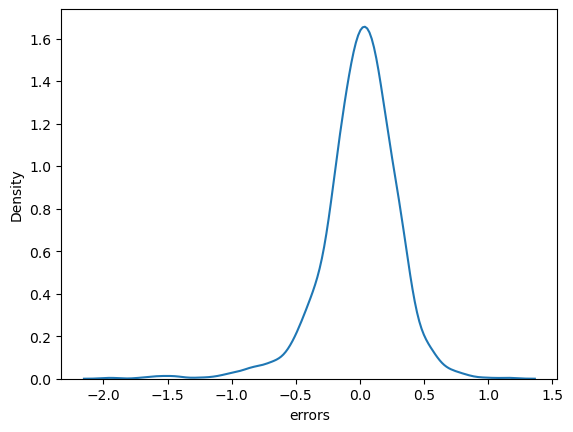

In [491]:
sns.kdeplot(x = "errors", data = HS1)    ### the errors are mostly normally distributed 
                                          ### with a mean of 0

The errors appear to be normally distruted with mean of zero.  However, it appears that there are a few observations, where the error terms are less than -1.75.  These are rows of data that do not fit the model well.  I want to look at those rows to see if there are any vaues that look unusual.  

In [492]:
HS1[HS1.errors < -1.75]

,SalePrice_std,GarageArea_std,MasVnrArea_std,TotalPorchSF_std,LotFrontage_std,LotArea_std,TotalSqFt_std,Prop_of_SF_on_1st_std,Last_Remod_std,YrSold_std,...,HeatingQC_Gd,HeatingQC_TA,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Hip,CentralAir_N,Electrical_FuseA,Electrical_FuseF,errors,Fitted_Saleprice_std
632,-1.78595,0.382833,1.234599,0.180221,0.775854,0.541497,0.389301,0.550339,0.630703,-0.814475,...,0,1,0,0,1,0,0,0,-1.945763,0.159814


In [493]:
HS1.iloc[30,0] = [-0.5]
HS1.iloc[632,0] = [0]

In [494]:
HS1[HS1.errors < -1.75]

,SalePrice_std,GarageArea_std,MasVnrArea_std,TotalPorchSF_std,LotFrontage_std,LotArea_std,TotalSqFt_std,Prop_of_SF_on_1st_std,Last_Remod_std,YrSold_std,...,HeatingQC_Gd,HeatingQC_TA,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Hip,CentralAir_N,Electrical_FuseA,Electrical_FuseF,errors,Fitted_Saleprice_std
632,0.0,0.382833,1.234599,0.180221,0.775854,0.541497,0.389301,0.550339,0.630703,-0.814475,...,0,1,0,0,1,0,0,0,-1.945763,0.159814


There is only one observation where the error is slightly more than 2 standard deviations below the mean so I am not worried about it.  

Next, let's check the assumuption of constant variance of the error terms.  

<Axes: xlabel='Fitted_Saleprice_std', ylabel='errors'>

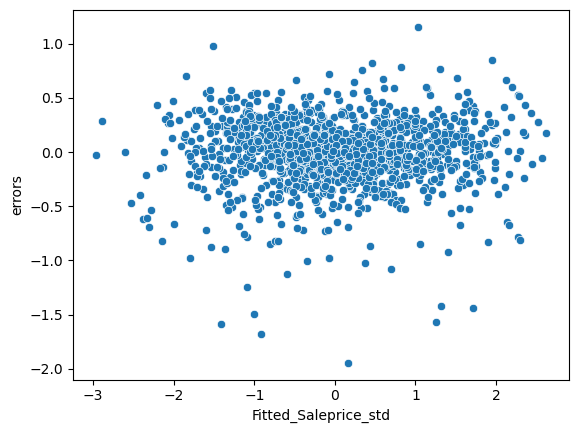

In [495]:
sns.scatterplot(x = "Fitted_Saleprice_std", y = "errors",  data = HS1)



The error terms do not seem to be related to the size of the fitted dependent values so the model does not exhibit characteristics of heterskedasticity.  Next, let's assess the variance inflation factors to ensure that the predictors do not exhibit high multicollinearity.  

In [496]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif['variable'] = predictors.columns
vif[:]

,VIF,variable
0,8.473613,GarageArea_std
1,1.895662,MasVnrArea_std
2,1.569973,TotalPorchSF_std
3,1.387678,LotFrontage_std
4,3.534013,LotArea_std
...,...,...
116,1.137452,RoofStyle_Gambrel
117,1.385086,RoofStyle_Hip
118,1.913399,CentralAir_N
119,1.286271,Electrical_FuseA


I have fixed all issues with VIF up in the script. This included house age by binning it, removing all the variables that consisted of no garage, as well as total square footage and proportion of squarefootage on the first floor.

#### Stepwise Regression

Trying a stepwise regression before my final attempt to see how it impacts the model.

In [497]:
X = predictors
y = outcome
regression_model = LinearRegression()   ### using scikit learn regression function 

In [498]:
sfs = SequentialFeatureSelector(regression_model,
                                k_features= 30, 
                                forward=True,
                                verbose = 1,
                                scoring='neg_mean_squared_error',
                                cv=None)


In [499]:
selected_features = sfs.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 121 out of 121 | elapsed:    0.1s finished
Features: 1/30[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s finished
Features: 2/30[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:    0.1s finished
Features: 3/30[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:    0.1s finished
Features: 4/30[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed:    0.1s finished
Features: 5/30[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    0.1s finished
Features: 6/30[Parallel(

In [500]:
selected_features.k_feature_names_

('GarageArea_std',
 'TotalPorchSF_std',
 'LotArea_std',
 'TotalSqFt_std',
 'Last_Remod_std',
 'OverallQual_3',
 'OverallQual_6',
 'OverallQual_7',
 'OverallQual_8',
 'OverallQual_9',
 'OverallQual_10',
 'All_House_Baths_1.0',
 'All_House_Baths_3.5',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'GarageQual_Fa',
 'Exterior1st_BrkFace',
 'MSSubClass_30',
 'MSSubClass_60',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'TotRmsAbvGrd_12',
 'BsmtExposure_Gd',
 'BsmtExposure_No',
 'CentralAir_N')

In [501]:
predictors = HS1.loc[:, selected_features.k_feature_names_]
outcome = HS1.SalePrice_std

model = pg.linear_regression(X = predictors, y= outcome) 
print(model)

                   names      coef        se          T           pval  \
0              Intercept -0.207252  0.025633  -8.085316   1.309735e-15   
1         GarageArea_std  0.099768  0.010945   9.115491   2.577157e-19   
2       TotalPorchSF_std  0.054208  0.009520   5.693873   1.505103e-08   
3            LotArea_std  0.084179  0.010445   8.059089   1.608527e-15   
4          TotalSqFt_std  0.325346  0.013997  23.244522  1.224169e-101   
5         Last_Remod_std -0.117581  0.011922  -9.862484   3.048103e-22   
6          OverallQual_3 -0.369573  0.068833  -5.369109   9.223660e-08   
7          OverallQual_6  0.169469  0.023758   7.133042   1.554810e-12   
8          OverallQual_7  0.363554  0.030382  11.966218   1.619112e-31   
9          OverallQual_8  0.564384  0.040934  13.787788   1.074321e-40   
10         OverallQual_9  0.796625  0.070520  11.296417   2.100887e-28   
11        OverallQual_10  0.562047  0.093671   6.000209   2.493478e-09   
12   All_House_Baths_1.0 -0.130333  0.

##### Now going to check all of the assumptions

1.  There exists a linear relationship between the Outcome (DV) and the Predictor (IV) variable(s).
2.  The error terms are normally distributed with a mean of 0. 
3.  The variance of the error terms is not related predicted outcomes (homoskedasticity).  If this assumption is not met, the model exhibits heteroskedasticity and cannot be relied on. 
4.  There is no multicollinearity between predictor variables.  

In [502]:
HS1["errors"] = model.residuals_

In [503]:
HS1["Fitted_Saleprice_std"] = HS1.SalePrice_std - HS1.errors

<Axes: xlabel='errors', ylabel='Density'>

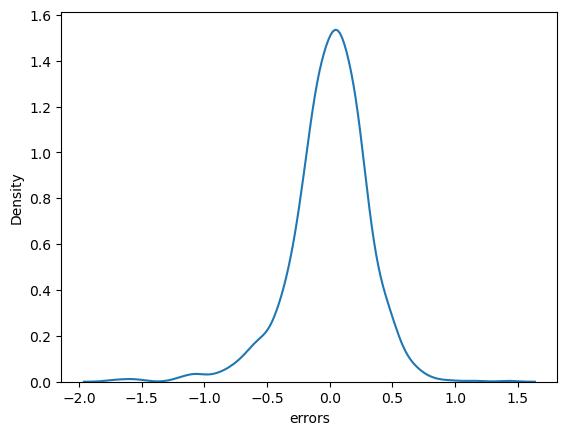

In [504]:
sns.kdeplot(x = "errors", data = HS1)    ### the errors are mostly normally distributed 
                                          ### with a mean of 0

In [505]:
HS1[HS1.errors < -1.75]

,SalePrice_std,GarageArea_std,MasVnrArea_std,TotalPorchSF_std,LotFrontage_std,LotArea_std,TotalSqFt_std,Prop_of_SF_on_1st_std,Last_Remod_std,YrSold_std,...,HeatingQC_Gd,HeatingQC_TA,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Hip,CentralAir_N,Electrical_FuseA,Electrical_FuseF,errors,Fitted_Saleprice_std


##### Replacing the SalePrice_std in order to improve my test for variance in the error terms. This hopefully will make them more normally distributed with a mean of 0.

In [506]:
HS1.iloc[410,0] = [-1.2]
HS1.iloc[495,0] = [-2.2]
HS1.iloc[1298,0] = [1.5]

In [507]:
HS1["errors"] = model.residuals_

In [508]:
HS1["Fitted_Saleprice_std"] = HS1.SalePrice_std - HS1.errors

In [509]:
HS1[HS1.errors < -1.75]

,SalePrice_std,GarageArea_std,MasVnrArea_std,TotalPorchSF_std,LotFrontage_std,LotArea_std,TotalSqFt_std,Prop_of_SF_on_1st_std,Last_Remod_std,YrSold_std,...,HeatingQC_Gd,HeatingQC_TA,RoofStyle_Flat,RoofStyle_Gambrel,RoofStyle_Hip,CentralAir_N,Electrical_FuseA,Electrical_FuseF,errors,Fitted_Saleprice_std


<Axes: xlabel='Fitted_Saleprice_std', ylabel='errors'>

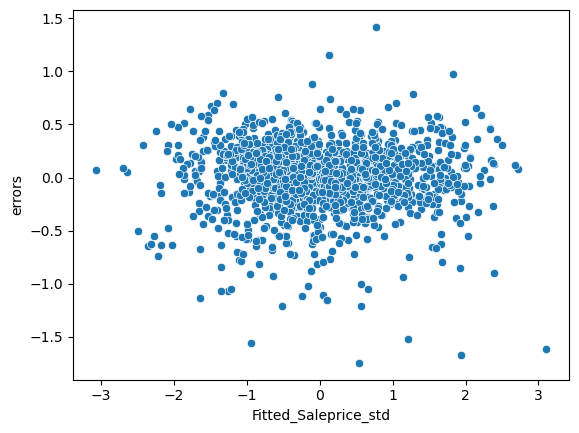

In [510]:
sns.scatterplot(x = "Fitted_Saleprice_std", y = "errors",  data = HS1)

# Final Submission

Using the stepwise linear regression I will complete my final regression in hopes of optimizing my adj-r-squared score.

In [511]:
X = predictors = HS1.iloc[:, 1:-2]
y = HS1.SalePrice_std
regression_model = LinearRegression()   ### using scikit learn regression function 

In [512]:
sfs = SequentialFeatureSelector(regression_model,
                                k_features= 77, 
                                forward=False,
                                verbose = 1,
                                scoring='neg_mean_squared_error',
                                cv=None)


In [513]:
selected_features = sfs.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 121 out of 121 | elapsed:    0.4s finished
Features: 120/77[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished
Features: 119/77[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:    0.4s finished
Features: 118/77[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:    0.3s finished
Features: 117/77[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed:    0.3s finished
Features: 116/77[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    0.3s finished
Features: 115/

In [514]:
selected_features.k_feature_names_

('GarageArea_std',
 'TotalPorchSF_std',
 'LotFrontage_std',
 'LotArea_std',
 'TotalSqFt_std',
 'Last_Remod_std',
 'YrSold_std',
 'OverallQual_3',
 'OverallQual_4',
 'OverallQual_6',
 'OverallQual_7',
 'OverallQual_8',
 'OverallQual_9',
 'OverallQual_10',
 'All_House_Baths_1.0',
 'All_House_Baths_2.5',
 'All_House_Baths_3.0',
 'All_House_Baths_3.5',
 'All_House_Baths_4 or more',
 'Neighborhood_Blmngtn',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'GarageQual_Fa',
 'GarageQual_Gd',
 'Exterior1st_BrkFace',
 'Exterior1st_MetalSd',
 'Exterior1st_Stucco',
 'Exterior1st_Wd Sdng',
 'MSSubClass_30',
 'MSSubClass_50',
 'MSSub

In [515]:
predictors = HS1.loc[:, selected_features.k_feature_names_]
outcome = HS1.SalePrice_std

model = pg.linear_regression(X = predictors, y= outcome) 
print(model)

                names      coef        se         T          pval        r2  \
0           Intercept  0.011326  0.058450  0.193776  8.463797e-01  0.919303   
1      GarageArea_std  0.033798  0.021162  1.597114  1.104689e-01  0.919303   
2    TotalPorchSF_std  0.039543  0.009143  4.324885  1.635654e-05  0.919303   
3     LotFrontage_std -0.012447  0.008243 -1.510018  1.312675e-01  0.919303   
4         LotArea_std  0.068596  0.012563  5.459984  5.638624e-08  0.919303   
..                ...       ...       ...       ...           ...       ...   
73       HeatingQC_Fa -0.099397  0.048394 -2.053904  4.017274e-02  0.919303   
74       HeatingQC_Gd -0.049977  0.023968 -2.085198  3.723443e-02  0.919303   
75       HeatingQC_TA -0.074512  0.023165 -3.216522  1.327598e-03  0.919303   
76  RoofStyle_Gambrel  0.162138  0.090395  1.793671  7.308424e-02  0.919303   
77       CentralAir_N -0.194440  0.039132 -4.968869  7.575581e-07  0.919303   

      adj_r2  CI[2.5%]  CI[97.5%]  
0   0.914807 -0

##### Now going to check all of the assumptions

1.  There exists a linear relationship between the Outcome (DV) and the Predictor (IV) variable(s).
2.  The error terms are normally distributed with a mean of 0. 
3.  The variance of the error terms is not related predicted outcomes (homoskedasticity).  If this assumption is not met, the model exhibits heteroskedasticity and cannot be relied on. 
4.  There is no multicollinearity between predictor variables.  

<Axes: xlabel='Fitted_Saleprice_std', ylabel='errors'>

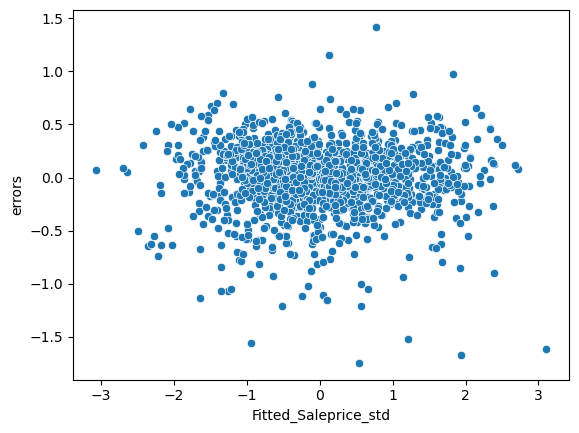

In [516]:
sns.scatterplot(x = "Fitted_Saleprice_std", y = "errors",  data = HS1)

###### There is homoskedasticity of error terms, therefore passing this assumption.

<Axes: xlabel='errors', ylabel='Density'>

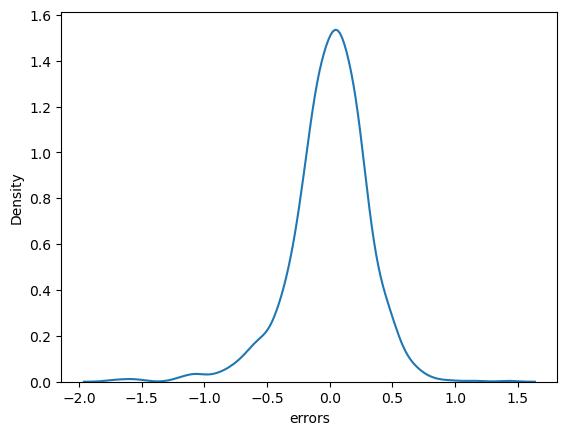

In [517]:
sns.kdeplot(x = "errors", data = HS1)

###### The error terms are quite normally distributed with a mean of about 0.

In [518]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif['variable'] = predictors.columns
vif[:]

,VIF,variable
0,6.117697,GarageArea_std
1,1.470879,TotalPorchSF_std
2,1.198365,LotFrontage_std
3,2.756754,LotArea_std
4,3.655143,TotalSqFt_std
...,...,...
72,1.406296,HeatingQC_Fa
73,1.610573,HeatingQC_Gd
74,2.622255,HeatingQC_TA
75,1.088780,RoofStyle_Gambrel


###### There is no multicolinearity between variables as none of the numeric VIF scores are above 10.

## All assumptions have been met and our final highest adjusted r^2 obtained was  0.914807

##### Conclusion:

I have cleaned all the variables, ran the linear regressionl, and met all the project requirements. My final model includes 26 variables. The highest VIF score for a numeric variable was 6.117697	for GarageArea_std, which all things considered I am very happy with. Moreover, there are not even any categorical variables with a VIF score of over 10. The four assumptions that were needed for a valid linear reqression in this class were met. The three best variables were TotalSqFt_std with an extremely low p-value of 1.759668e-87, Overall quality with super low p-values for all the chosen qualities with the lowest being OverallQual_8 with a p-value of 6.902841e-22, and all the chosen neighborhood with the lowest p-value being 3.921858e-13. Of course it makes sense that TotalSqFt is the highest as a big house usually means spending big money. This was a very successful project that I put a lot of time into but I really enjoyed the process and learned a lot about running linear regressions.